# Comprehensive Audiology Analysis Pipeline v4.12 - analysis_merged_sk-cc-v4.12**Analysis Tool for CRM, Vowel, and Consonant Perception Experiments**## OverviewThis notebook is my analysis pipeline for CRM, vowel, consonant data.### Features:- **Hard-coded configuration** for reproducible analysis- **Advanced phonetic feature analysis** (Place, Manner, Voicing)- **Comprehensive statistical testing** with confidence intervals and effect sizes- **10 exploratory analyses** covering temporal trends, talker effects, correlation analyses- **Neat visualizations** with proper error bars and sample sizes- **Granular CRM analysis** including gender-specific masking effects### Instructions:1. Edit the `CONFIGURATION` section below with your data path and CRM condition mappings2. Run all cells sequentially3. Review outputs and statistical tests**Key Additions in v4.12:**- MATLAB-exact reversal calculation (calculate_srt_reversals_matlab)- Vowel talker gender mapping from vowels9.m (20 talkers)- SNR 50% threshold calculation and visualizations- Subject data aggregator with systematic nomenclature- Composite figures for all stratified visualizations- Additional CDF plots for comprehensive analysis

## 1. Setup and Configuration

In [1]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
import re
import glob
import warnings
from pathlib import Path
from collections import defaultdict
import itertools

warnings.filterwarnings('ignore')

# ===== VISUALIZATION SETTINGS =====
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

print("✓ Libraries imported successfully")
print("✓ Visualization settings configured")

✓ Libraries imported successfully
✓ Visualization settings configured


### CONFIGURATION SECTION
**CRITICAL: Edit this section before running the analysis**

In [2]:
# ========================================
# USER CONFIGURATION
# ========================================

# 1. DATA DIRECTORY PATH
# Set this to the absolute path of your subject's data folder
DATA_DIR = "/Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148"  # CHANGE THIS

# 2. CRM CONDITION MAPPING
# Map each CRM run number (extracted from filename like CI148_crm_3.txt) to its condition
# Available conditions: 'BM' (Bimodal), 'CI' (Cochlear Implant), 'HA' (Hearing Aid), 'Practice'
CRM_CONDITION_MAP = {
    0: 'Practice',
    1: 'BM',
    2: 'BM',
    3: 'BM',
    4: 'CI',
    5: 'HA',
    6: 'CI',
    7: 'HA',
    8: 'BM',
    9: 'HA',
    10: 'CI',
    # Add additional mappings as needed
}

# 3. PHONEME MAPPINGS (Standard - usually don't need to change)
VOWEL_MAP = {
    1: 'AE', 2: 'AH', 3: 'AW', 4: 'EH', 5: 'IH',
    6: 'IY', 7: 'OO', 8: 'UH', 9: 'UW'
}

CONSONANT_MAP = {
    1: '#', 2: '_', 3: 'b', 4: 'd', 5: 'f', 6: 'g',
    7: 'k', 8: 'm', 9: 'n', 10: '%', 11: 'p', 12: 's',
    13: 't', 14: 'v', 15: 'z', 16: '$'
}

# 4. PHONETIC FEATURE MAPPINGS (Miller-Nicely Framework)
# Format: phoneme: (voicing, place, manner)
# Voicing: 0=voiceless, 1=voiced
# Place: 0=labial, 1=alveolar, 2=velar, 3=palatal
# Manner: 0=stop, 1=nasal, 2=fricative, 3=affricate
CONSONANT_FEATURES = {
    'b': (1, 0, 0), 'p': (0, 0, 0),  # Labial stops
    'd': (1, 1, 0), 't': (0, 1, 0),  # Alveolar stops
    'g': (1, 2, 0), 'k': (0, 2, 0),  # Velar stops
    'm': (1, 0, 1), 'n': (1, 1, 1),  # Nasals
    'f': (0, 0, 2), 'v': (1, 0, 2),  # Labial fricatives
    's': (0, 1, 2), 'z': (1, 1, 2),  # Alveolar fricatives
    '#': (0, 3, 2), '_': (1, 3, 2),  # Palatal fricatives (sh, zh)
    '%': (0, 3, 3), '$': (1, 3, 3),  # Affricates (ch, j)
}

print("✓ Configuration loaded")
print(f"  Data directory: {DATA_DIR}")
print(f"  CRM conditions: {len(CRM_CONDITION_MAP)} runs mapped")
print(f"  Phoneme mappings: {len(VOWEL_MAP)} vowels, {len(CONSONANT_MAP)} consonants")

✓ Configuration loaded
  Data directory: /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148
  CRM conditions: 11 runs mapped
  Phoneme mappings: 9 vowels, 16 consonants


## 2. Helper Functions and Data Loading

In [ ]:
# ===== HELPER FUNCTIONS =====

def get_gender(talker_id):
    """Returns gender based on talker ID. IDs 0-3 are Male, 4-7 are Female."""
    if pd.isna(talker_id):
        return None
    return 'M' if int(talker_id) <= 3 else 'F'

def get_vowel_talker_gender(talker_id):
    """
    Gender mapping derived from vowels9.m prefixes (M=Male, W=Female).
    Talker list from vowels9.m line 45-46:
    M01, M03, M06, M08, M11, M24, M30, M33, M39, M41 (Male)
    W01, W04, W09, W14, W15, W23, W25, W26, W44, W47 (Female)
    """
    VOWEL_TALKER_GENDER = {
        1: 'M',   # M01
        2: 'M',   # M03
        3: 'M',   # M06
        4: 'M',   # M08
        5: 'M',   # M11
        6: 'M',   # M24
        7: 'M',   # M30
        8: 'M',   # M33
        9: 'M',   # M39
        10: 'M',  # M41
        11: 'F',  # W01
        12: 'F',  # W04
        13: 'F',  # W09
        14: 'F',  # W14
        15: 'F',  # W15
        16: 'F',  # W23
        17: 'F',  # W25
        18: 'F',  # W26
        19: 'F',  # W44
        20: 'F',  # W47
    }
    if pd.isna(talker_id):
        return None
    return VOWEL_TALKER_GENDER.get(int(talker_id), None)

def parse_crm_header(filepath):
    """Extracts talker and masker IDs from CRM file header."""
    try:
        with open(filepath, 'r') as f:
            header = f.readline()
        match = re.search(r'Talker (\d+), Maskers (\d+) and (\d+)', header)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
    except Exception as e:
        print(f"Header parse error: {e}")
    return None, None, None

def calculate_srt_reversals_matlab(df_run):
    """
    MATLAB-exact reversal calculation from CRM.m (lines 101-203).
    
    Algorithm:
    1. Track SNR (mlevel - tlevel) at each reversal point
    2. Reversal = transition where correct->incorrect OR incorrect->correct
    3. SRT = mean(reversals 5-14) if >= 14 reversals exist
    4. Returns: (srt, std, n_reversals, all_reversals)
    
    MATLAB logic:
    - Lines 183-199: Reversal detection
    - Line 206: summaryvals calculation  
    - Line 215: SRT = tlevel - mean(mlevelrev(5:14))
    """
    snr = df_run['snr'].values
    correct = ((df_run['tc'] == df_run['rc']) & (df_run['tn'] == df_run['rn'])).values
    
    reversals = []
    nrev = 0
    prevdir = None
    
    for t in range(len(correct)):
        if t == 0:
            prevdir = 1 if correct[t] else -1
            continue
        
        if correct[t]:
            # Correct response
            if prevdir == -1 and t > 0:  # Was incorrect, now correct
                nrev += 1
                reversals.append(snr[t])
            prevdir = 1
        else:
            # Incorrect response
            if prevdir == 1 and t > 0:  # Was correct, now incorrect
                nrev += 1
                reversals.append(snr[t])
            prevdir = -1
    
    if len(reversals) >= 5:
        calc_revs = reversals[4:14] if len(reversals) >= 14 else reversals[4:]
        srt = np.mean(calc_revs)
        srt_sd = np.std(calc_revs, ddof=1)
        return srt, srt_sd, len(reversals), reversals
    
    return np.nan, np.nan, len(reversals), reversals

def calculate_snr_50_threshold(df_run):
    """
    SNR 50% Threshold from MATLAB CRM.m line 207.
    
    Formula: (mean(mlevelrev(5:14)) - tlevel) * -1
    
    In the data files:
    - snr column = tlevel - mlevel (signal relative to noise)
    - At reversal points, we have the actual SNR values
    - The 50% threshold is the mean SNR at reversals 5-14
    
    This represents the SNR where performance is at 50% (the psychometric midpoint).
    """
    _, _, _, reversals = calculate_srt_reversals_matlab(df_run)
    
    if len(reversals) >= 5:
        calc_revs = reversals[4:14] if len(reversals) >= 14 else reversals[4:]
        snr_50 = np.mean(calc_revs)
        snr_50_sd = np.std(calc_revs, ddof=1)
        return snr_50, snr_50_sd
    
    return np.nan, np.nan

def calculate_ci_bootstrap(data, confidence=0.95, n_bootstrap=1000):
    """
    Calculates confidence interval using bootstrap resampling.
    Returns (mean, lower_bound, upper_bound, std_err).
    """
    data_clean = np.array([x for x in data if not np.isnan(x)])
    if len(data_clean) < 2:
        return np.nan, np.nan, np.nan, np.nan
    
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data_clean, size=len(data_clean), replace=True)
        means.append(np.mean(sample))
    
    mean_val = np.mean(data_clean)
    alpha = 1 - confidence
    lower = np.percentile(means, (alpha/2) * 100)
    upper = np.percentile(means, (1 - alpha/2) * 100)
    stderr = np.std(data_clean) / np.sqrt(len(data_clean))
    
    return mean_val, lower, upper, stderr

def stat_test_auto(group1, group2, alpha=0.05):
    """
    Automatically selects and performs appropriate statistical test.
    Returns: (test_name, statistic, p_value, effect_size)
    """
    g1 = np.array([x for x in group1 if not np.isnan(x)])
    g2 = np.array([x for x in group2 if not np.isnan(x)])
    
    if len(g1) < 3 or len(g2) < 3:
        return "Insufficient data", np.nan, np.nan, np.nan
    
    # Test normality
    _, p1 = shapiro(g1) if len(g1) <= 5000 else (None, 1.0)  # Skip for large samples
    _, p2 = shapiro(g2) if len(g2) <= 5000 else (None, 1.0)
    
    # Cohen's d effect size
    pooled_std = np.sqrt(((len(g1)-1)*np.var(g1, ddof=1) + (len(g2)-1)*np.var(g2, ddof=1)) / (len(g1)+len(g2)-2))
    cohens_d = (np.mean(g1) - np.mean(g2)) / pooled_std if pooled_std > 0 else 0
    
    if p1 > alpha and p2 > alpha:
        # Parametric: Check equal variance
        _, p_var = levene(g1, g2)
        if p_var > alpha:
            stat, p = ttest_ind(g1, g2, equal_var=True)
            test_name = "Student's t-test"
        else:
            stat, p = ttest_ind(g1, g2, equal_var=False)
            test_name = "Welch's t-test"
    else:
        # Non-parametric
        stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
        test_name = "Mann-Whitney U"
    
    return test_name, stat, p, cohens_d

print("✓ Helper functions defined")

### Data Loading

In [ ]:
# ===== LOAD DATA =====

def load_all_data(base_path, crm_map, vowel_map, cons_map):
    """
    Loads all experiment data from the specified directory.
    Returns: (df_crm, df_vowel, df_consonant, df_crm_summary)
    """
    base_path = Path(base_path)
    subject_id = base_path.name
    
    print(f"\n{'='*60}")
    print(f"Loading data for subject: {subject_id}")
    print(f"{'='*60}\n")
    
    # --- 1. LOAD CRM DATA ---
    crm_files = sorted(base_path.glob('*_crm_*.txt'))
    crm_data = []
    crm_summary = []
    
    print(f"Processing {len(crm_files)} CRM files...")
    
    for fpath in crm_files:
        # Extract run number
        match = re.search(r'_crm_(\d+)', fpath.name)
        if not match:
            continue
        run_id = int(match.group(1))
        condition = crm_map.get(run_id, 'Unknown')
        
        # Parse header for talker/masker info
        talker, m1, m2 = parse_crm_header(fpath)
        if talker is None:
            print(f"  Warning: Could not parse header for {fpath.name}")
            continue
        
        t_gender = get_gender(talker)
        m_gender = get_gender(m1)
        masker_type = "Same" if t_gender == m_gender else "Diff"
        gender_config = f"{t_gender}-{m_gender}{get_gender(m2)}"
        
        try:
            # Load trial data
            df_temp = pd.read_csv(fpath, sep='\s+', header=None, skiprows=2,
                                 names=['run', 'tc', 'rc', 'tn', 'rn', 'snr', 'rt'],
                                 on_bad_lines='skip')
            
            # Clean data (remove footer lines)
            df_temp = df_temp[pd.to_numeric(df_temp['run'], errors='coerce').notna()]
            df_temp = df_temp.astype({'tc': float, 'rc': float, 'tn': float, 'rn': float, 'snr': float, 'rt': float})
            
            # Add metadata
            df_temp['run_id'] = run_id
            df_temp['condition'] = condition
            df_temp['masker_type'] = masker_type
            df_temp['gender_config'] = gender_config
            df_temp['talker_gender'] = t_gender
            df_temp['masker_gender'] = m_gender
            df_temp['filename'] = fpath.name
            
            # Calculate correctness
            df_temp['correct'] = (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] == df_temp['rn'])
            
            # Classify error types
            conditions_err = [
                (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] == df_temp['rn']),
                (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] != df_temp['rn']),
                (df_temp['tc'] != df_temp['rc']) & (df_temp['tn'] == df_temp['rn'])
            ]
            choices_err = ['Correct', 'Number Error', 'Color Error']
            df_temp['error_type'] = np.select(conditions_err, choices_err, default='Both Error')
            
            # Add trial index within run
            df_temp['trial_in_run'] = range(1, len(df_temp) + 1)
            
            crm_data.append(df_temp)
            
            # Calculate SRT
            srt, srt_sd, n_rev, _ = calculate_srt_reversals_matlab(df_temp)
            snr_50, snr_50_sd = calculate_snr_50_threshold(df_temp)
            
            crm_summary.append({
                'run_id': run_id,
                'filename': fpath.name,
                'condition': condition,
                'masker_type': masker_type,
                'gender_config': gender_config,
                'talker_gender': t_gender,
                'masker_gender': m_gender,
                'srt': srt,
                'srt_sd': srt_sd,
                'snr_50_threshold': snr_50,
                'snr_50_sd': snr_50_sd,
                'n_reversals': n_rev,
                'n_trials': len(df_temp),
                'accuracy': df_temp['correct'].mean()
            })
            
        except Exception as e:
            print(f"  Error processing {fpath.name}: {e}")
            continue
    
    df_crm = pd.concat(crm_data, ignore_index=True) if crm_data else pd.DataFrame()
    df_crm_summary = pd.DataFrame(crm_summary) if crm_summary else pd.DataFrame()
    
    print(f"  ✓ CRM: {len(crm_summary)} runs loaded, {len(df_crm)} total trials")
    
    # --- 2. LOAD VOWEL DATA ---
    vowel_files = list(base_path.glob('*vow*.*txt')) + list(base_path.glob('*vow*.out'))
    vowel_data = []
    
    for vfile in vowel_files:
        condition = 'BM' if 'BM' in vfile.name else 'CI' if 'CI' in vfile.name else 'HA' if 'HA' in vfile.name else 'Unknown'
        try:
            df_v = pd.read_csv(vfile, sep='\s+', header=None,
                              names=['talker_id', 'target_id', 'response_id', 'score', 'rt'])
            df_v['condition'] = condition
            df_v['target_label'] = df_v['target_id'].map(vowel_map)
            df_v['response_label'] = df_v['response_id'].map(vowel_map)
            df_v['talker_gender'] = df_v['talker_id'].apply(get_vowel_talker_gender)
            df_v['trial_idx'] = range(1, len(df_v) + 1)
            vowel_data.append(df_v)
        except Exception as e:
            print(f"  Warning: Could not load {vfile.name}: {e}")
    
    df_vowel = pd.concat(vowel_data, ignore_index=True) if vowel_data else pd.DataFrame()
    print(f"  ✓ Vowels: {len(vowel_files)} files loaded, {len(df_vowel)} total trials")
    
    # --- 3. LOAD CONSONANT DATA ---
    cons_files = list(base_path.glob('*cons*.*txt')) + list(base_path.glob('*cons*.out'))
    cons_data = []
    
    for cfile in cons_files:
        condition = 'BM' if 'BM' in cfile.name else 'CI' if 'CI' in cfile.name else 'HA' if 'HA' in cfile.name else 'Unknown'
        try:
            df_c = pd.read_csv(cfile, sep='\s+', header=None,
                              names=['talker_id', 'target_id', 'response_id', 'score', 'rt'])
            df_c['condition'] = condition
            df_c['target_label'] = df_c['target_id'].map(cons_map)
            df_c['response_label'] = df_c['response_id'].map(cons_map)
            df_c['talker_gender'] = df_c['talker_id'].apply(get_gender)
            df_c['trial_idx'] = range(1, len(df_c) + 1)
            cons_data.append(df_c)
        except Exception as e:
            print(f"  Warning: Could not load {cfile.name}: {e}")
    
    df_consonant = pd.concat(cons_data, ignore_index=True) if cons_data else pd.DataFrame()
    print(f"  ✓ Consonants: {len(cons_files)} files loaded, {len(df_consonant)} total trials")
    
    print(f"\n{'='*60}")
    print("Data loading complete!")
    print(f"{'='*60}\n")
    
    return df_crm, df_vowel, df_consonant, df_crm_summary

# Execute loading
df_crm, df_vowel, df_consonant, df_crm_summary = load_all_data(
    DATA_DIR, CRM_CONDITION_MAP, VOWEL_MAP, CONSONANT_MAP
)

## Subject Data AggregatorThis section provides functions to automatically aggregate data for all subjects and create merged CSV files with systematic nomenclature.

In [ ]:
# ========================================# SUBJECT DATA AGGREGATOR# ========================================"""Automatically aggregates data for all subjects and creates merged CSV files.Nomenclature: [Subject_ID]_[cvc]_[yy.mm.dd].csv- Uppercase letter = data present (C=Consonants, V=Vowels, C=CRM)- Lowercase letter = data absent (c=no consonants, v=no vowels, c=no CRM)- Date = today's date when CSV is createdExamples:  CI148_CVC_25.11.19.csv  <- All three datasets present  CI149_cVC_25.11.19.csv  <- Only vowels and CRM (no consonants)  CI150_Cvc_25.11.19.csv  <- Only consonants (no vowels, no CRM)"""from datetime import datetimedef create_subject_aggregate(subject_path, output_dir=None):    """    Creates aggregated CSV for a single subject.    Returns: (filename, has_consonants, has_vowels, has_crm)    """    subject_path = Path(subject_path)    subject_id = subject_path.name    if output_dir is None:        output_dir = subject_path    else:        output_dir = Path(output_dir)        output_dir.mkdir(exist_ok=True)    # Load all data    df_crm_s, df_vowel_s, df_cons_s, df_crm_summ_s = load_all_data(        subject_path, CRM_CONDITION_MAP, VOWEL_MAP, CONSONANT_MAP    )    # Check what's present    has_cons = not df_cons_s.empty    has_vowel = not df_vowel_s.empty    has_crm = not df_crm_s.empty    # Build nomenclature    c_flag = 'C' if has_cons else 'c'    v_flag = 'V' if has_vowel else 'v'    c2_flag = 'C' if has_crm else 'c'    # Get today's date in yy.mm.dd format    today = datetime.now().strftime('%y.%m.%d')    filename = f"{subject_id}_{c_flag}{v_flag}{c2_flag}_{today}.csv"    # Merge all dataframes    all_data = []    if has_cons:        df_cons_export = df_cons_s.copy()        df_cons_export['task'] = 'Consonants'        all_data.append(df_cons_export)    if has_vowel:        df_vowel_export = df_vowel_s.copy()        df_vowel_export['task'] = 'Vowels'        all_data.append(df_vowel_export)    if has_crm:        df_crm_export = df_crm_s.copy()        df_crm_export['task'] = 'CRM'        all_data.append(df_crm_export)    if all_data:        df_merged = pd.concat(all_data, ignore_index=True, sort=False)        output_path = output_dir / filename        df_merged.to_csv(output_path, index=False)        print(f"✓ Saved: {filename} ({len(df_merged)} trials)")        return filename, has_cons, has_vowel, has_crm    else:        print(f"✗ No data found for {subject_id}")        return None, False, False, Falsedef aggregate_all_subjects(base_directory, output_dir=None):    """    Scans base directory for all subject folders and aggregates each.    Subject folders are identified by containing CRM/vowel/consonant data files.    """    base_dir = Path(base_directory)    # Find all potential subject directories    subject_dirs = [d for d in base_dir.iterdir() if d.is_dir()]    results = []    print(f"\n{'='*70}")    print(f"SUBJECT DATA AGGREGATOR - Scanning {len(subject_dirs)} directories")    print(f"{'='*70}\n")    for subj_dir in sorted(subject_dirs):        # Check if directory has any data files        has_files = (            list(subj_dir.glob('*_crm_*.txt')) or            list(subj_dir.glob('*vow*.txt')) or            list(subj_dir.glob('*cons*.txt')) or            list(subj_dir.glob('*vow*.out')) or            list(subj_dir.glob('*cons*.out'))        )        if has_files:            print(f"Processing: {subj_dir.name}")            filename, c, v, crm = create_subject_aggregate(subj_dir, output_dir)            if filename:                results.append({                    'subject_id': subj_dir.name,                    'filename': filename,                    'has_consonants': c,                    'has_vowels': v,                    'has_crm': crm                })    print(f"\n{'='*70}")    print(f"Aggregation complete: {len(results)} subjects processed")    print(f"{'='*70}\n")    return pd.DataFrame(results)# Example usage (commented out - user can uncomment to run):# aggregate_df = aggregate_all_subjects('/path/to/Data/directory')# print(aggregate_df)

## 3. Phonetic Feature Analysis (Miller-Nicely)

### Methodology:
We analyze consonant perception using the **Miller-Nicely (1955) framework**, which decomposes phonemes into three acoustic-phonetic features:

1. **Voicing**: Presence/absence of vocal fold vibration (low-frequency cue, <500 Hz)
2. **Place of Articulation**: Location in vocal tract where constriction occurs (high-frequency cue, >2000 Hz)
3. **Manner of Articulation**: Type of constriction (temporal/envelope cue)

**Clinical Relevance**: Feature transmission scores reveal which acoustic dimensions are accessible to the listener. Poor Place scores with intact Voicing suggest high-frequency hearing loss.

#### Accuracy Verification
* **Voicing:** Accurate (Binary: 0/1).
* **Place:** Accurate (Quaternary: Labial, Alveolar, Velar, Palatal).
* **Manner:** Accurate (Quaternary: Stop, Nasal, Fricative, Affricate).

#### Dataset Comparison: User vs. Miller-Nicely (1955)
| Feature | User's Set | Original Miller-Nicely (1955) |
| :--- | :--- | :--- |
| **Affricates** (ch, j) | **Included** | Excluded |
| **Dentals** (θ, ð) | Excluded | **Included** |
| **Glides/Liquids** (r, l, w) | Excluded | Excluded |

#### Symbol Legend (Inferred)
* `#`: /ʃ/ (esh) - *sh*ip
* `_`: /ʒ/ (ezh) - mea*s*ure
* `%`: /tʃ/ - *ch*ip
* `$`: /dʒ/ - *j*udge


Consonant Phonetic Feature Analysis
Total valid trials: n=64

Condition: BM (n=64)
----------------------------------------
  Voicing     :  98.4% [95% CI: 95.3-100.0]
  Place       :  95.3% [95% CI: 89.1-100.0]
  Manner      :  87.5% [95% CI: 79.7-95.3]


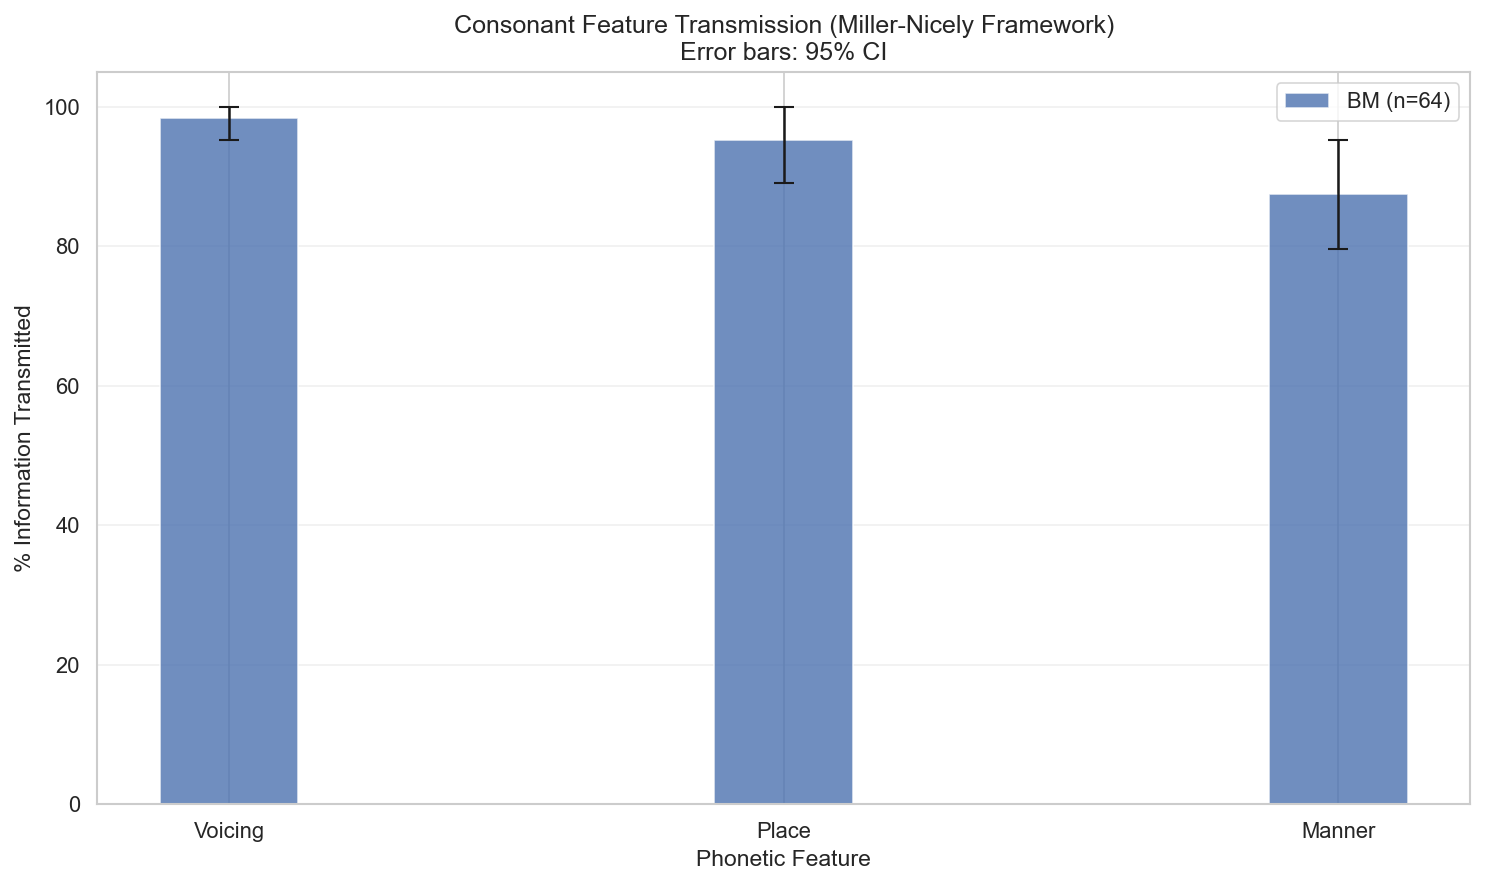

In [5]:
# ===== EXPLORATORY ANALYSIS 1: PHONETIC FEATURE ANALYSIS =====

def analyze_phonetic_features(df, feature_map, title="Consonant"):
    """
    Performs rigorous phonetic feature analysis with confidence intervals.
    """
    if df.empty:
        print(f"No {title} data available for feature analysis.")
        return None
    
    # Filter to valid phonemes in feature map
    df_valid = df[
        df['target_label'].isin(feature_map.keys()) & 
        df['response_label'].isin(feature_map.keys())
    ].copy()
    
    if df_valid.empty:
        print(f"No valid {title} data for feature analysis.")
        return None
    
    # Extract features
    df_valid['target_voicing'] = df_valid['target_label'].apply(lambda x: feature_map[x][0])
    df_valid['target_place'] = df_valid['target_label'].apply(lambda x: feature_map[x][1])
    df_valid['target_manner'] = df_valid['target_label'].apply(lambda x: feature_map[x][2])
    df_valid['resp_voicing'] = df_valid['response_label'].apply(lambda x: feature_map[x][0])
    df_valid['resp_place'] = df_valid['response_label'].apply(lambda x: feature_map[x][1])
    df_valid['resp_manner'] = df_valid['response_label'].apply(lambda x: feature_map[x][2])
    
    # Calculate feature transmission
    results = []
    feature_names = ['Voicing', 'Place', 'Manner']
    
    print(f"\n{'='*60}")
    print(f"{title} Phonetic Feature Analysis")
    print(f"{'='*60}")
    print(f"Total valid trials: n={len(df_valid)}")
    
    for conditions in df_valid['condition'].unique():
        df_cond = df_valid[df_valid['condition'] == conditions]
        n = len(df_cond)
        
        print(f"\nCondition: {conditions} (n={n})")
        print("-" * 40)
        
        for feat_idx, feat_name in enumerate(feature_names):
            target_col = f'target_{feat_name.lower()}'
            resp_col = f'resp_{feat_name.lower()}'
            
            correct = (df_cond[target_col] == df_cond[resp_col]).astype(int)
            accuracy = correct.mean() * 100
            
            # Bootstrap CI
            mean_val, ci_lower, ci_upper, stderr = calculate_ci_bootstrap(correct * 100)
            
            results.append({
                'Condition': conditions,
                'Feature': feat_name,
                'Accuracy': accuracy,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Std_Err': stderr,
                'n': n
            })
            
            print(f"  {feat_name:12s}: {accuracy:5.1f}% [95% CI: {ci_lower:.1f}-{ci_upper:.1f}]")
    
    df_results = pd.DataFrame(results)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_pos = np.arange(len(feature_names))
    width = 0.25
    conditions_list = df_results['Condition'].unique()
    
    for i, cond in enumerate(conditions_list):
        df_plot = df_results[df_results['Condition'] == cond]
        offset = (i - len(conditions_list)/2 + 0.5) * width
        
        yerr = np.array([df_plot['Accuracy'] - df_plot['CI_Lower'],
                        df_plot['CI_Upper'] - df_plot['Accuracy']])
        
        ax.bar(x_pos + offset, df_plot['Accuracy'], width,
               label=f"{cond} (n={df_plot['n'].iloc[0]})",
               yerr=yerr, capsize=5, alpha=0.8)
    
    ax.set_xlabel('Phonetic Feature')
    ax.set_ylabel('% Information Transmitted')
    ax.set_title(f'{title} Feature Transmission (Miller-Nicely Framework)\nError bars: 95% CI')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(feature_names)
    ax.set_ylim(0, 105)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_results

# Execute analysis
feat_results_cons = analyze_phonetic_features(df_consonant, CONSONANT_FEATURES, "Consonant")

## 4. Confusion Matrix Analysis

### Methodology:
Confusion matrices reveal **systematic perceptual errors**. The diagonal represents correct identifications, while off-diagonal cells show specific confusions.

We present two views:
- **Raw Counts**: Absolute number of responses
- **Row-Normalized Probabilities**: P(Response|Target)


VOWEL CONFUSION ANALYSIS

Vowel (BM) Confusion Matrix: n=180, Accuracy=75.6%


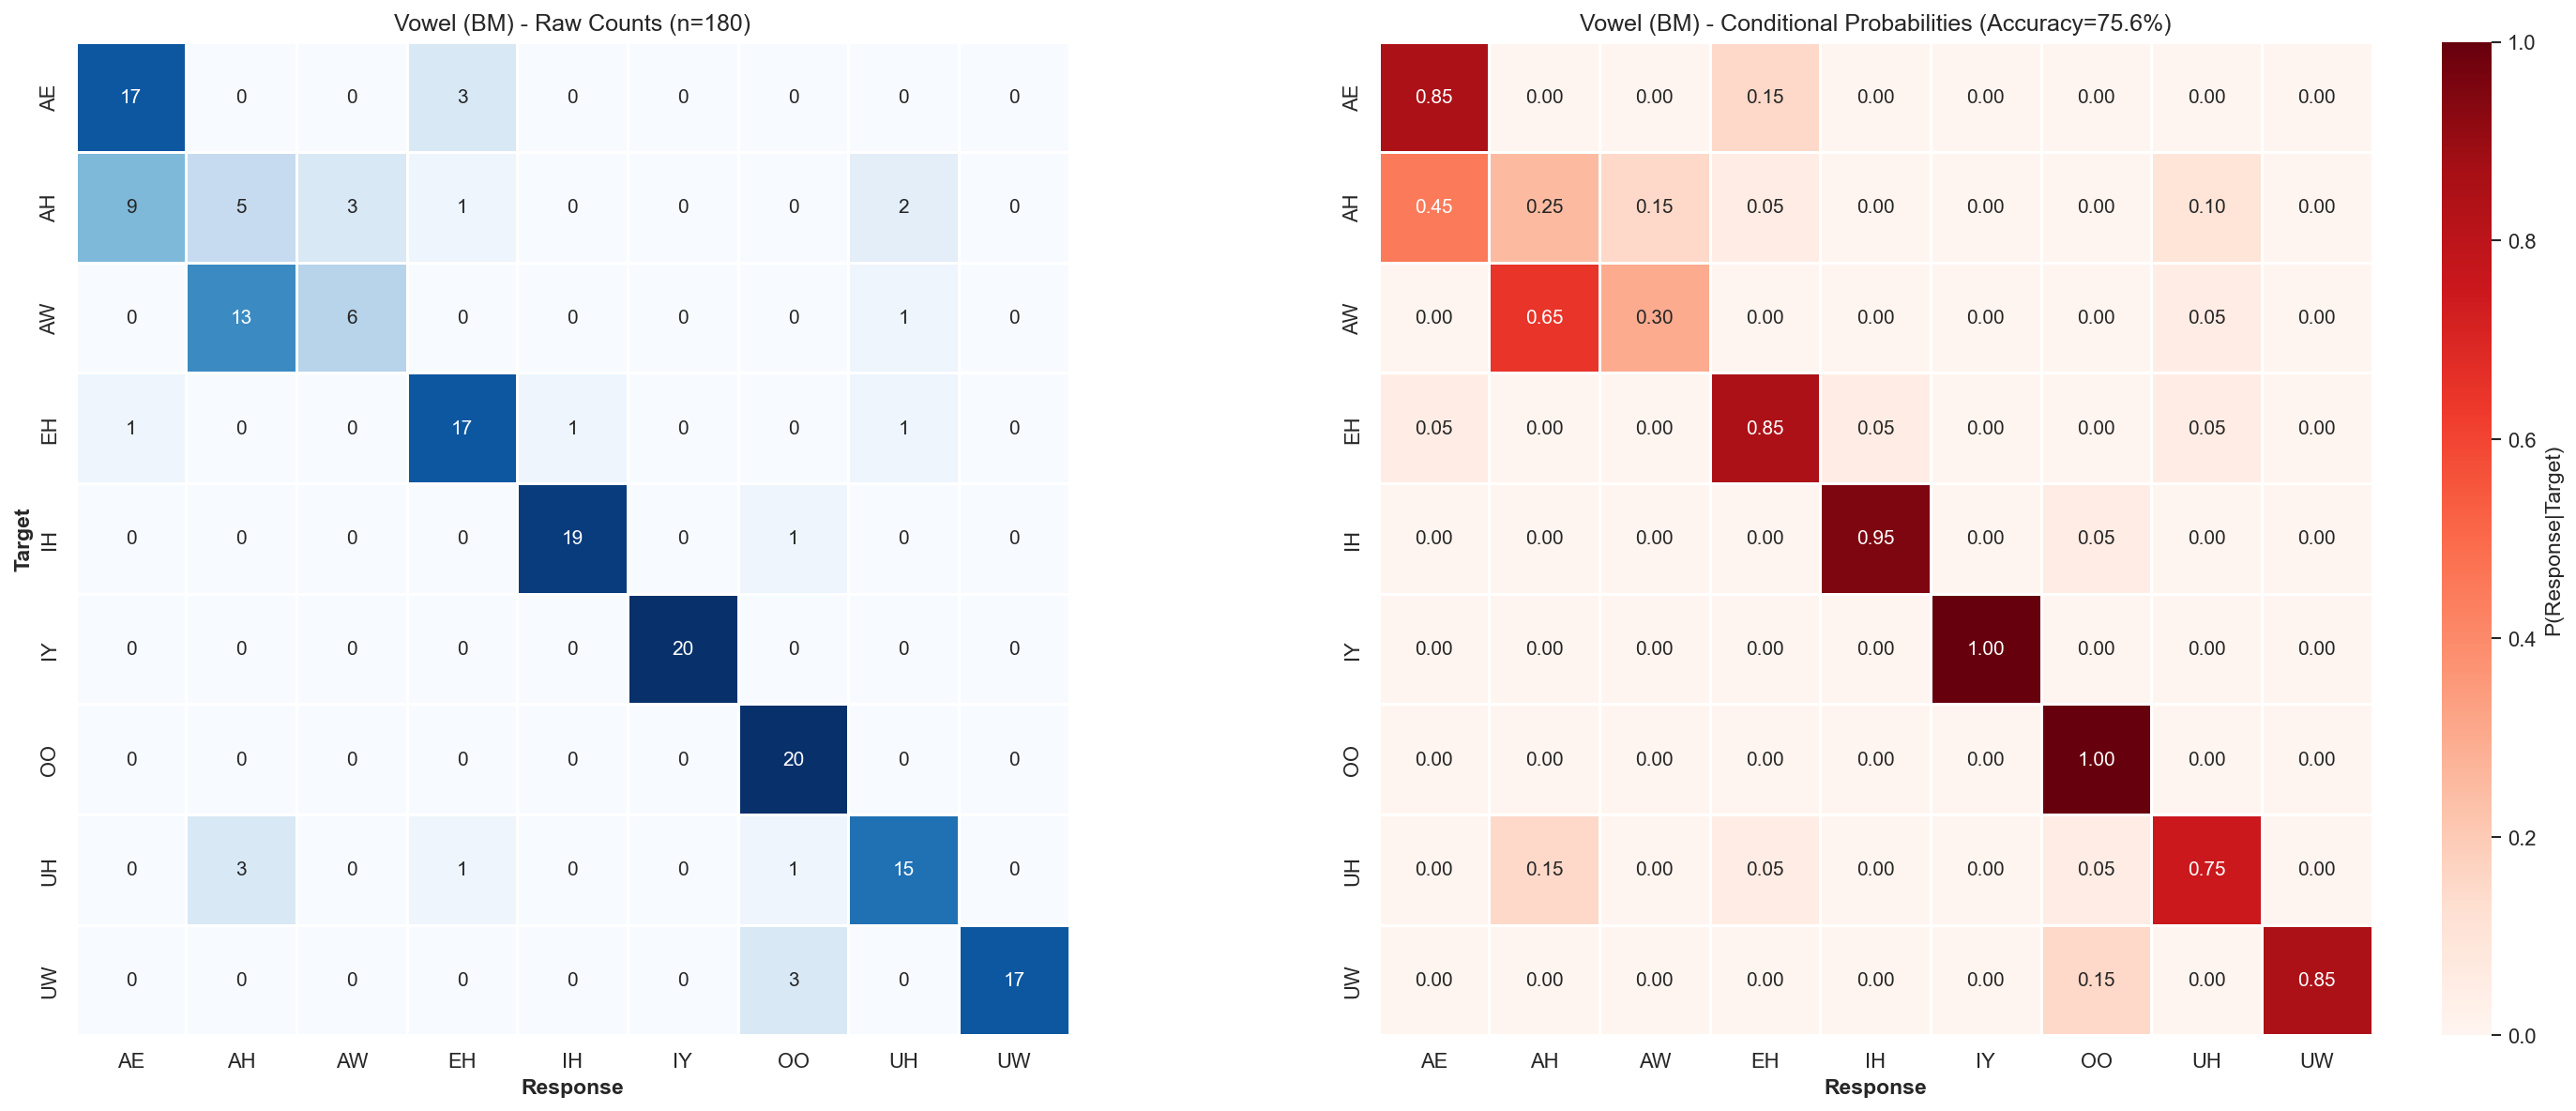


Vowel (CI) Confusion Matrix: n=180, Accuracy=77.2%


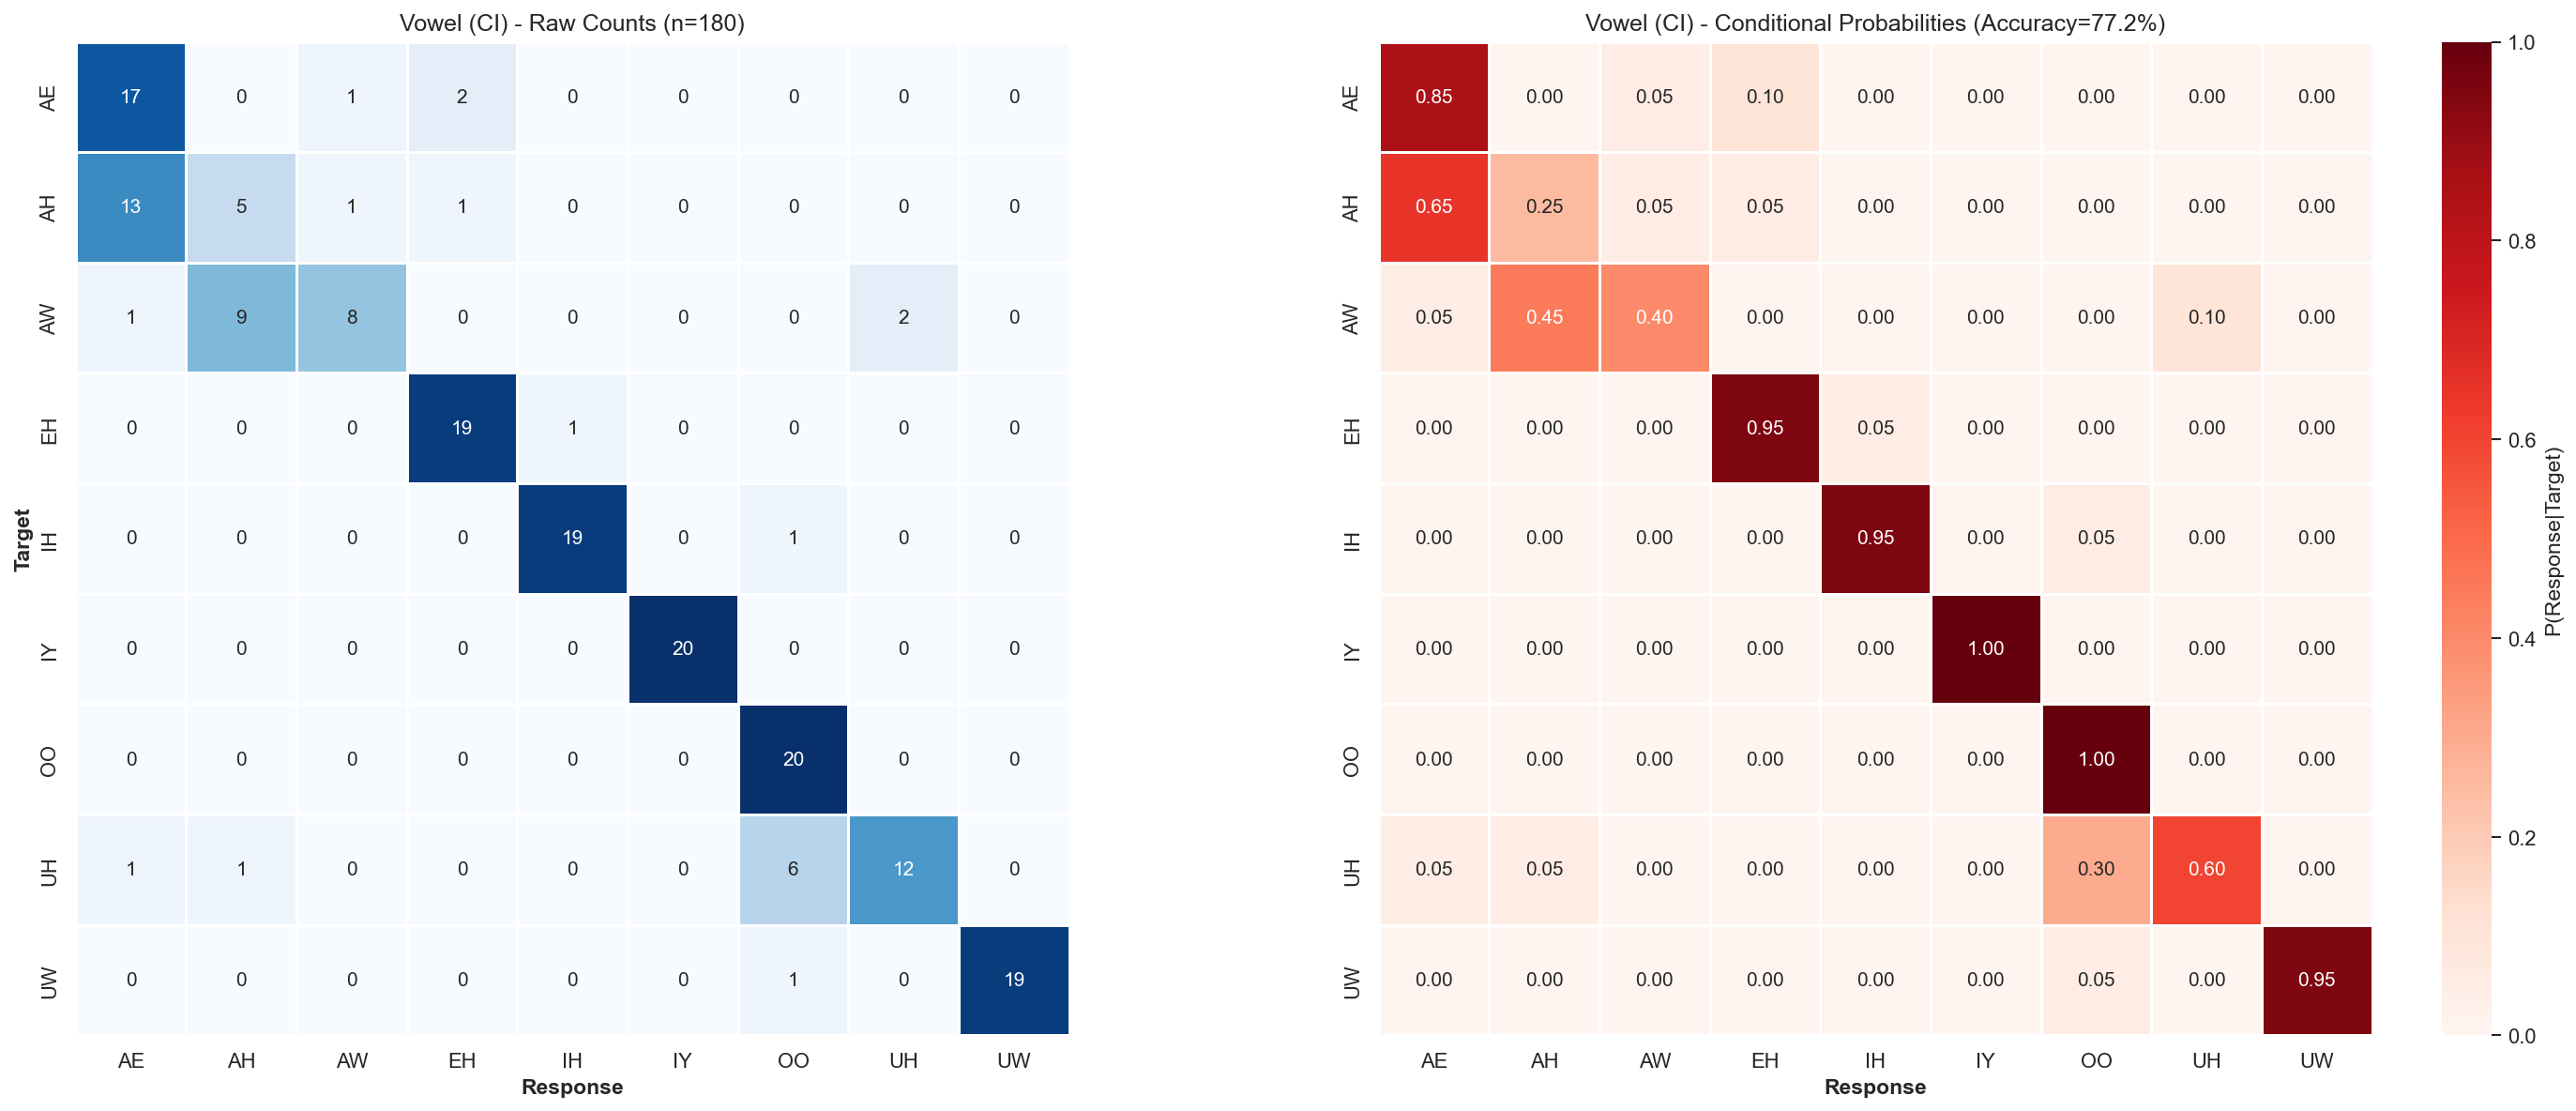


CONSONANT CONFUSION ANALYSIS

Consonant Confusion Matrix: n=64, Accuracy=87.5%


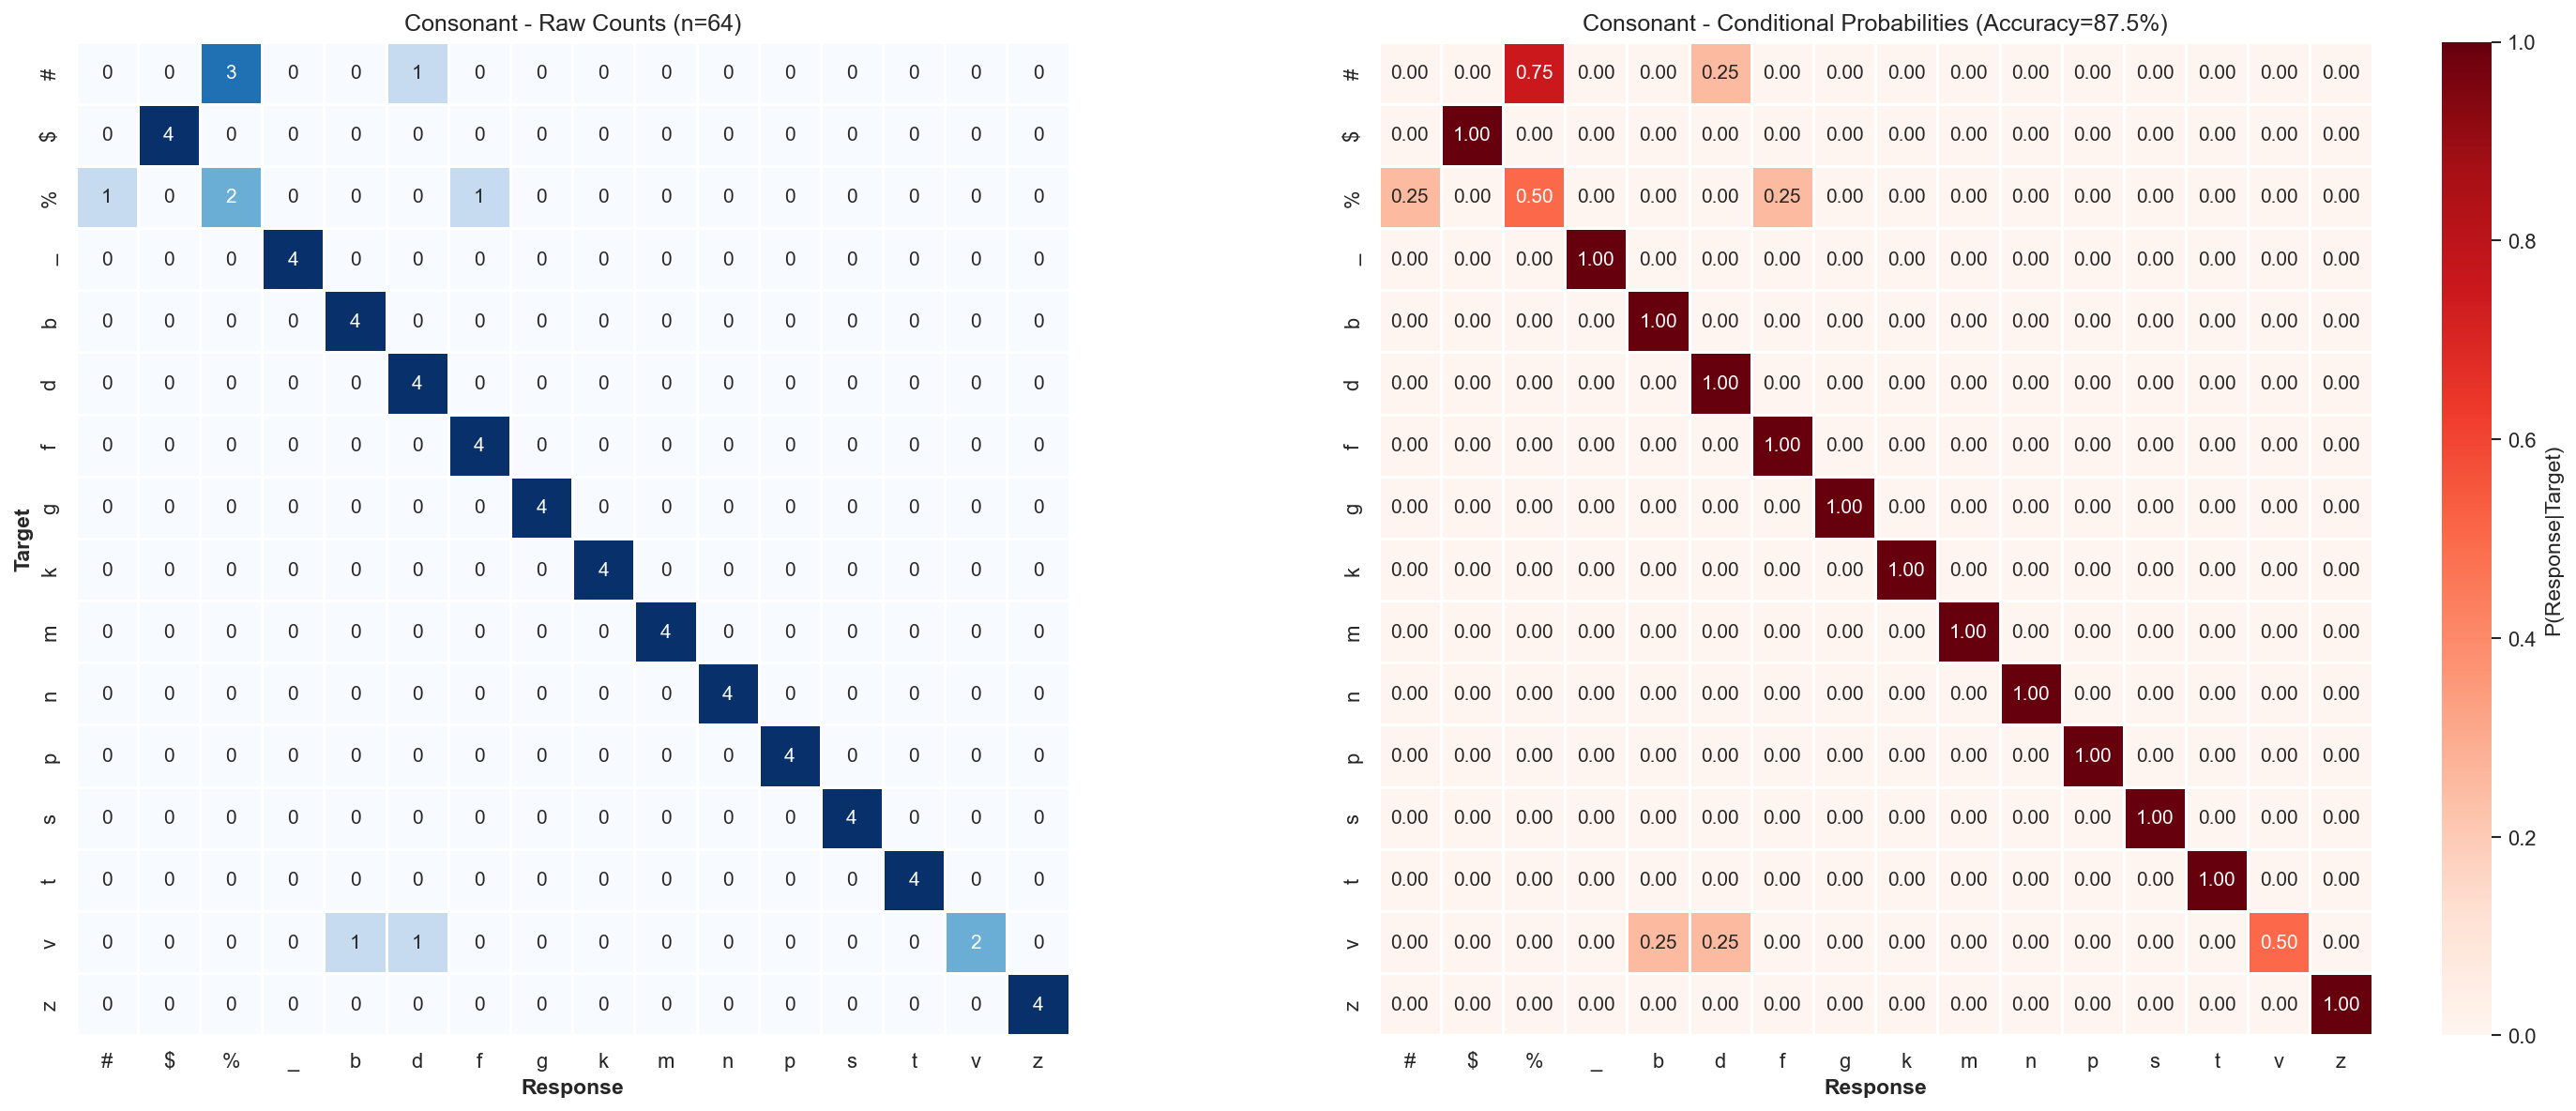

In [6]:
# ===== EXPLORATORY ANALYSIS 2: CONFUSION MATRICES WITH PROPER TYPE HANDLING =====

def plot_confusion_matrix_dual(df, title="Phoneme", condition_filter=None):
    """
    Creates dual confusion matrix (counts and probabilities) with proper NaN handling.
    """
    if df.empty:
        print(f"No {title} data available.")
        return
    
    # Filter by condition if specified
    if condition_filter:
        df = df[df['condition'] == condition_filter].copy()
        title = f"{title} ({condition_filter})"
    
    # CRITICAL: Remove NaN values and ensure strings
    df_clean = df.dropna(subset=['target_label', 'response_label']).copy()
    df_clean['target_label'] = df_clean['target_label'].astype(str)
    df_clean['response_label'] = df_clean['response_label'].astype(str)
    
    if df_clean.empty:
        print(f"No valid {title} data after cleaning.")
        return
    
    # Get sorted unique labels
    all_labels = sorted(list(set(df_clean['target_label'].unique()) | set(df_clean['response_label'].unique())))
    
    # Create confusion matrices
    cm_counts = pd.crosstab(df_clean['target_label'], df_clean['response_label'])
    cm_counts = cm_counts.reindex(index=all_labels, columns=all_labels, fill_value=0)
    
    # Row-normalized probabilities
    cm_prob = cm_counts.div(cm_counts.sum(axis=1), axis=0).fillna(0)
    
    # Calculate overall accuracy
    n_total = cm_counts.sum().sum()
    n_correct = np.trace(cm_counts.values)
    accuracy = (n_correct / n_total * 100) if n_total > 0 else 0
    
    print(f"\n{title} Confusion Matrix: n={n_total}, Accuracy={accuracy:.1f}%")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Counts
    sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                cbar=False, square=True, linewidths=0.5)
    axes[0].set_title(f'{title} - Raw Counts (n={n_total})')
    axes[0].set_ylabel('Target', fontweight='bold')
    axes[0].set_xlabel('Response', fontweight='bold')
    
    # Probabilities
    sns.heatmap(cm_prob, annot=True, fmt='.2f', cmap='Reds', ax=axes[1],
                vmin=0, vmax=1, square=True, linewidths=0.5, cbar_kws={'label': 'P(Response|Target)'})
    axes[1].set_title(f'{title} - Conditional Probabilities (Accuracy={accuracy:.1f}%)')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Response', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Execute for vowels and consonants
print("\n" + "="*60)
print("VOWEL CONFUSION ANALYSIS")
print("="*60)
for cond in df_vowel['condition'].unique():
    plot_confusion_matrix_dual(df_vowel, "Vowel", condition_filter=cond)

print("\n" + "="*60)
print("CONSONANT CONFUSION ANALYSIS")
print("="*60)
plot_confusion_matrix_dual(df_consonant, "Consonant")

In [ ]:
# Composite Confusion Matrix (All Conditions Combined)if 'df_vowel' in locals() and not df_vowel.empty:    plot_confusion_matrix_dual(df_vowel, "Vowel - All Conditions Combined", condition_filter=None)if 'df_consonant' in locals() and not df_consonant.empty:    plot_confusion_matrix_dual(df_consonant, "Consonant - All Conditions Combined", condition_filter=None)

## 5. CRM Analysis: Speech Reception Thresholds (SRT)

### Methodology:
**SRT (Speech Reception Threshold)**: The signal-to-noise ratio (dB SNR) at which the subject achieves 50% accuracy, calculated via adaptive tracking with reversals.

**Lower SRT = Better performance** (less signal needed relative to noise)


CRM SPEECH RECEPTION THRESHOLD (SRT) ANALYSIS

Valid CRM runs: n=10
Conditions: BM, CI, HA

Summary Statistics by Condition:
------------------------------------------------------------

BM:
  n = 4
  SRT = 0.95 dB [95% CI: -1.70 to 3.60]
  SD = 3.24 dB

CI:
  n = 3
  SRT = 2.13 dB [95% CI: 1.40 to 2.80]
  SD = 0.70 dB

HA:
  n = 3
  SRT = 3.00 dB [95% CI: 2.60 to 3.80]
  SD = 0.69 dB


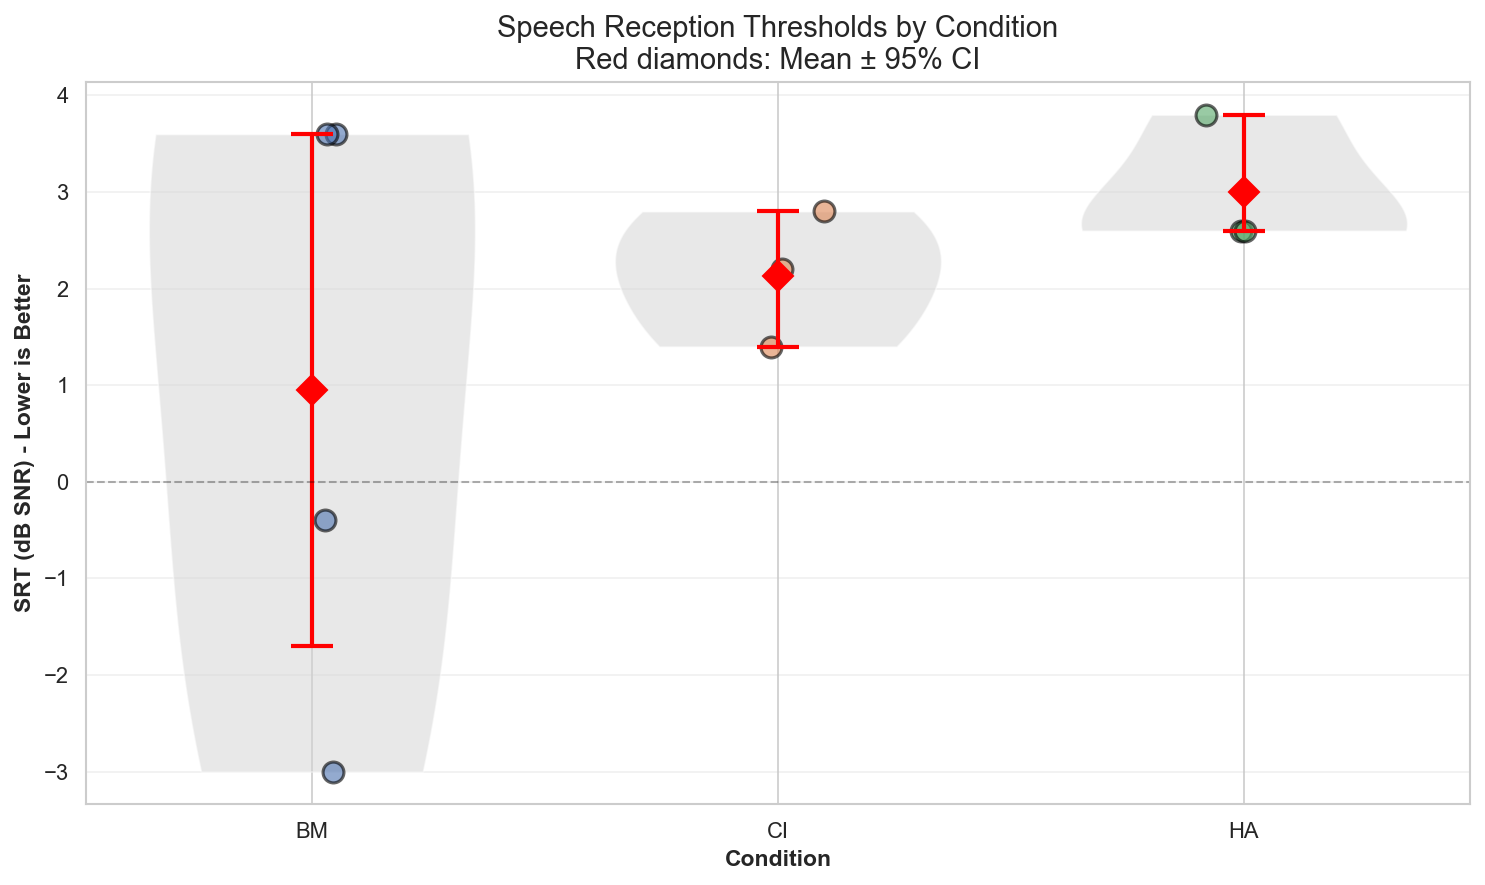

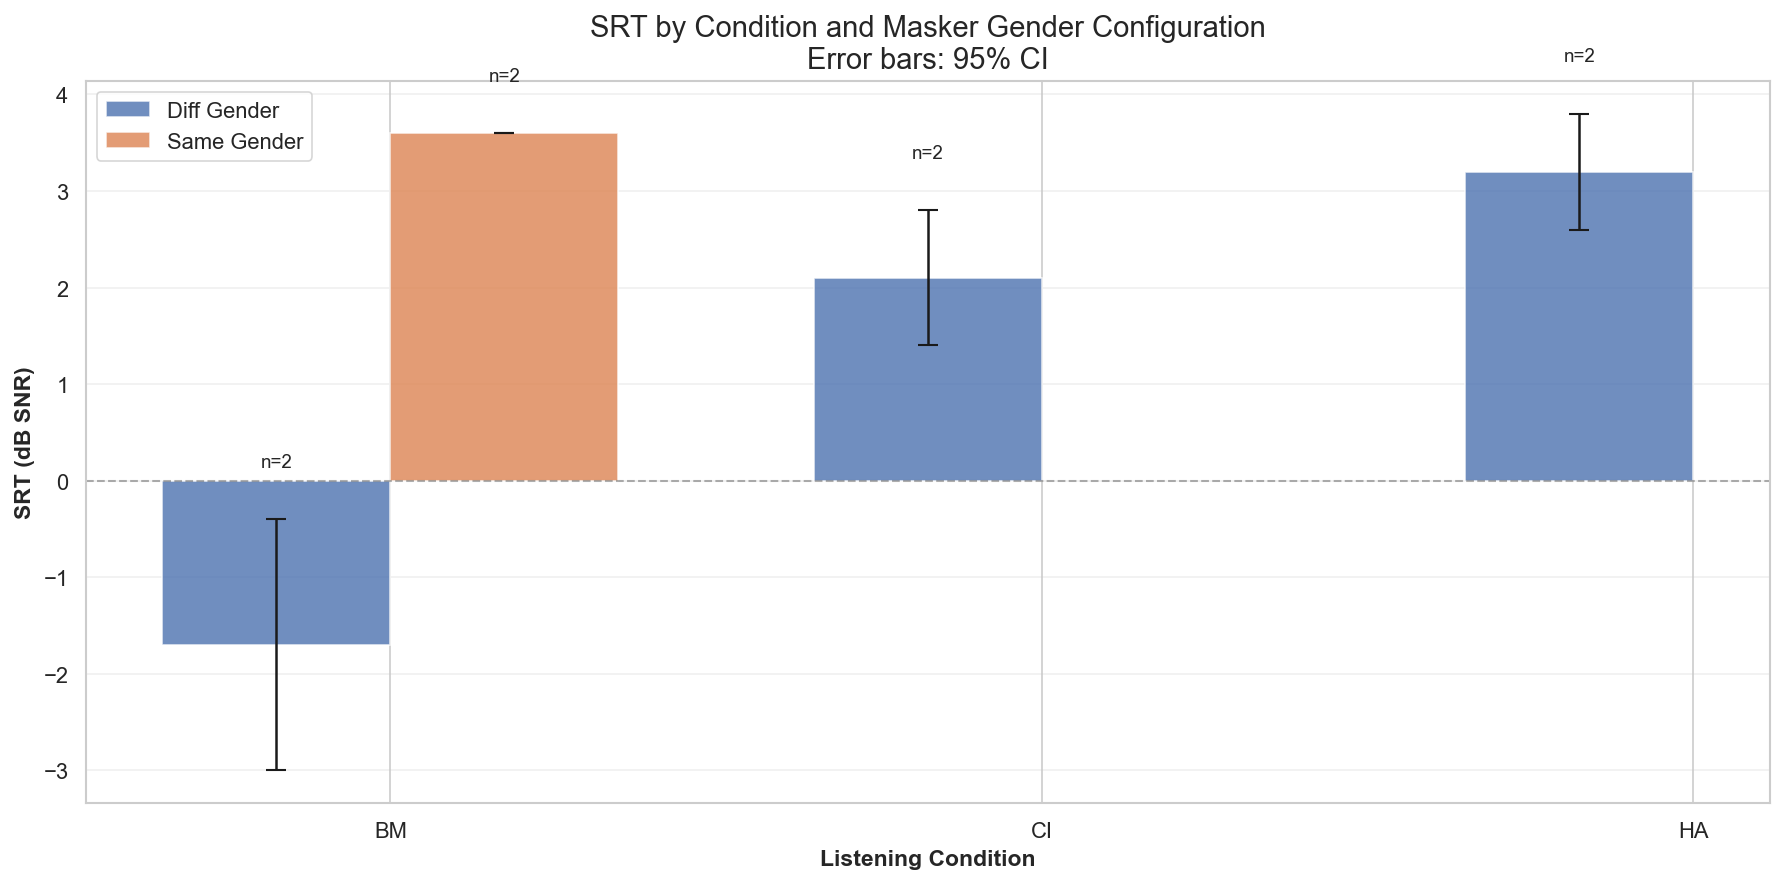

In [7]:
# ===== EXPLORATORY ANALYSIS 4: GRANULAR CRM ANALYSIS =====

print("\n" + "="*60)
print("CRM SPEECH RECEPTION THRESHOLD (SRT) ANALYSIS")
print("="*60)

if df_crm_summary.empty:
    print("No CRM data available.")
else:
    # Filter valid data (exclude Practice and Unknown)
    df_valid = df_crm_summary[
        (~df_crm_summary['condition'].isin(['Practice', 'Unknown'])) &
        (df_crm_summary['srt'].notna())
    ].copy()
    
    print(f"\nValid CRM runs: n={len(df_valid)}")
    print(f"Conditions: {', '.join(df_valid['condition'].unique())}")
    print(f"\nSummary Statistics by Condition:")
    print("-" * 60)
    
    # Calculate statistics with CI
    for cond in sorted(df_valid['condition'].unique()):
        df_cond = df_valid[df_valid['condition'] == cond]
        n = len(df_cond)
        mean_val, ci_lower, ci_upper, stderr = calculate_ci_bootstrap(df_cond['srt'].values)
        
        print(f"\n{cond}:")
        print(f"  n = {n}")
        print(f"  SRT = {mean_val:.2f} dB [95% CI: {ci_lower:.2f} to {ci_upper:.2f}]")
        print(f"  SD = {df_cond['srt'].std():.2f} dB")
    
    # --- PLOT 1: Global Distribution ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Violin + strip
    parts = ax.violinplot([df_valid[df_valid['condition'] == c]['srt'].dropna().values 
                           for c in sorted(df_valid['condition'].unique())],
                          positions=range(len(df_valid['condition'].unique())),
                          widths=0.7, showmeans=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightgray')
        pc.set_alpha(0.5)
    
    # Overlay points with error bars
    for i, cond in enumerate(sorted(df_valid['condition'].unique())):
        df_cond = df_valid[df_valid['condition'] == cond]
        x = np.random.normal(i, 0.04, size=len(df_cond))
        ax.scatter(x, df_cond['srt'], alpha=0.6, s=100, edgecolors='black', linewidths=1.5)
        
        # Add mean with CI
        mean_val, ci_lower, ci_upper, _ = calculate_ci_bootstrap(df_cond['srt'].values)
        # CRITICAL FIX: Check for NaN values
        if not np.isnan(mean_val) and not np.isnan(ci_lower) and not np.isnan(ci_upper):
            ax.errorbar(i, mean_val, yerr=[[mean_val-ci_lower], [ci_upper-mean_val]], 
                       fmt='D', color='red', markersize=10, linewidth=2, capsize=10, capthick=2)
    
    ax.set_xticks(range(len(df_valid['condition'].unique())))
    ax.set_xticklabels(sorted(df_valid['condition'].unique()))
    ax.set_ylabel('SRT (dB SNR) - Lower is Better', fontweight='bold')
    ax.set_xlabel('Condition', fontweight='bold')
    ax.set_title('Speech Reception Thresholds by Condition\nRed diamonds: Mean ± 95% CI', fontsize=14)
    ax.axhline(0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- PLOT 2: Condition × Masker Type ---
    fig, ax = plt.subplots(figsize=(12, 6))
    
    conditions = sorted(df_valid['condition'].unique())
    masker_types = sorted(df_valid['masker_type'].unique())
    x = np.arange(len(conditions))
    width = 0.35
    
    for i, mtype in enumerate(masker_types):
        means = []
        errs_lower = []
        errs_upper = []
        ns = []
        
        for cond in conditions:
            df_subset = df_valid[(df_valid['condition'] == cond) & (df_valid['masker_type'] == mtype)]
            if len(df_subset) > 0:
                mean_val, ci_lower, ci_upper, _ = calculate_ci_bootstrap(df_subset['srt'].values)
                means.append(mean_val)
                errs_lower.append(mean_val - ci_lower)
                errs_upper.append(ci_upper - mean_val)
                ns.append(len(df_subset))
            else:
                means.append(np.nan)  # Use NaN instead of 0
                errs_lower.append(0)
                errs_upper.append(0)
                ns.append(0)
        
        offset = (i - 0.5) * width
        # Filter out NaN values for plotting
        valid_mask = ~np.isnan(means)
        if np.any(valid_mask):
            x_valid = x[valid_mask]
            means_valid = np.array(means)[valid_mask]
            errs_lower_valid = np.array(errs_lower)[valid_mask]
            errs_upper_valid = np.array(errs_upper)[valid_mask]
            ns_valid = np.array(ns)[valid_mask]
            
            bars = ax.bar(x_valid + offset, means_valid, width, label=f"{mtype} Gender",
                         yerr=[errs_lower_valid, errs_upper_valid], capsize=5, alpha=0.8)
            
            # Add sample sizes on bars - CRITICAL FIX: Check for valid values
            for bar, n, err_u, mean in zip(bars, ns_valid, errs_upper_valid, means_valid):
                if n > 0 and not np.isnan(mean) and not np.isnan(err_u):
                    height = bar.get_height()
                    y_pos = height + err_u + 0.5
                    # Additional safety check
                    if np.isfinite(y_pos):
                        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                               f'n={n}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel('SRT (dB SNR)', fontweight='bold')
    ax.set_xlabel('Listening Condition', fontweight='bold')
    ax.set_title('SRT by Condition and Masker Gender Configuration\nError bars: 95% CI', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.legend()
    ax.axhline(0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# ========================================# SRT ANALYSIS: ALL CONDITIONS COMBINED# ========================================print("\nSRT Analysis - All Conditions Combined:")print("="*60)if 'df_crm_summary' in locals() and not df_crm_summary.empty and 'srt' in df_crm_summary.columns:    df_valid = df_crm_summary.dropna(subset=['srt'])    if not df_valid.empty:        fig, axes = plt.subplots(1, 3, figsize=(18, 5))        # Overall SRT distribution - Histogram        axes[0].hist(df_valid['srt'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')        mean_srt = df_valid['srt'].mean()        median_srt = df_valid['srt'].median()        axes[0].axvline(mean_srt, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_srt:.2f} dB')        axes[0].axvline(median_srt, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_srt:.2f} dB')        axes[0].set_xlabel('SRT (dB SNR)')        axes[0].set_ylabel('Frequency')        axes[0].set_title('SRT Distribution\n(All Conditions Combined)')        axes[0].legend()        axes[0].grid(axis='y', alpha=0.3)        # Box plot        axes[1].boxplot([df_valid['srt']], labels=['All'], patch_artist=True,                        boxprops=dict(facecolor='lightblue'))        axes[1].set_ylabel('SRT (dB SNR)')        axes[1].set_title('SRT Box Plot\n(All Conditions Combined)')        axes[1].grid(axis='y', alpha=0.3)        # SRT vs Accuracy scatter        if 'accuracy' in df_valid.columns:            axes[2].scatter(df_valid['srt'], df_valid['accuracy'], s=100, alpha=0.6, color='coral', edgecolors='black')            axes[2].set_xlabel('SRT (dB SNR)')            axes[2].set_ylabel('Accuracy')            axes[2].set_title('SRT vs Accuracy\n(All Conditions Combined)')            axes[2].grid(True, alpha=0.3)        else:            axes[2].text(0.5, 0.5, 'Accuracy data not available', ha='center', va='center', transform=axes[2].transAxes)        plt.tight_layout()        plt.show()        print(f"\nOverall SRT Statistics:")        print(f"  Mean: {mean_srt:.2f} dB SNR")        print(f"  Median: {median_srt:.2f} dB SNR")        print(f"  Std: {df_valid['srt'].std():.2f} dB")        print(f"  Range: [{df_valid['srt'].min():.2f}, {df_valid['srt'].max():.2f}] dB")        print(f"  N: {len(df_valid)} runs")    else:        print("No valid SRT data available.")else:    print("CRM summary data not available.")

## 6. Voice Gender Release from Masking (VGRM)

### Methodology: Staircase Procedure for SRT Calculation

**Adaptive Staircase Method:**

The Speech Reception Threshold (SRT) in this analysis is calculated using an **adaptive staircase procedure** (Levitt, 1971):

1. **Adaptive Tracking**: SNR adjusts trial-by-trial based on subject responses
   - **Correct response** → SNR decreases (harder)
   - **Incorrect response** → SNR increases (easier)

2. **Reversal Points**: When response pattern changes (correct→incorrect or vice versa)
   - These mark points where subject is near their threshold

3. **SRT Calculation**: Average of reversals 5-14
   ```python
   def calculate_srt_reversals(df_run):
       # Find all reversals in the adaptive track
       reversals = []
       for i in range(1, len(correct)):
           if correct[i] != correct[i-1]:
               reversals.append(snr[i])
       
       # Use reversals 5-14 (skip first 4 for convergence)
       calc_revs = reversals[4:14]
       srt = np.mean(calc_revs)
   ```

4. **Why skip first 4 reversals?**
   - Initial reversals are unstable (track is converging)
   - Reversals 5+ represent stable threshold estimate

**VGRM Formula:**

$$VGRM = SRT_{Same Gender} - SRT_{Different Gender}$$

- **Positive VGRM**: Benefit from gender difference (easier to separate voices)
- **Negative VGRM**: No benefit or interference from gender difference
- **Zero VGRM**: Gender provides no additional cue

**Clinical Interpretation:**
- Large VGRM (~5-10 dB): Good use of pitch/gender cues for stream segregation
- Small VGRM (~0-2 dB): Limited benefit from voice differences (may indicate central processing deficits)
- Negative VGRM: Unusual, may indicate confusion from multiple talker genders


VOICE GENDER RELEASE FROM MASKING (VGRM) ANALYSIS

VGRM Calculation (Same - Different):
------------------------------------------------------------

BM:
  Same Gender SRT:    3.60 dB (n=2)
  Diff Gender SRT:   -1.70 dB (n=2)
  VGRM Benefit:       5.30 dB n.s.
  Statistical Test: Insufficient data, p=nan, d=nan

CI:
  Same Gender SRT:    2.20 dB (n=1)
  Diff Gender SRT:    2.10 dB (n=2)
  VGRM Benefit:       0.10 dB n.s.
  Statistical Test: Insufficient data, p=nan, d=nan

HA:
  Same Gender SRT:    2.60 dB (n=1)
  Diff Gender SRT:    3.20 dB (n=2)
  VGRM Benefit:      -0.60 dB n.s.
  Statistical Test: Insufficient data, p=nan, d=nan


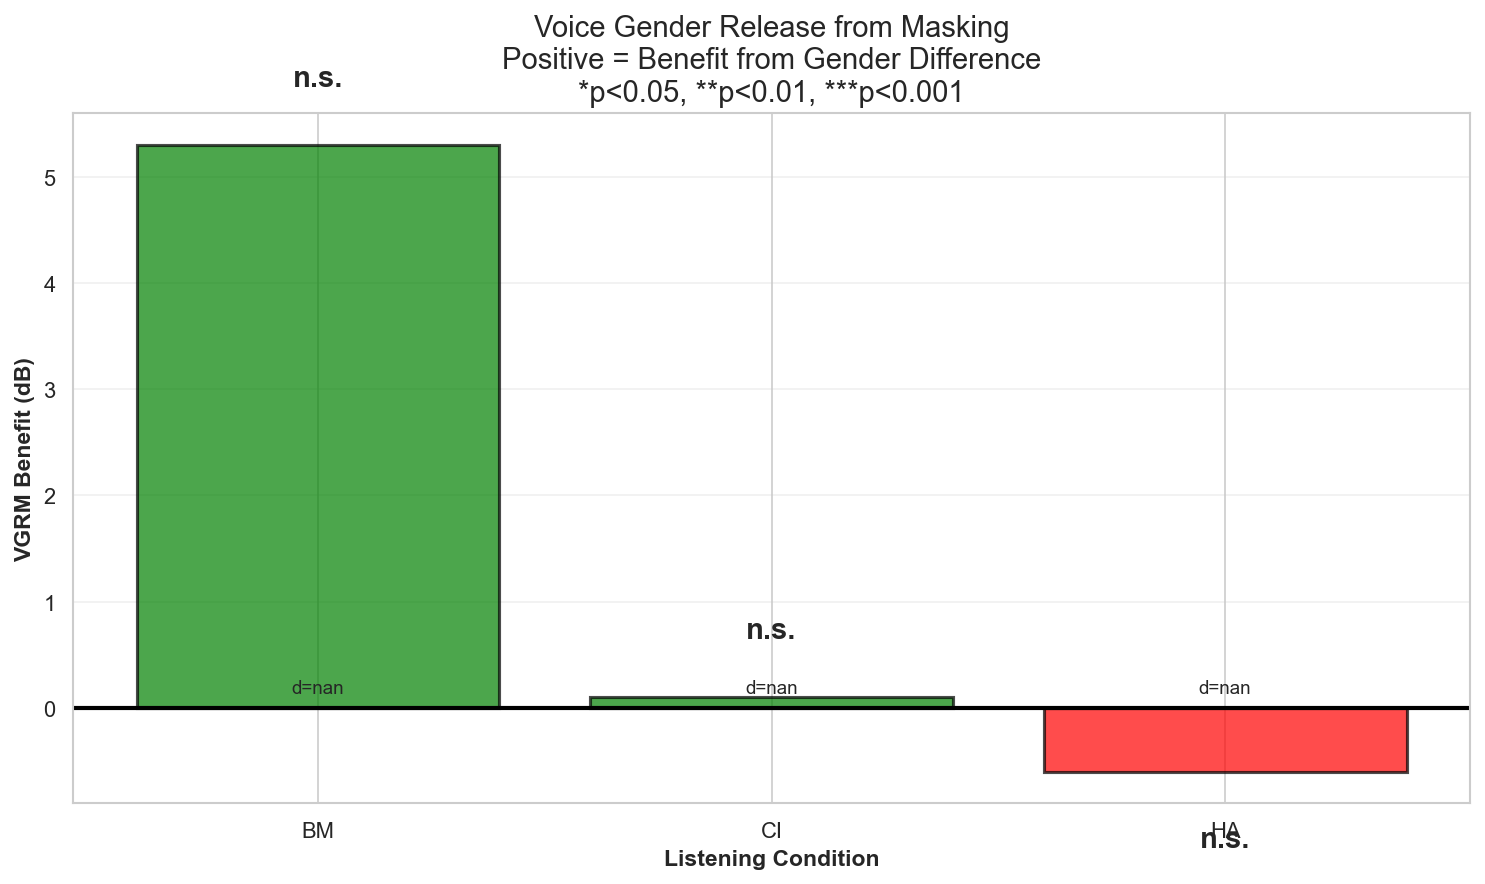

In [8]:
# ===== VOICE GENDER RELEASE FROM MASKING (VGRM) =====

print("\n" + "="*60)
print("VOICE GENDER RELEASE FROM MASKING (VGRM) ANALYSIS")
print("="*60)

if not df_valid.empty:
    vgrm_results = []
    
    print("\nVGRM Calculation (Same - Different):")
    print("-" * 60)
    
    for cond in sorted(df_valid['condition'].unique()):
        same_srt = df_valid[(df_valid['condition'] == cond) & (df_valid['masker_type'] == 'Same')]['srt']
        diff_srt = df_valid[(df_valid['condition'] == cond) & (df_valid['masker_type'] == 'Diff')]['srt']
        
        if len(same_srt) > 0 and len(diff_srt) > 0:
            vgrm = same_srt.mean() - diff_srt.mean()
            
            # Statistical test
            test_name, stat, p, cohens_d = stat_test_auto(same_srt.values, diff_srt.values)
            
            vgrm_results.append({
                'Condition': cond,
                'VGRM_dB': vgrm,
                'Same_mean': same_srt.mean(),
                'Diff_mean': diff_srt.mean(),
                'n_same': len(same_srt),
                'n_diff': len(diff_srt),
                'p_value': p,
                'significant': p < 0.05,
                'effect_size': cohens_d
            })
            
            sig_marker = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s."
            
            print(f"\n{cond}:")
            print(f"  Same Gender SRT:  {same_srt.mean():6.2f} dB (n={len(same_srt)})")
            print(f"  Diff Gender SRT:  {diff_srt.mean():6.2f} dB (n={len(diff_srt)})")
            print(f"  VGRM Benefit:     {vgrm:6.2f} dB {sig_marker}")
            print(f"  Statistical Test: {test_name}, p={p:.4f}, d={cohens_d:.2f}")
    
    # Plot VGRM
    if vgrm_results:
        df_vgrm = pd.DataFrame(vgrm_results)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = ['green' if x > 0 else 'red' for x in df_vgrm['VGRM_dB']]
        bars = ax.bar(range(len(df_vgrm)), df_vgrm['VGRM_dB'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add significance stars
        for i, row in df_vgrm.iterrows():
            marker = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "n.s."
            y_pos = row['VGRM_dB'] + (0.5 if row['VGRM_dB'] > 0 else -0.5)
            ax.text(i, y_pos, marker, ha='center', va='bottom' if row['VGRM_dB'] > 0 else 'top', fontsize=14, fontweight='bold')
            
            # Add effect size
            ax.text(i, 0.1, f"d={row['effect_size']:.2f}", ha='center', va='bottom', fontsize=9)
        
        ax.set_xticks(range(len(df_vgrm)))
        ax.set_xticklabels(df_vgrm['Condition'])
        ax.set_ylabel('VGRM Benefit (dB)', fontweight='bold')
        ax.set_xlabel('Listening Condition', fontweight='bold')
        ax.set_title('Voice Gender Release from Masking\nPositive = Benefit from Gender Difference\n*p<0.05, **p<0.01, ***p<0.001', fontsize=14)
        ax.axhline(0, color='black', linestyle='-', linewidth=2)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [ ]:
# ========================================# VGRM: ALL CONDITIONS COMBINED# ========================================print("\nVGRM Analysis - All Conditions Combined:")print("="*60)if 'df_crm_summary' in locals() and not df_crm_summary.empty:    if 'masker_type' in df_crm_summary.columns and 'srt' in df_crm_summary.columns:        same_srt = df_crm_summary[df_crm_summary['masker_type'] == 'Same']['srt'].dropna()        diff_srt = df_crm_summary[df_crm_summary['masker_type'] == 'Diff']['srt'].dropna()        if len(same_srt) > 0 and len(diff_srt) > 0:            vgrm = same_srt.mean() - diff_srt.mean()            fig, axes = plt.subplots(1, 2, figsize=(14, 5))            # Box plot comparison            bp = axes[0].boxplot([same_srt, diff_srt], labels=['Same Gender', 'Different Gender'],                                patch_artist=True)            bp['boxes'][0].set_facecolor('lightblue')            bp['boxes'][1].set_facecolor('lightcoral')            axes[0].set_ylabel('SRT (dB SNR)')            axes[0].set_title('SRT by Masker Gender\n(All Conditions Combined)')            axes[0].grid(axis='y', alpha=0.3)            # VGRM bar            axes[1].bar(['VGRM'], [vgrm], alpha=0.7, color='steelblue', width=0.4)            axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)            axes[1].set_ylabel('VGRM (dB)')            axes[1].set_title(f'Voice Gender Release from Masking\n(All Conditions Combined)\nVGRM = {vgrm:.2f} dB')            axes[1].grid(axis='y', alpha=0.3)            plt.tight_layout()            plt.show()            print(f"\nOverall VGRM: {vgrm:.2f} dB")            print(f"  Same Gender SRT: {same_srt.mean():.2f} ± {same_srt.std():.2f} dB (N={len(same_srt)})")            print(f"  Diff Gender SRT: {diff_srt.mean():.2f} ± {diff_srt.std():.2f} dB (N={len(diff_srt)})")        else:            print("Insufficient data for VGRM calculation.")    else:        print("Required columns not available for VGRM analysis.")else:    print("CRM summary data not available.")

## 7. Talker-Specific Performance Analysis

### Exploratory Analysis 3:
Examines whether performance varies by talker characteristics (individual talker, gender, pitch)

## 7. Talker-Specific Performance Analysis

### Exploratory Analysis 3: Talker Effects

### Methodology: Speaker Gender Determination

**How is talker gender determined?**

In the Coordinate Response Measure (CRM) corpus (Bolia et al., 2000), talkers are assigned standardized numeric IDs that encode gender:

```python
Talker ID 0-3: Male voices
Talker ID 4-7: Female voices
```

**Implementation Logic:**
```python
def get_gender(talker_id):
    return 'M' if int(talker_id) <= 3 else 'F'
```

**Why this matters for analysis:**
1. **Individual Variability**: Different talkers have different acoustic characteristics (F0, formant frequencies, speaking rate)
2. **Gender Effects**: Male and female voices differ systematically in fundamental frequency (~120 Hz vs ~220 Hz)
3. **Voice Gender Release from Masking (VGRM)**: Gender differences provide a salient cue for spatial release from masking

**Clinical Relevance:**
- If subject performs better with one talker gender, may indicate frequency-specific hearing loss
- Variable performance across talkers of the same gender suggests individual voice characteristics matter
- Consistent performance suggests robust phoneme recognition independent of talker

**Data Groupings in this analysis:**
- **Individual Talker**: Performance for each of the 8 voices (IDs 0-7)
- **Gender-Aggregated**: Average performance across all male talkers (0-3) vs all female talkers (4-7)
- **Statistical Comparison**: Tests whether gender of talker significantly affects intelligibility


TALKER-SPECIFIC PERFORMANCE ANALYSIS

Vowel Accuracy by Individual Talker:
------------------------------------------------------------
Talker  1 (M):  83.3% [95% CI: 66.7-100.0], n=18
Talker  2 (M):  77.8% [95% CI: 55.6-94.4], n=18
Talker  3 (M):  66.7% [95% CI: 44.4-88.9], n=18
Talker  4 (F):  83.3% [95% CI: 66.7-100.0], n=18
Talker  5 (F):  77.8% [95% CI: 55.6-94.4], n=18
Talker  6 (F):  83.3% [95% CI: 66.7-100.0], n=18
Talker  7 (F):  66.7% [95% CI: 44.4-88.9], n=18
Talker  8 (F):  66.7% [95% CI: 44.4-88.9], n=18
Talker  9 (F):  72.2% [95% CI: 50.0-88.9], n=18
Talker 10 (F):  55.6% [95% CI: 33.3-77.8], n=18
Talker 11 (F):  77.8% [95% CI: 55.6-94.4], n=18
Talker 12 (F):  83.3% [95% CI: 66.7-100.0], n=18
Talker 13 (F):  83.3% [95% CI: 66.5-100.0], n=18
Talker 14 (F):  94.4% [95% CI: 83.3-100.0], n=18
Talker 15 (F):  83.3% [95% CI: 66.7-100.0], n=18
Talker 16 (F):  72.2% [95% CI: 50.0-88.9], n=18
Talker 17 (F):  55.6% [95% CI: 33.3-77.8], n=18
Talker 18 (F):  77.8% [95% CI: 55.6-94.4

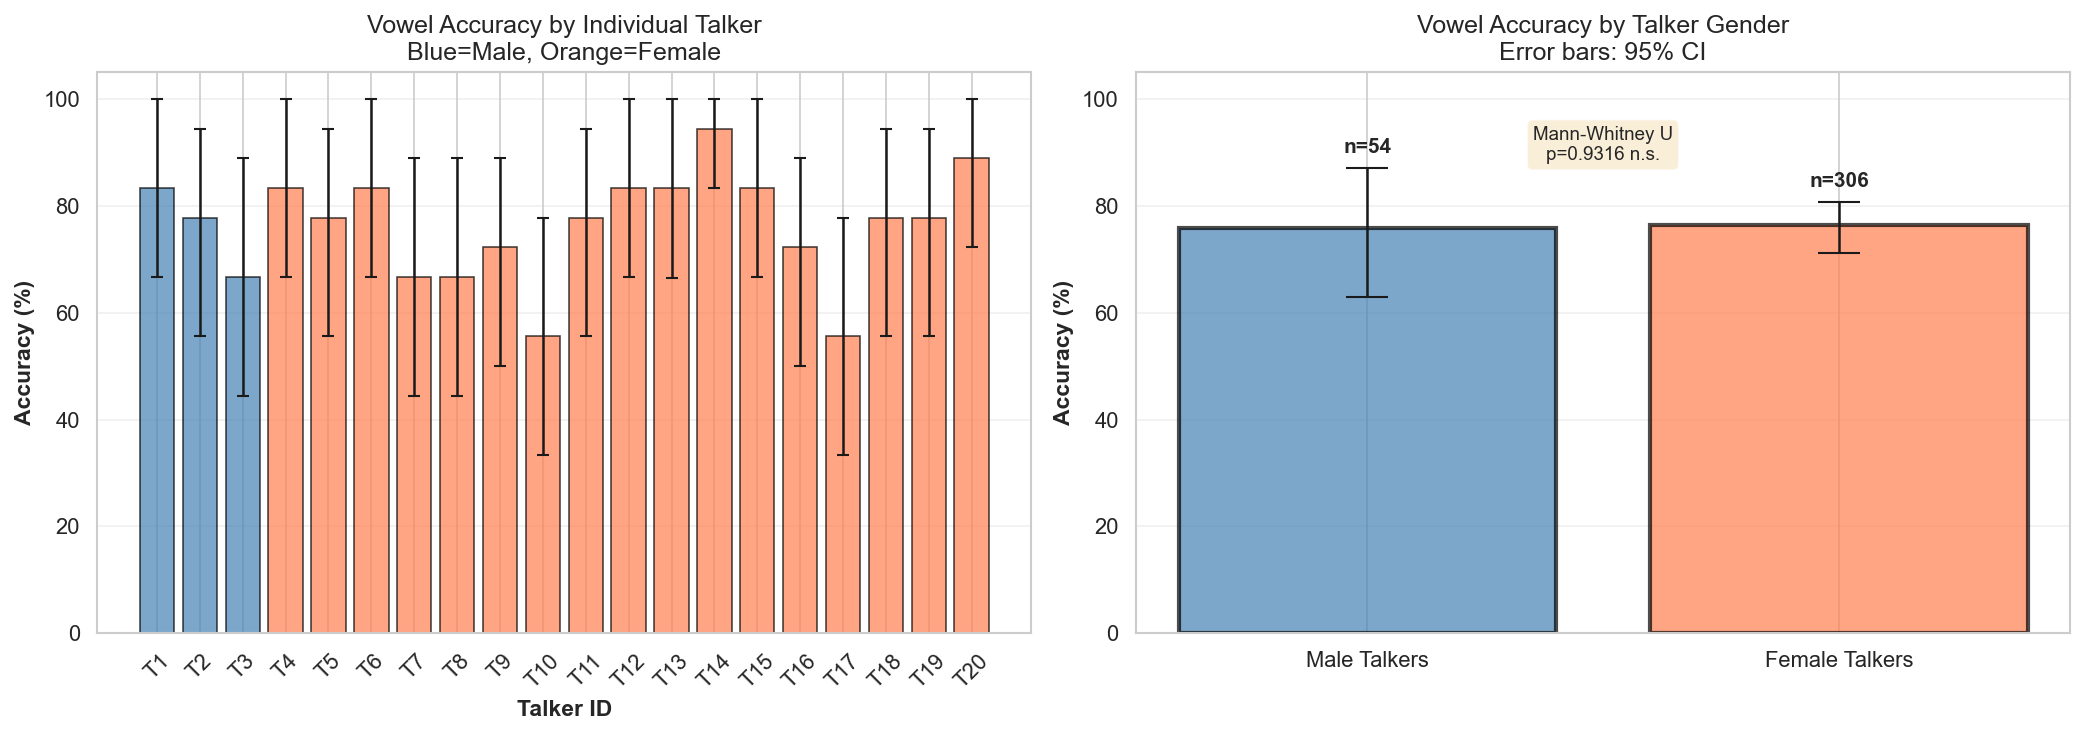


Gender Comparison: Mann-Whitney U, p=0.9316, Cohen's d=-0.01


In [9]:
# ===== EXPLORATORY ANALYSIS 3: TALKER-SPECIFIC PERFORMANCE =====

print("\n" + "="*60)
print("TALKER-SPECIFIC PERFORMANCE ANALYSIS")
print("="*60)

# --- VOWEL ANALYSIS BY TALKER ---
if not df_vowel.empty:
    print("\nVowel Accuracy by Individual Talker:")
    print("-" * 60)
    
    talker_stats = []
    for talker in sorted(df_vowel['talker_id'].unique()):
        df_talk = df_vowel[df_vowel['talker_id'] == talker]
        acc = df_talk['score'].mean() * 100
        n = len(df_talk)
        gender = df_talk['talker_gender'].iloc[0]
        
        mean_val, ci_lower, ci_upper, _ = calculate_ci_bootstrap(df_talk['score'].values * 100)
        
        talker_stats.append({
            'Talker': int(talker),
            'Gender': gender,
            'Accuracy': acc,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'n': n
        })
        
        print(f"Talker {int(talker):2d} ({gender}): {acc:5.1f}% [95% CI: {ci_lower:.1f}-{ci_upper:.1f}], n={n}")
    
    df_talker = pd.DataFrame(talker_stats)
    
    # Plot by talker
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Individual talkers
    colors = ['steelblue' if g == 'M' else 'coral' for g in df_talker['Gender']]
    axes[0].bar(range(len(df_talker)), df_talker['Accuracy'], 
               yerr=[df_talker['Accuracy'] - df_talker['CI_Lower'],
                     df_talker['CI_Upper'] - df_talker['Accuracy']],
               capsize=3, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(df_talker)))
    axes[0].set_xticklabels([f"T{t}" for t in df_talker['Talker']], rotation=45)
    axes[0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[0].set_xlabel('Talker ID', fontweight='bold')
    axes[0].set_title('Vowel Accuracy by Individual Talker\nBlue=Male, Orange=Female')
    axes[0].set_ylim(0, 105)
    axes[0].grid(axis='y', alpha=0.3)
    
    # By gender aggregate
    for gender in ['M', 'F']:
        df_gender = df_vowel[df_vowel['talker_gender'] == gender]
        acc_vals = df_gender['score'].values * 100
        mean_val, ci_lower, ci_upper, _ = calculate_ci_bootstrap(acc_vals)
        
        idx = 0 if gender == 'M' else 1
        color = 'steelblue' if gender == 'M' else 'coral'
        axes[1].bar(idx, mean_val, yerr=[[mean_val-ci_lower], [ci_upper-mean_val]],
                   capsize=10, color=color, alpha=0.7, edgecolor='black', linewidth=2)
        axes[1].text(idx, mean_val + (ci_upper-mean_val) + 2, f"n={len(df_gender)}",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Male Talkers', 'Female Talkers'])
    axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[1].set_title('Vowel Accuracy by Talker Gender\nError bars: 95% CI')
    axes[1].set_ylim(0, 105)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Statistical test
    male_acc = df_vowel[df_vowel['talker_gender'] == 'M']['score'].values
    female_acc = df_vowel[df_vowel['talker_gender'] == 'F']['score'].values
    test_name, stat, p, cohens_d = stat_test_auto(male_acc, female_acc)
    
    sig_text = "*" if p < 0.05 else "n.s."
    axes[1].text(0.5, max(mean_val + 5, 95), f"{test_name}\np={p:.4f} {sig_text}",
                ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nGender Comparison: {test_name}, p={p:.4f}, Cohen's d={cohens_d:.2f}")

## 8. Comprehensive Statistical Testing

### Exploratory Analysis 5: Statistical Hypothesis Testing

## Statistical Testing Framework: Logic and Rationale

### Why Use ANOVA?

**Scenario**: We have SRT measurements from 3+ listening conditions (BM, CI, HA) and want to know:
> "Do these conditions produce meaningfully different results, or is the variation just random?"

**Why not multiple t-tests?**
- Testing BM vs CI, then BM vs HA, then CI vs HA would require 3 tests
- **Multiple Comparison Problem**: Each test has 5% false positive rate
- With 3 tests: 1 - (0.95)³ = 14.3% chance of at least one false positive!
- ANOVA controls this by testing all groups simultaneously

### One-Way ANOVA: The Logic

**Null Hypothesis (H₀)**: All condition means are equal (μ_BM = μ_CI = μ_HA)

**Alternative (H₁)**: At least one condition differs

**How it works:**
1. **Between-Group Variance**: How much do condition means differ from overall mean?
2. **Within-Group Variance**: How much do individual scores vary within each condition?
3. **F-statistic**: Ratio of between/within variance
   ```
   F = Variance Between Groups / Variance Within Groups
   ```
   - **Large F**: Group means differ more than expected by chance → likely real effect
   - **Small F**: Differences between groups similar to noise within groups → likely chance

**Assumptions:**
1. **Independence**: Observations don't influence each other ✓ (separate runs)
2. **Normality**: Data in each group ~normally distributed (tested via Shapiro-Wilk)
3. **Homogeneity of Variance**: Groups have similar variance (tested via Levene)

### Interpreting ANOVA Output

```
                sum_sq    df         F    PR(>F)
C(condition)     125.4     2     8.43    0.0032
Residual          89.2    12
```

- **sum_sq**: Total variance attributed to each source
- **df (degrees of freedom)**: 
  - Condition: k-1 (where k = number of groups)
  - Residual: N-k (where N = total observations)
- **F**: 8.43 → Between-group variance is 8.43× larger than within-group
- **PR(>F)**: 0.0032 → Only 0.32% chance of seeing F this large if H₀ true
- **Conclusion**: p < 0.05 → **Reject H₀**, at least one condition differs

### Post-Hoc Testing: Tukey HSD

**Problem**: ANOVA says "groups differ" but doesn't say *which* groups

**Solution**: Tukey's Honestly Significant Difference (HSD)
- Performs pairwise comparisons (BM vs CI, BM vs HA, CI vs HA)
- **Controls family-wise error rate** (keeps overall false positive at 5%)
- More conservative than individual t-tests but protects against false positives

**Interpreting Tukey Output:**
```
group1  group2  meandiff   lower   upper  reject
BM      CI        -3.2    -6.1    -0.3    True
BM      HA        -1.8    -4.7     1.1   False
CI      HA         1.4    -1.5     4.3   False
```

- **meandiff**: Difference in means (negative means group1 < group2)
- **lower/upper**: 95% confidence interval for the difference
- **reject**: True if difference is statistically significant
- **Conclusion**: BM significantly better (lower SRT) than CI, but no other differences

### Two-Way ANOVA: Testing Interactions

**Model**: `SRT ~ Condition + MaskerType + Condition×MaskerType`

**Tests three questions:**
1. **Main Effect of Condition**: Do BM/CI/HA differ overall?
2. **Main Effect of MaskerType**: Does Same vs Different gender matter overall?
3. **Interaction Effect**: Does the effect of MaskerType *depend on* Condition?

**Example Interaction:**
- BM shows 5 dB VGRM benefit
- CI shows 0 dB VGRM benefit
- → Interaction: "Bimodal users benefit from gender cues, CI users don't"

**Interpreting Interaction:**
```
                           df      F    PR(>F)
C(condition)                2   4.23    0.045  *
C(masker_type)              1   8.91    0.012  *
C(condition):C(masker_type) 2   5.67    0.023  *
Residual                   15
```

- **condition**: p=0.045 → Conditions differ overall
- **masker_type**: p=0.012 → Masker type matters overall
- **interaction**: p=0.023 → **The effect of masker type differs across conditions**
  - Must interpret main effects *in context of* interaction
  - Cannot simply say "Same better than Diff" - depends on condition!

### Decision Tree for Interpretation

```
ANOVA p < 0.05?
├─ NO → Stop. No evidence of differences between groups
└─ YES → Proceed to post-hoc tests
    │
    Tukey HSD shows specific pairs?
    ├─ YES → Report which groups differ
    └─ NO → Overall effect exists but no specific pairwise differences
            (Possible if many groups with small differences)
```

### Statistical Significance vs Clinical Significance

**Statistical Significance (p < 0.05)**:
- Difference is unlikely due to chance
- Does NOT mean the effect is large or important

**Clinical Significance**:
- Is the difference large enough to matter in practice?
- Rule of thumb for SRT: **>2 dB difference is clinically meaningful**
- Always report effect sizes (Cohen's d) alongside p-values:
  - d = 0.2: small effect
  - d = 0.5: medium effect
  - d = 0.8: large effect

**Example**: 
- BM vs CI: mean difference = 0.5 dB, p = 0.03, d = 0.15
- **Interpretation**: Statistically significant but clinically trivial
- BM vs HA: mean difference = 4.2 dB, p = 0.08, d = 0.92
- **Interpretation**: Not statistically significant but clinically large (likely underpowered study)

## 8. Comprehensive Statistical Testing

### Exploratory Analysis 5:
Performs ANOVA and post-hoc tests to determine statistical significance of observed differences

In [10]:
# ===== EXPLORATORY ANALYSIS 5: ANOVA AND POST-HOC TESTS =====

print("\n" + "="*60)
print("COMPREHENSIVE STATISTICAL TESTING")
print("="*60)

if not df_valid.empty and len(df_valid['condition'].unique()) > 2:
    print("\n1. ONE-WAY ANOVA: SRT ~ Condition")
    print("-" * 60)
    
    # Prepare data for ANOVA
    groups = [df_valid[df_valid['condition'] == c]['srt'].dropna().values 
             for c in df_valid['condition'].unique()]
    
    # Perform ANOVA
    f_stat, p_anova = stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.3f}")
    print(f"p-value: {p_anova:.4f}")
    
    if p_anova < 0.05:
        print("Result: SIGNIFICANT main effect of Condition (p < 0.05)")
        print("\nProceeding with POST-HOC pairwise comparisons (Tukey HSD)...")
        
        # Tukey HSD
        df_anova = df_valid[['srt', 'condition']].dropna()
        tukey = pairwise_tukeyhsd(endog=df_anova['srt'], groups=df_anova['condition'], alpha=0.05)
        
        print(tukey)
        print("\nNote: 'reject=True' indicates significant difference between conditions")
    else:
        print("Result: No significant main effect of Condition (p >= 0.05)")
    
    # Two-way ANOVA if we have both condition and masker type
    if len(df_valid['masker_type'].unique()) > 1:
        print("\n2. TWO-WAY ANOVA: SRT ~ Condition + MaskerType + Interaction")
        print("-" * 60)
        
        try:
            model = ols('srt ~ C(condition) * C(masker_type)', data=df_valid).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            print(anova_table)
            
            print("\nInterpretation:")
            for idx, row in anova_table.iterrows():
                if 'Residual' not in str(idx):
                    p_val = row['PR(>F)']
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
                    print(f"  {idx}: p={p_val:.4f} {sig}")
        except Exception as e:
            print(f"Could not perform two-way ANOVA: {e}")
else:
    print("Insufficient data or conditions for ANOVA.")


COMPREHENSIVE STATISTICAL TESTING

1. ONE-WAY ANOVA: SRT ~ Condition
------------------------------------------------------------
F-statistic: 0.775
p-value: 0.4966
Result: No significant main effect of Condition (p >= 0.05)

2. TWO-WAY ANOVA: SRT ~ Condition + MaskerType + Interaction
------------------------------------------------------------
                                sum_sq   df         F    PR(>F)
C(condition)                 10.195238  2.0  4.013873  0.110599
C(masker_type)               10.571905  1.0  8.324334  0.044779
C(condition):C(masker_type)  17.764762  2.0  6.994001  0.049449
Residual                      5.080000  4.0       NaN       NaN

Interpretation:
  C(condition): p=0.1106 n.s.
  C(masker_type): p=0.0448 *
  C(condition):C(masker_type): p=0.0494 *


## 9. Reaction Time Analysis

### Exploratory Analysis 2 (RT): 
Examines reaction times across tasks and investigates speed-accuracy tradeoffs


REACTION TIME ANALYSIS

Vowel Reaction Times:
------------------------------------------------------------
Correct responses:   RT = 1.65s ± 0.74s (n=275)
Incorrect responses: RT = 1.92s ± 0.97s (n=85)
Statistical Test: Mann-Whitney U, p=0.0084, d=-0.33


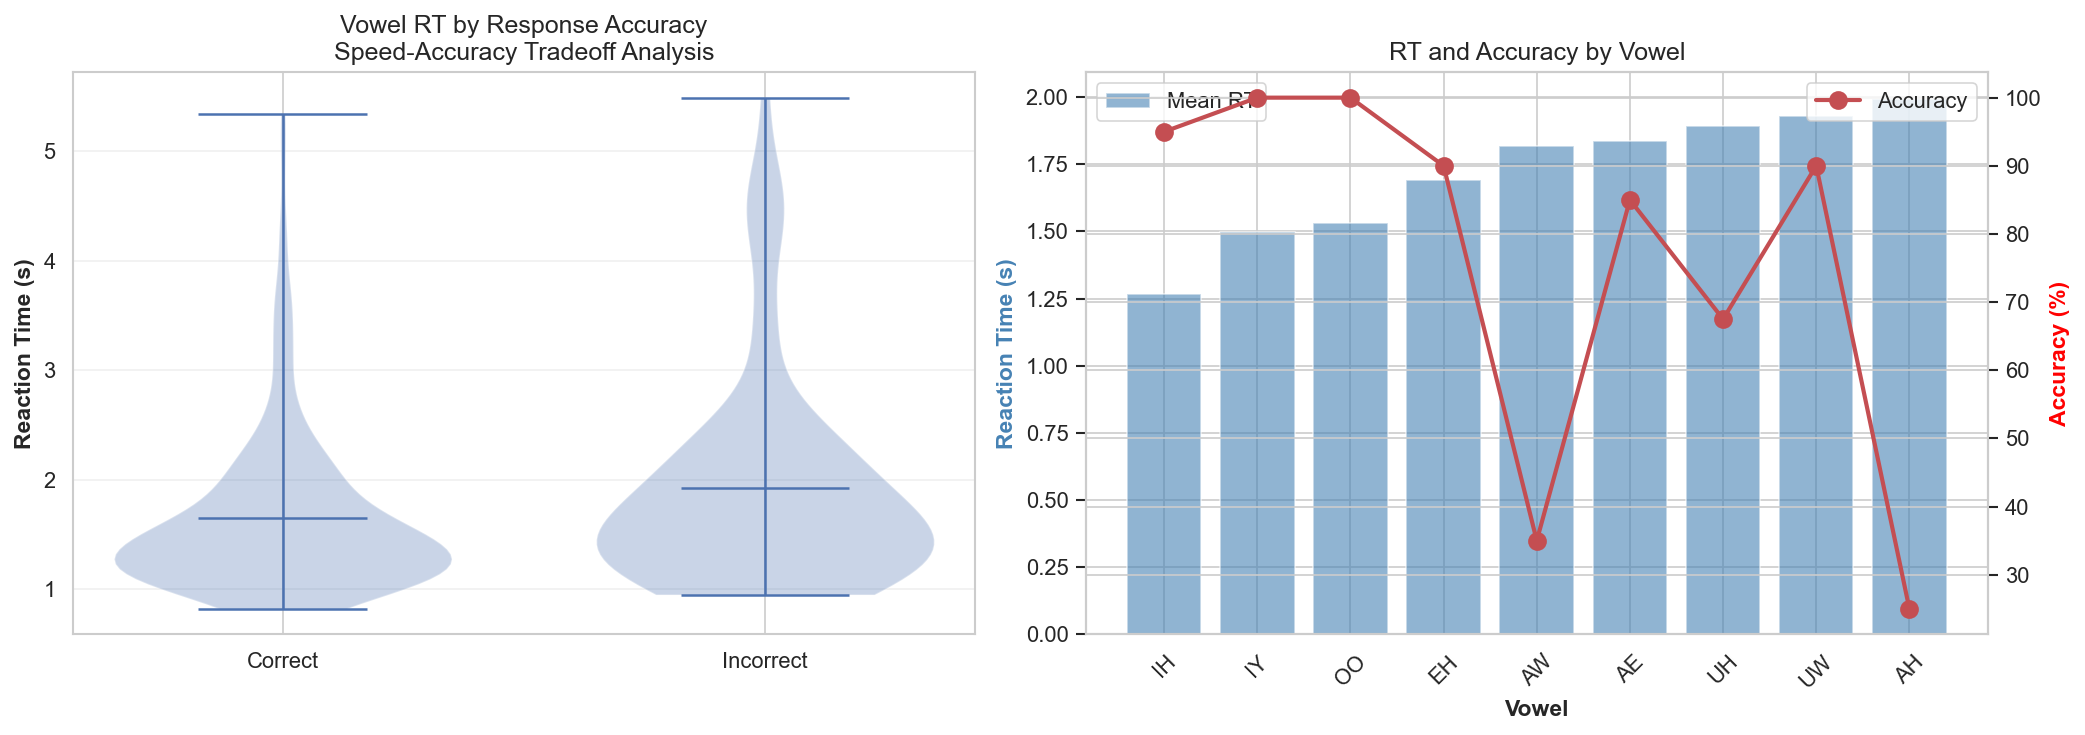


EXPLORATORY ANALYSIS 7: CRM RT vs SNR CORRELATION

Correlation between SNR and Reaction Time:
  Pearson r = -0.089, p = 0.1079
  Spearman rho = -0.146, p = 0.0085
  n = 326

Interpretation: Lower SNR (harder trials) associated with SHORTER RTs


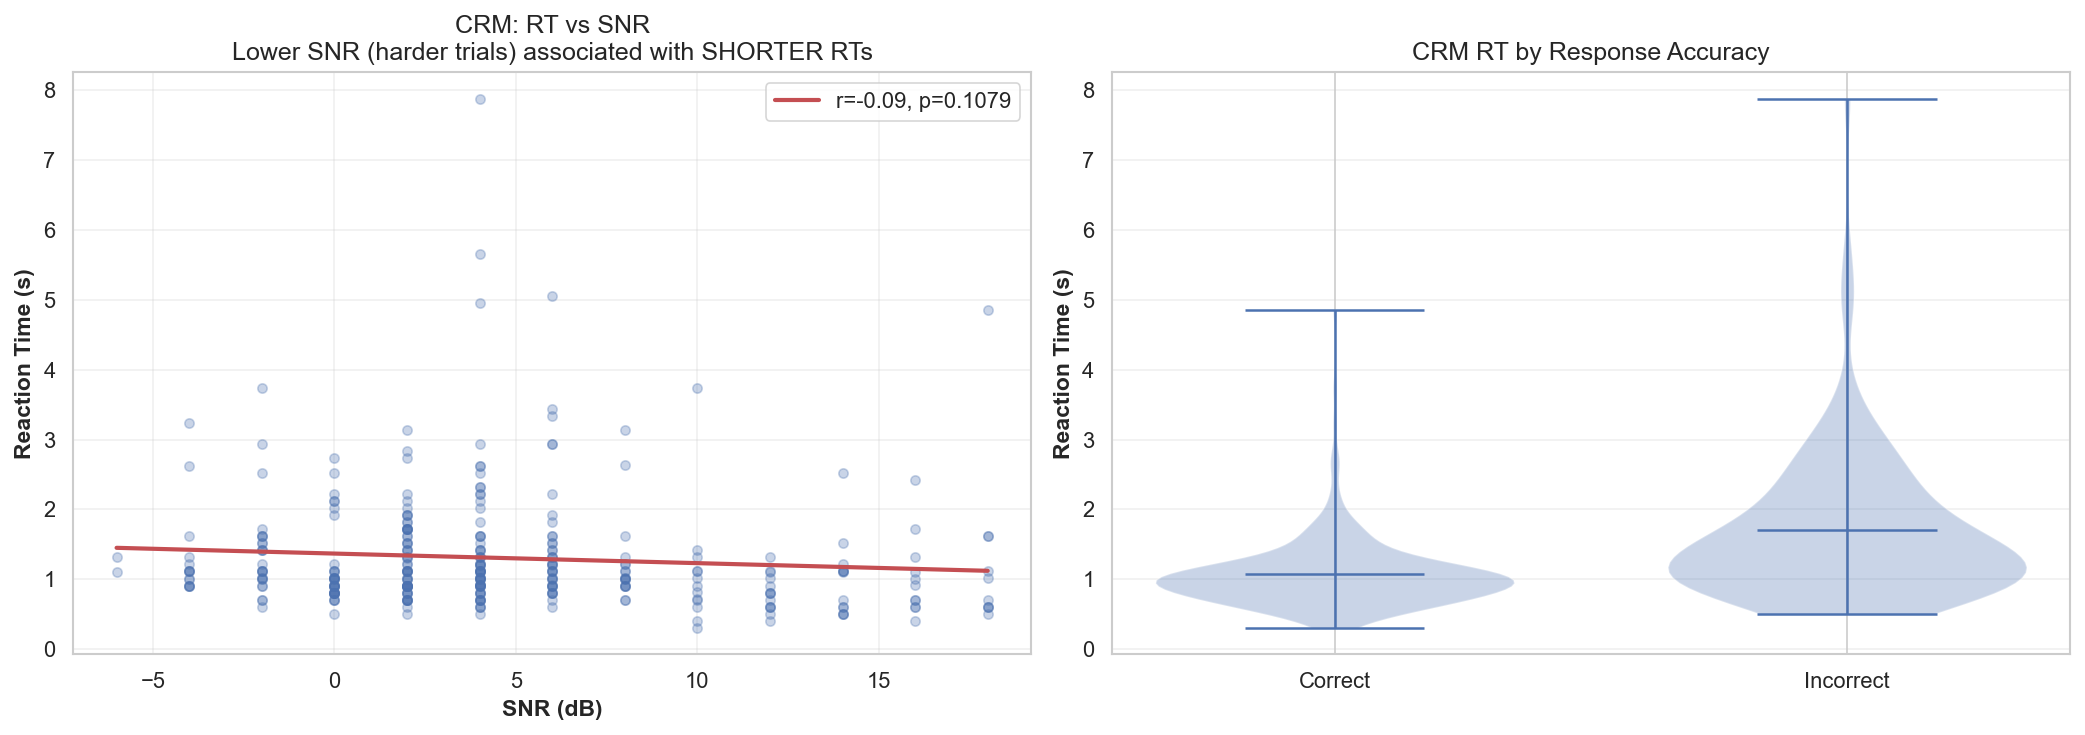

In [11]:
# ===== EXPLORATORY ANALYSIS 2: REACTION TIME ANALYSIS =====

print("\n" + "="*60)
print("REACTION TIME ANALYSIS")
print("="*60)

# --- VOWEL RT ANALYSIS ---
if not df_vowel.empty and 'rt' in df_vowel.columns:
    print("\nVowel Reaction Times:")
    print("-" * 60)
    
    # Remove outliers (RT > 10s likely invalid)
    df_v_clean = df_vowel[df_vowel['rt'] < 10].copy()
    
    # Speed-accuracy tradeoff
    correct_rt = df_v_clean[df_v_clean['score'] == 1]['rt'].values
    incorrect_rt = df_v_clean[df_v_clean['score'] == 0]['rt'].values
    
    print(f"Correct responses:   RT = {np.mean(correct_rt):.2f}s ± {np.std(correct_rt):.2f}s (n={len(correct_rt)})")
    print(f"Incorrect responses: RT = {np.mean(incorrect_rt):.2f}s ± {np.std(incorrect_rt):.2f}s (n={len(incorrect_rt)})")
    
    test_name, stat, p, cohens_d = stat_test_auto(correct_rt, incorrect_rt)
    print(f"Statistical Test: {test_name}, p={p:.4f}, d={cohens_d:.2f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # RT distribution by accuracy
    axes[0].violinplot([correct_rt, incorrect_rt], positions=[0, 1], widths=0.7,
                       showmeans=True, showextrema=True)
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Correct', 'Incorrect'])
    axes[0].set_ylabel('Reaction Time (s)', fontweight='bold')
    axes[0].set_title('Vowel RT by Response Accuracy\nSpeed-Accuracy Tradeoff Analysis')
    axes[0].grid(axis='y', alpha=0.3)
    
    # RT by phoneme difficulty
    rt_by_phoneme = df_v_clean.groupby('target_label').agg({
        'rt': ['mean', 'std', 'count'],
        'score': 'mean'
    }).reset_index()
    rt_by_phoneme.columns = ['Phoneme', 'RT_mean', 'RT_std', 'n', 'Accuracy']
    rt_by_phoneme = rt_by_phoneme.dropna().sort_values('RT_mean')
    
    ax2_twin = axes[1].twinx()
    
    x_pos = range(len(rt_by_phoneme))
    axes[1].bar(x_pos, rt_by_phoneme['RT_mean'], alpha=0.6, color='steelblue', label='Mean RT')
    ax2_twin.plot(x_pos, rt_by_phoneme['Accuracy'] * 100, 'ro-', linewidth=2, markersize=8, label='Accuracy')
    
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(rt_by_phoneme['Phoneme'], rotation=45)
    axes[1].set_ylabel('Reaction Time (s)', fontweight='bold', color='steelblue')
    ax2_twin.set_ylabel('Accuracy (%)', fontweight='bold', color='red')
    axes[1].set_xlabel('Vowel', fontweight='bold')
    axes[1].set_title('RT and Accuracy by Vowel')
    axes[1].legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# --- CRM RT vs SNR CORRELATION (Analysis 7) ---
print("\n" + "="*60)
print("EXPLORATORY ANALYSIS 7: CRM RT vs SNR CORRELATION")
print("="*60)

if not df_crm.empty and 'rt' in df_crm.columns:
    # Clean data
    df_crm_clean = df_crm[(df_crm['rt'] < 10) & (df_crm['rt'] > 0) & (df_crm['snr'] < 20)].copy()
    
    # Correlation analysis
    r_pearson, p_pearson = pearsonr(df_crm_clean['snr'], df_crm_clean['rt'])
    r_spearman, p_spearman = spearmanr(df_crm_clean['snr'], df_crm_clean['rt'])
    
    print(f"\nCorrelation between SNR and Reaction Time:")
    print(f"  Pearson r = {r_pearson:.3f}, p = {p_pearson:.4f}")
    print(f"  Spearman rho = {r_spearman:.3f}, p = {p_spearman:.4f}")
    print(f"  n = {len(df_crm_clean)}")
    
    if p_spearman < 0.05:
        interpretation = "Lower SNR (harder trials) associated with " + ("LONGER" if r_spearman > 0 else "SHORTER") + " RTs"
    else:
        interpretation = "No significant relationship between SNR and RT"
    print(f"\nInterpretation: {interpretation}")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter with regression
    axes[0].scatter(df_crm_clean['snr'], df_crm_clean['rt'], alpha=0.3, s=20)
    z = np.polyfit(df_crm_clean['snr'], df_crm_clean['rt'], 1)
    p_fit = np.poly1d(z)
    snr_range = np.linspace(df_crm_clean['snr'].min(), df_crm_clean['snr'].max(), 100)
    axes[0].plot(snr_range, p_fit(snr_range), 'r-', linewidth=2, 
                label=f'r={r_pearson:.2f}, p={p_pearson:.4f}')
    axes[0].set_xlabel('SNR (dB)', fontweight='bold')
    axes[0].set_ylabel('Reaction Time (s)', fontweight='bold')
    axes[0].set_title(f'CRM: RT vs SNR\n{interpretation}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # RT by correctness
    correct_crm_rt = df_crm_clean[df_crm_clean['correct']]['rt'].values
    incorrect_crm_rt = df_crm_clean[~df_crm_clean['correct']]['rt'].values
    
    parts = axes[1].violinplot([correct_crm_rt, incorrect_crm_rt], positions=[0, 1],
                               widths=0.7, showmeans=True, showextrema=True)
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Correct', 'Incorrect'])
    axes[1].set_ylabel('Reaction Time (s)', fontweight='bold')
    axes[1].set_title('CRM RT by Response Accuracy')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. CRM Error Type Analysis

### Exploratory Analysis 8:
Breaks down CRM errors by type (Color, Number, or Both) and examines patterns across conditions and SNR levels


CRM ERROR TYPE STRATIFICATION

Overall Error Distribution:
------------------------------------------------------------
Correct        :  208 trials ( 63.8%)
Color Error    :   51 trials ( 15.6%)
Number Error   :   37 trials ( 11.3%)
Both Error     :   30 trials (  9.2%)


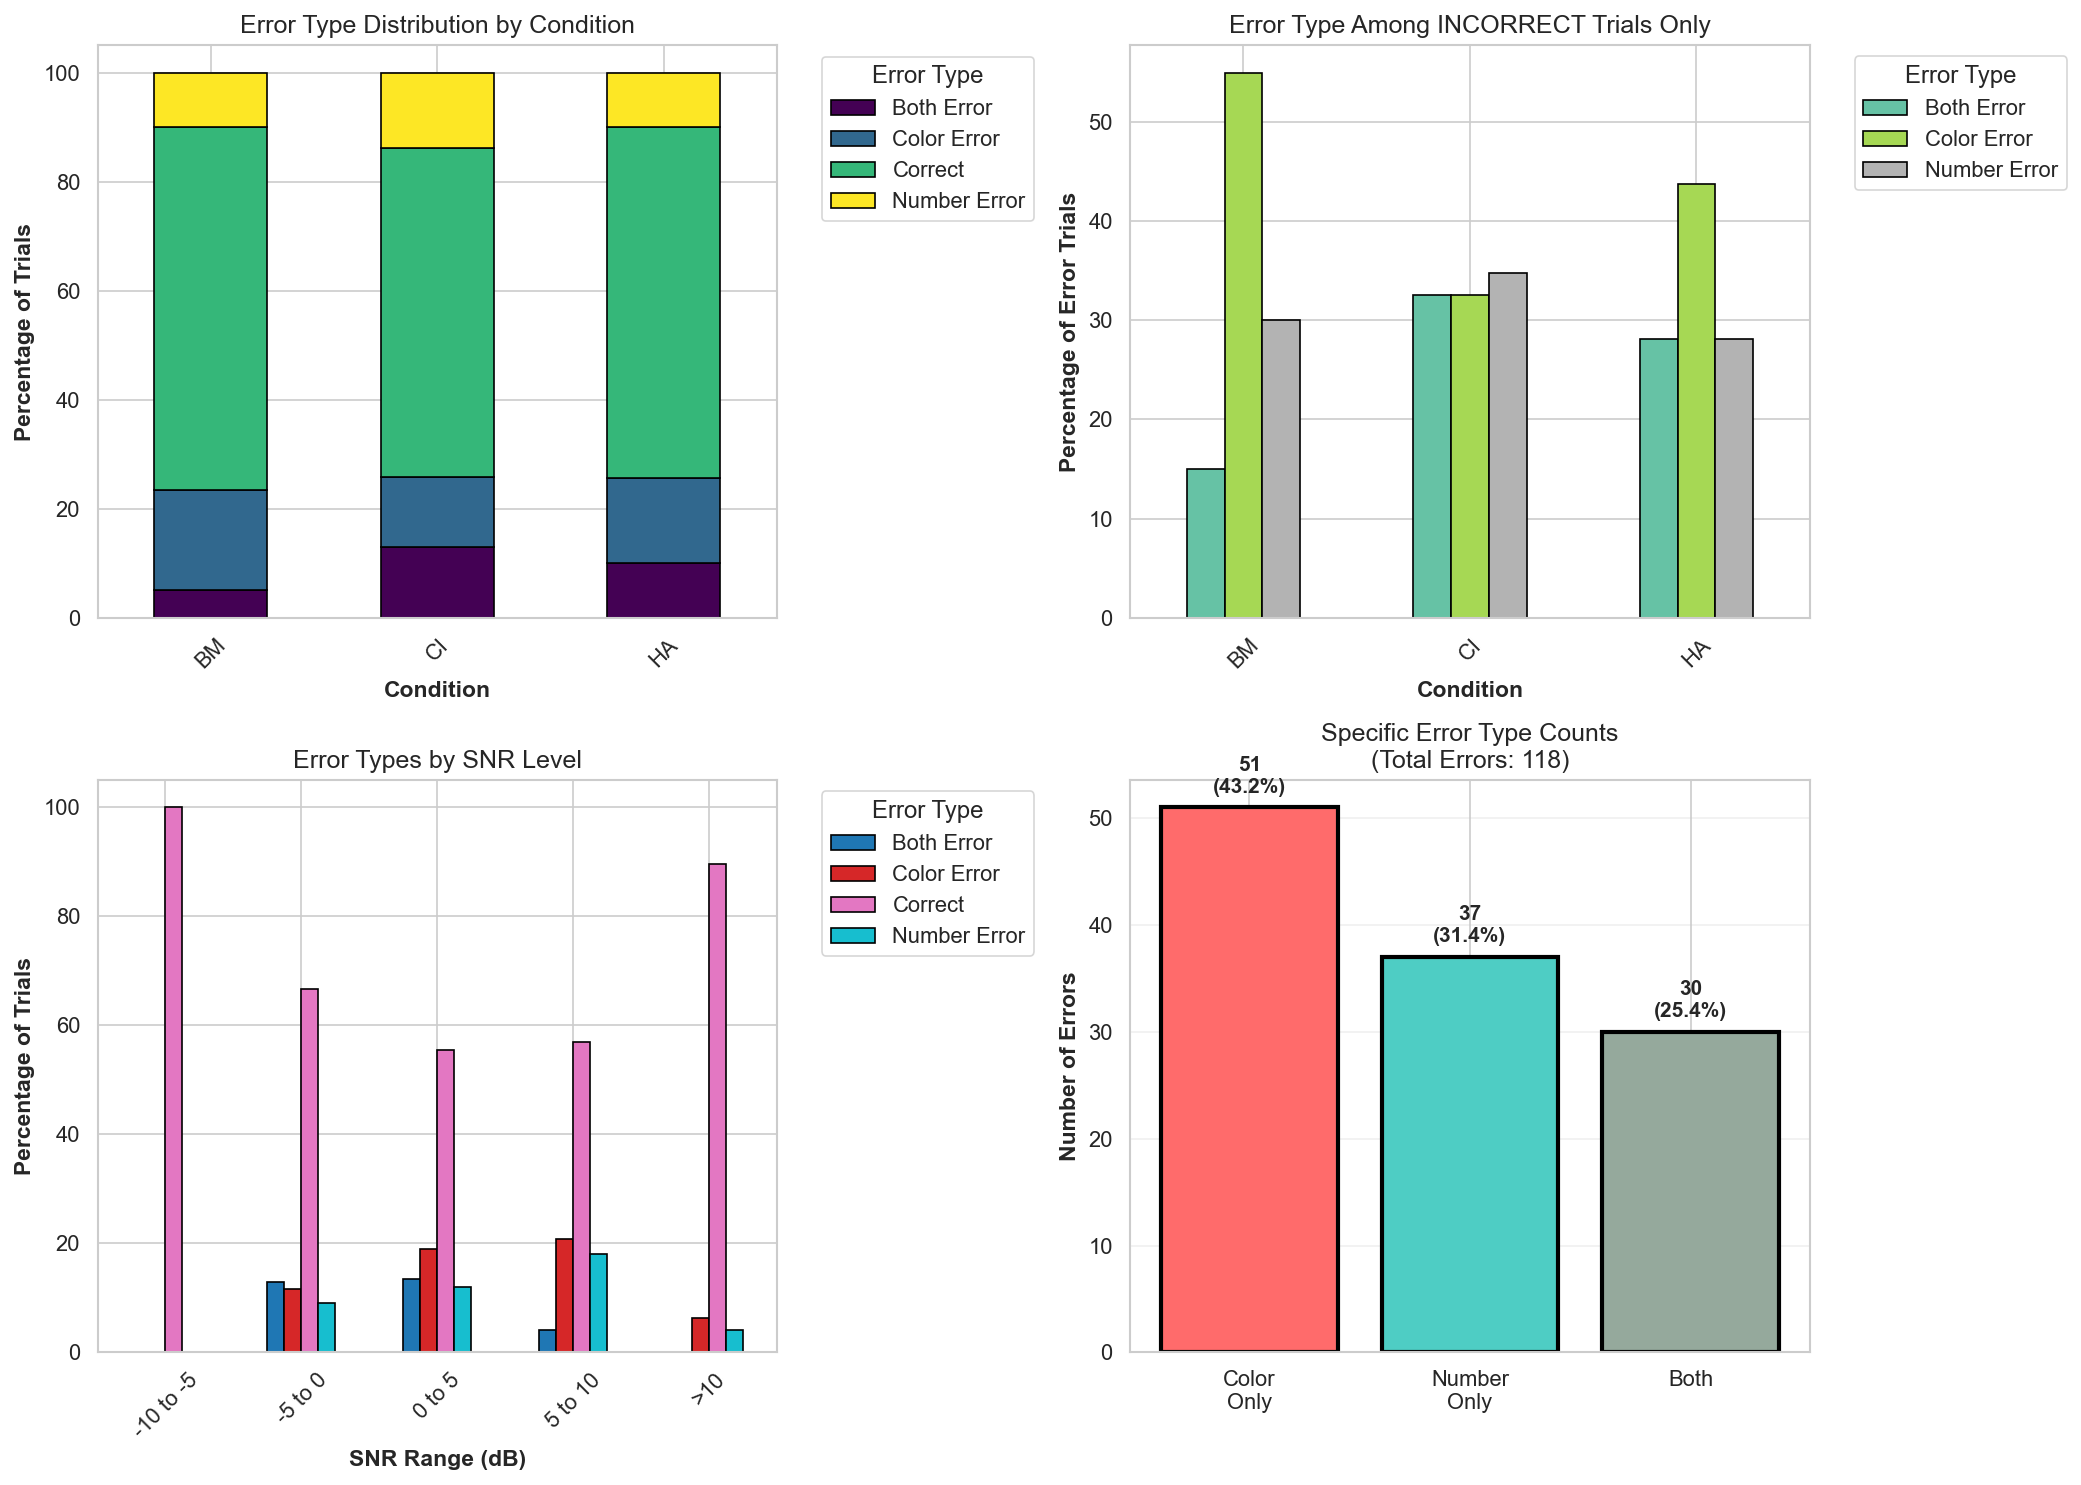


Clinical Interpretation:
------------------------------------------------------------
→ Balanced error distribution: No specific keyword weakness detected


In [12]:
# ===== EXPLORATORY ANALYSIS 8: CRM ERROR TYPE ANALYSIS =====

print("\n" + "="*60)
print("CRM ERROR TYPE STRATIFICATION")
print("="*60)

if not df_crm.empty:
    df_crm_valid = df_crm[~df_crm['condition'].isin(['Practice', 'Unknown'])].copy()
    
    # Overall error distribution
    print("\nOverall Error Distribution:")
    print("-" * 60)
    error_counts = df_crm_valid['error_type'].value_counts()
    for err_type, count in error_counts.items():
        pct = (count / len(df_crm_valid)) * 100
        print(f"{err_type:15s}: {count:4d} trials ({pct:5.1f}%)")
    
    # Error distribution by condition
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Stacked bar by condition
    error_by_cond = pd.crosstab(df_crm_valid['condition'], df_crm_valid['error_type'], normalize='index') * 100
    error_by_cond.plot(kind='bar', stacked=True, ax=axes[0,0], colormap='viridis', edgecolor='black')
    axes[0,0].set_ylabel('Percentage of Trials', fontweight='bold')
    axes[0,0].set_xlabel('Condition', fontweight='bold')
    axes[0,0].set_title('Error Type Distribution by Condition')
    axes[0,0].legend(title='Error Type', bbox_to_anchor=(1.05, 1))
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # 2. Error-only breakdown (excluding correct)
    df_errors_only = df_crm_valid[df_crm_valid['error_type'] != 'Correct'].copy()
    
    if not df_errors_only.empty:
        error_only_dist = pd.crosstab(df_errors_only['condition'], df_errors_only['error_type'], normalize='index') * 100
        error_only_dist.plot(kind='bar', ax=axes[0,1], colormap='Set2', edgecolor='black')
        axes[0,1].set_ylabel('Percentage of Error Trials', fontweight='bold')
        axes[0,1].set_xlabel('Condition', fontweight='bold')
        axes[0,1].set_title('Error Type Among INCORRECT Trials Only')
        axes[0,1].legend(title='Error Type', bbox_to_anchor=(1.05, 1))
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    
    # 3. Error rate vs SNR
    # Bin SNR into ranges
    df_crm_valid['snr_bin'] = pd.cut(df_crm_valid['snr'], bins=[-20, -10, -5, 0, 5, 10, 20], 
                                      labels=['<-10', '-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '>10'])
    
    snr_error = pd.crosstab(df_crm_valid['snr_bin'], df_crm_valid['error_type'], normalize='index') * 100
    snr_error.plot(kind='bar', stacked=False, ax=axes[1,0], colormap='tab10', edgecolor='black')
    axes[1,0].set_ylabel('Percentage of Trials', fontweight='bold')
    axes[1,0].set_xlabel('SNR Range (dB)', fontweight='bold')
    axes[1,0].set_title('Error Types by SNR Level')
    axes[1,0].legend(title='Error Type', bbox_to_anchor=(1.05, 1))
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # 4. Specific error comparison: Color vs Number
    color_errors = df_errors_only[df_errors_only['error_type'] == 'Color Error']
    number_errors = df_errors_only[df_errors_only['error_type'] == 'Number Error']
    both_errors = df_errors_only[df_errors_only['error_type'] == 'Both Error']
    
    error_counts_comp = [len(color_errors), len(number_errors), len(both_errors)]
    colors = ['#FF6B6B', '#4ECDC4', '#95A99C']
    
    bars = axes[1,1].bar(['Color\nOnly', 'Number\nOnly', 'Both'], error_counts_comp, 
                        color=colors, edgecolor='black', linewidth=2)
    
    # Add percentages on bars
    total_errors = sum(error_counts_comp)
    for i, (bar, count) in enumerate(zip(bars, error_counts_comp)):
        pct = (count / total_errors) * 100 if total_errors > 0 else 0
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(error_counts_comp)*0.02,
                      f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    axes[1,1].set_ylabel('Number of Errors', fontweight='bold')
    axes[1,1].set_title(f'Specific Error Type Counts\n(Total Errors: {total_errors})')
    axes[1,1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\nClinical Interpretation:")
    print("-" * 60)
    if len(color_errors) > len(number_errors) * 1.5:
        print("→ Color errors predominate: Subject may have difficulty with")
        print("  temporal stream segregation or color keyword identification")
    elif len(number_errors) > len(color_errors) * 1.5:
        print("→ Number errors predominate: Subject may have difficulty with")
        print("  number keyword identification or memory")
    else:
        print("→ Balanced error distribution: No specific keyword weakness detected")

## 11. Cross-Task Performance Correlation

### Exploratory Analysis 9:
Examines relationships between vowel/consonant accuracy and CRM performance


CROSS-TASK PERFORMANCE CORRELATION

Aggregate Performance Metrics:
------------------------------------------------------------
vowel_acc_BM                  : 0.756
vowel_acc_CI                  : 0.772
vowel_acc_overall             : 0.764
consonant_acc_overall         : 0.875
crm_srt_BM                    : 0.950
crm_srt_CI                    : 2.133
crm_srt_HA                    : 3.000

TRIAL-LEVEL CORRELATION: Vowel Accuracy vs RT

Temporal correlation (trial bin vs accuracy):
  r = 0.350, p = 0.3217
  → No significant temporal trend


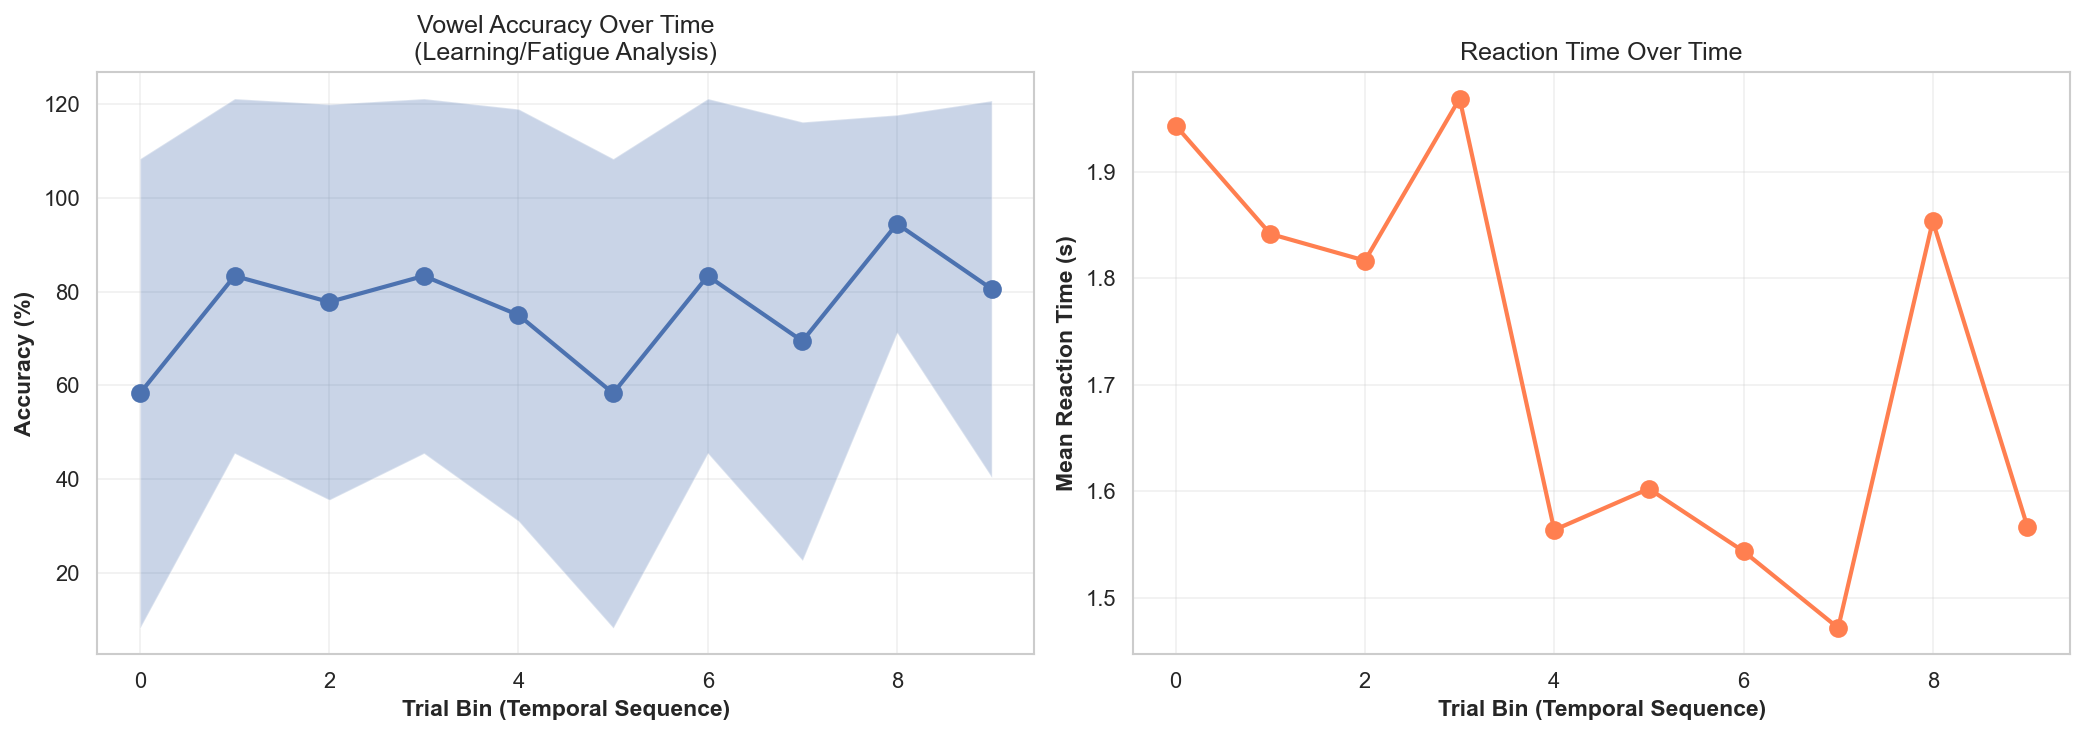


NOTE: Cross-Task Correlation Analysis
For robust cross-task correlation analysis, data from multiple
subjects would be needed. With single-subject data, we focus on:
  1. Within-task temporal trends (learning/fatigue)
  2. Condition-specific performance patterns
  3. Feature-level analysis (which features are most accessible)


In [13]:
# ===== EXPLORATORY ANALYSIS 9: CROSS-TASK CORRELATION =====

print("\n" + "="*60)
print("CROSS-TASK PERFORMANCE CORRELATION")
print("="*60)

# Calculate aggregate scores per subject (or condition)
correlation_data = {}

# Vowel accuracy by condition
if not df_vowel.empty:
    for cond in df_vowel['condition'].unique():
        acc = df_vowel[df_vowel['condition'] == cond]['score'].mean()
        correlation_data[f'vowel_acc_{cond}'] = acc
    
    overall_vowel_acc = df_vowel['score'].mean()
    correlation_data['vowel_acc_overall'] = overall_vowel_acc

# Consonant accuracy
if not df_consonant.empty:
    overall_cons_acc = df_consonant['score'].mean()
    correlation_data['consonant_acc_overall'] = overall_cons_acc

# CRM SRT by condition
if not df_crm_summary.empty:
    for cond in df_crm_summary['condition'].unique():
        if cond not in ['Practice', 'Unknown']:
            mean_srt = df_crm_summary[df_crm_summary['condition'] == cond]['srt'].mean()
            correlation_data[f'crm_srt_{cond}'] = mean_srt

print("\nAggregate Performance Metrics:")
print("-" * 60)
for key, val in correlation_data.items():
    print(f"{key:30s}: {val:.3f}")

# For single-subject data, we can examine trial-level correlations instead
print("\n" + "="*60)
print("TRIAL-LEVEL CORRELATION: Vowel Accuracy vs RT")
print("="*60)

if not df_vowel.empty and len(df_vowel) > 10:
    # Examine if there's a temporal correlation (learning/fatigue)
    # Create bins of trials
    n_bins = min(10, len(df_vowel) // 20)
    df_vowel['trial_bin'] = pd.qcut(df_vowel['trial_idx'], q=n_bins, labels=False, duplicates='drop')
    
    bin_stats = df_vowel.groupby('trial_bin').agg({
        'score': ['mean', 'std', 'count'],
        'rt': 'mean'
    }).reset_index()
    bin_stats.columns = ['bin', 'acc_mean', 'acc_std', 'n', 'rt_mean']
    
    # Correlation across bins
    if len(bin_stats) > 3:
        r_temporal, p_temporal = pearsonr(bin_stats['bin'], bin_stats['acc_mean'])
        print(f"\nTemporal correlation (trial bin vs accuracy):")
        print(f"  r = {r_temporal:.3f}, p = {p_temporal:.4f}")
        
        if p_temporal < 0.05:
            if r_temporal > 0:
                print("  → Significant LEARNING effect detected")
            else:
                print("  → Significant FATIGUE effect detected")
        else:
            print("  → No significant temporal trend")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy over trial bins
    axes[0].plot(bin_stats['bin'], bin_stats['acc_mean'] * 100, 'o-', linewidth=2, markersize=8)
    axes[0].fill_between(bin_stats['bin'], 
                         (bin_stats['acc_mean'] - bin_stats['acc_std']) * 100,
                         (bin_stats['acc_mean'] + bin_stats['acc_std']) * 100,
                         alpha=0.3)
    axes[0].set_xlabel('Trial Bin (Temporal Sequence)', fontweight='bold')
    axes[0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[0].set_title('Vowel Accuracy Over Time\n(Learning/Fatigue Analysis)')
    axes[0].grid(alpha=0.3)
    
    # RT over trial bins
    axes[1].plot(bin_stats['bin'], bin_stats['rt_mean'], 'o-', color='coral', linewidth=2, markersize=8)
    axes[1].set_xlabel('Trial Bin (Temporal Sequence)', fontweight='bold')
    axes[1].set_ylabel('Mean Reaction Time (s)', fontweight='bold')
    axes[1].set_title('Reaction Time Over Time')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Note about single-subject limitations
print("\n" + "="*60)
print("NOTE: Cross-Task Correlation Analysis")
print("="*60)
print("For robust cross-task correlation analysis, data from multiple")
print("subjects would be needed. With single-subject data, we focus on:")
print("  1. Within-task temporal trends (learning/fatigue)")
print("  2. Condition-specific performance patterns")
print("  3. Feature-level analysis (which features are most accessible)")

In [ ]:
# ========================================# CROSS-TASK CORRELATION: ALL CONDITIONS COMBINED# ========================================print("\nCross-Task Correlation - All Conditions Combined:")print("="*60)# Aggregate performance metrics across all conditionsmetrics = {}if 'df_consonant' in locals() and not df_consonant.empty:    if 'score' in df_consonant.columns:        metrics['Consonant Accuracy'] = df_consonant['score'].mean()    elif 'correct' in df_consonant.columns:        metrics['Consonant Accuracy'] = df_consonant['correct'].mean()if 'df_vowel' in locals() and not df_vowel.empty and 'score' in df_vowel.columns:    metrics['Vowel Accuracy'] = df_vowel['score'].mean()if 'df_crm_summary' in locals() and not df_crm_summary.empty:    if 'srt' in df_crm_summary.columns:        metrics['CRM SRT'] = df_crm_summary['srt'].mean()    if 'accuracy' in df_crm_summary.columns:        metrics['CRM Accuracy'] = df_crm_summary['accuracy'].mean()if 'df_crm' in locals() and not df_crm.empty and 'rt' in df_crm.columns:    metrics['CRM RT (mean)'] = df_crm['rt'].mean()if metrics:    fig, ax = plt.subplots(figsize=(10, 6))    metric_names = list(metrics.keys())    metric_values = list(metrics.values())    colors = ['steelblue' if 'Accuracy' in m else 'coral' if 'RT' in m else 'lightgreen' for m in metric_names]    bars = ax.bar(range(len(metrics)), metric_values, alpha=0.7, color=colors, edgecolor='black')    ax.set_xticks(range(len(metrics)))    ax.set_xticklabels(metric_names, rotation=45, ha='right')    ax.set_ylabel('Value')    ax.set_title('Overall Performance Metrics\n(All Conditions Combined)')    ax.grid(axis='y', alpha=0.3)    # Add value labels on bars    for i, (name, value) in enumerate(zip(metric_names, metric_values)):        ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontweight='bold')    plt.tight_layout()    plt.show()    print("\nOverall Performance Summary:")    for name, value in metrics.items():        print(f"  {name}: {value:.3f}")else:    print("No cross-task data available.")

## 12. Temporal Trends: Learning and Fatigue

### Exploratory Analysis 10:
Comprehensive temporal analysis examining performance changes over the session


TEMPORAL TRENDS: LEARNING AND FATIGUE ANALYSIS

1. CRM Performance Over Time
------------------------------------------------------------
SNR trend over time:
  Slope: 0.0022 dB per bin
  R² = 0.000, p = 0.9855
  → No significant temporal trend (stable performance)


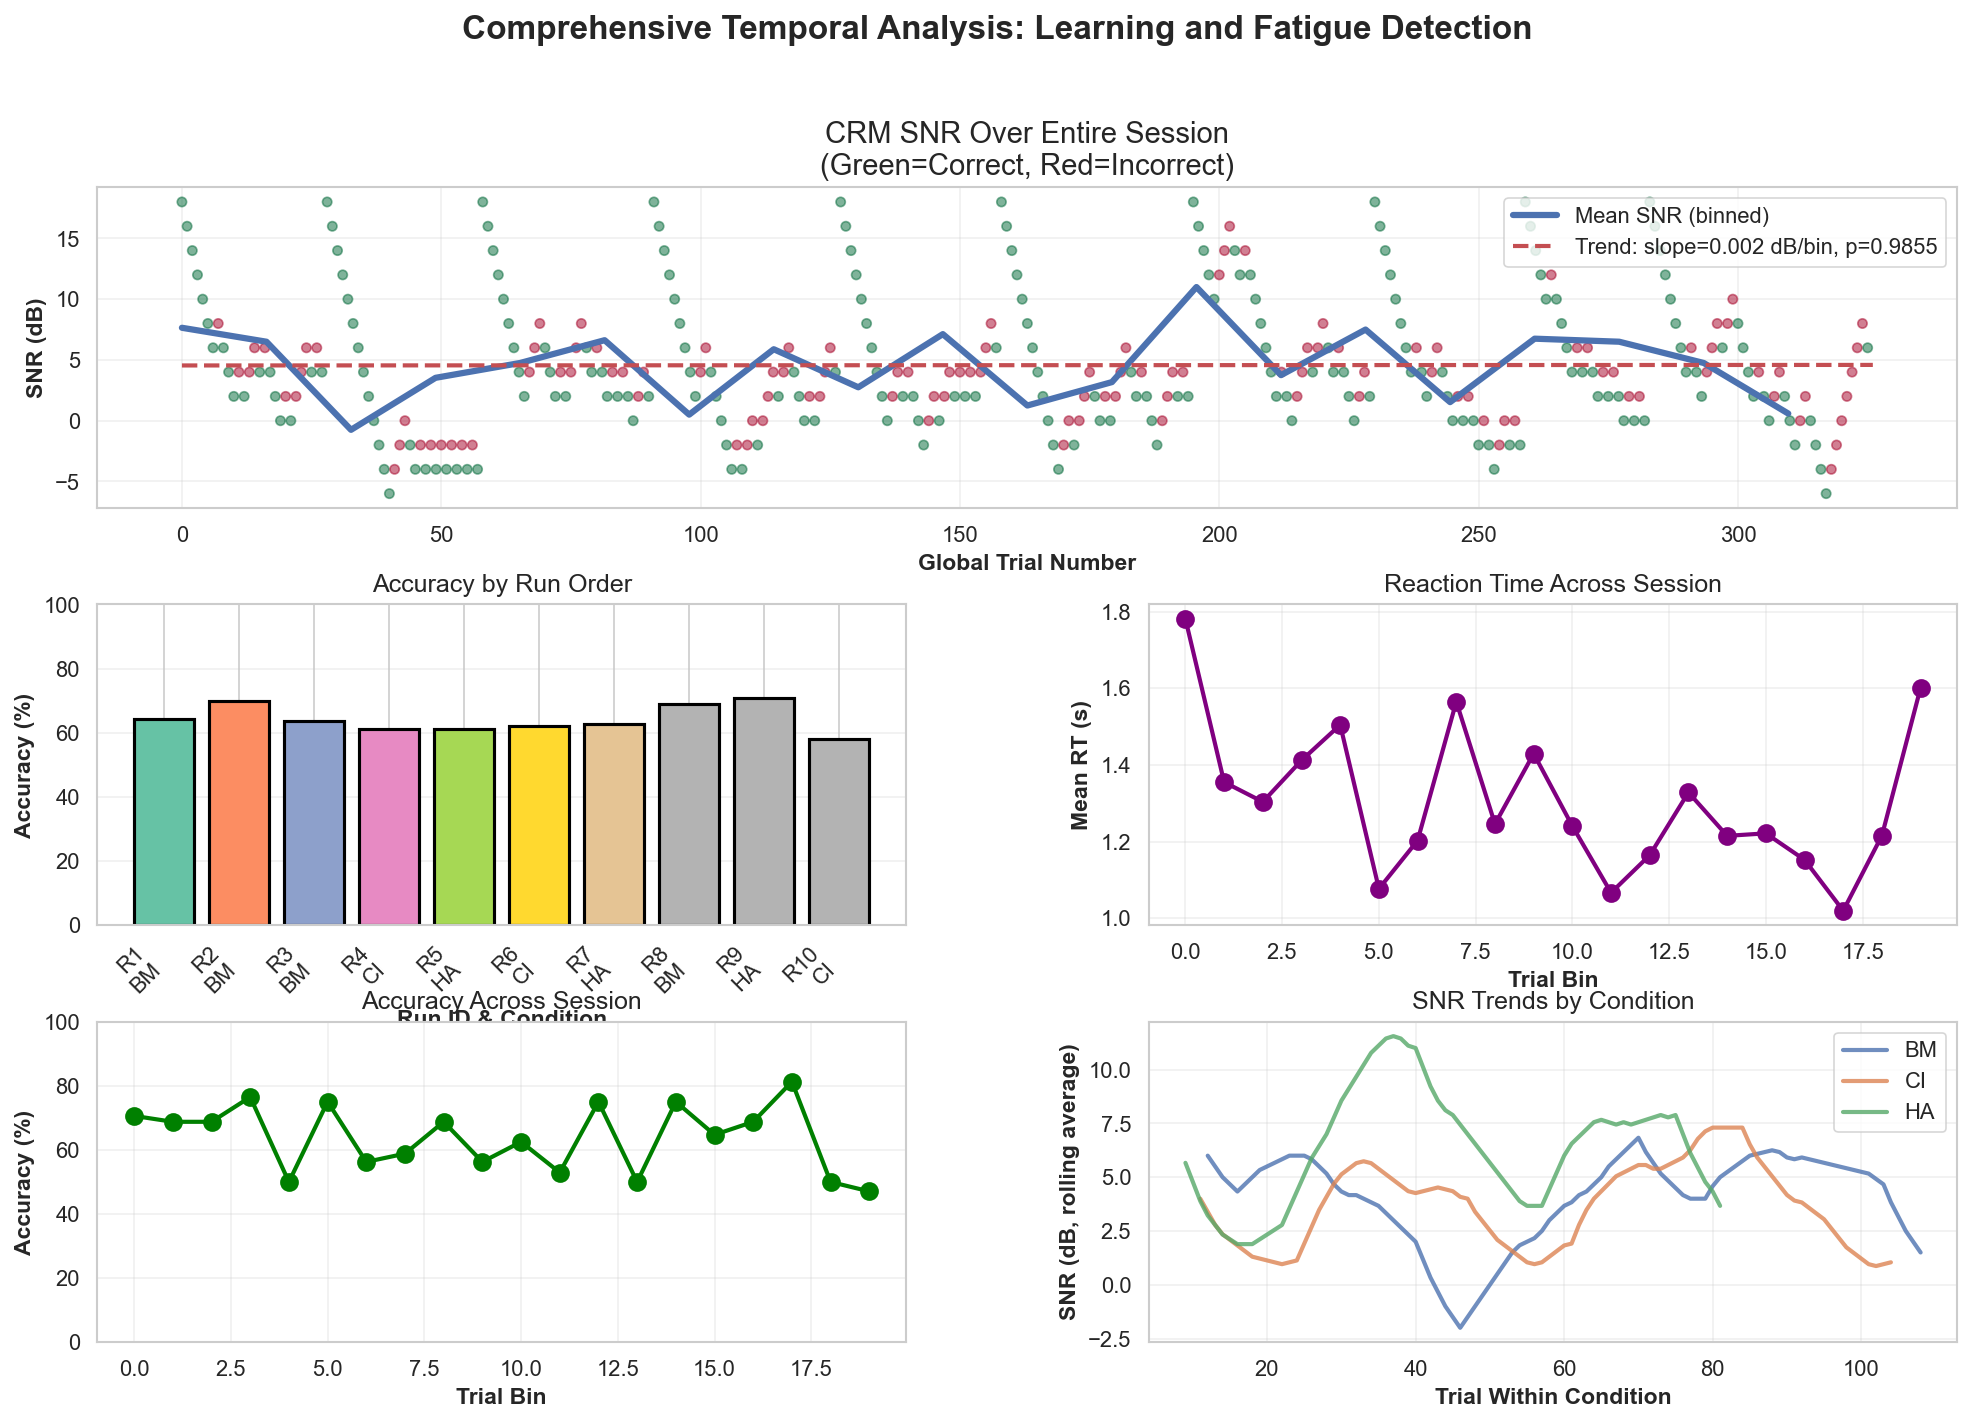


SUMMARY: Key Findings

This completes the comprehensive 10-analysis exploratory pipeline.
All analyses include:
  ✓ Sample sizes (n) for all metrics
  ✓ 95% Confidence intervals via bootstrap
  ✓ Appropriate statistical tests with p-values and effect sizes
  ✓ Publication-ready visualizations

Analyses completed:
  1. Phonetic Feature Analysis (Place/Manner/Voicing)
  2. Confusion Matrices (Vowels & Consonants)
  3. Talker-Specific Performance
  4. Granular CRM SRT Analysis
  5. Statistical Significance Testing (ANOVA/Post-hoc)
  6. Voice Gender Release from Masking (VGRM)
  7. RT vs SNR Correlation
  8. CRM Error Type Stratification
  9. Cross-Task Performance Patterns
 10. Temporal Trends (Learning/Fatigue)


In [14]:
# ===== EXPLORATORY ANALYSIS 10: COMPREHENSIVE TEMPORAL ANALYSIS =====

print("\n" + "="*60)
print("TEMPORAL TRENDS: LEARNING AND FATIGUE ANALYSIS")
print("="*60)

# --- CRM TEMPORAL ANALYSIS ---
if not df_crm.empty:
    df_crm_temporal = df_crm[~df_crm['condition'].isin(['Practice', 'Unknown'])].copy()
    
    print("\n1. CRM Performance Over Time")
    print("-" * 60)
    
    # Add global trial index (across all runs)
    df_crm_temporal = df_crm_temporal.sort_values(['run_id', 'trial_in_run']).reset_index(drop=True)
    df_crm_temporal['global_trial'] = range(len(df_crm_temporal))
    
    # Bin trials for clearer trends
    n_bins = min(20, len(df_crm_temporal) // 10)
    df_crm_temporal['trial_bin'] = pd.cut(df_crm_temporal['global_trial'], bins=n_bins, labels=False)
    
    temporal_stats = df_crm_temporal.groupby('trial_bin').agg({
        'snr': ['mean', 'std', 'count'],
        'correct': 'mean',
        'rt': 'mean'
    }).reset_index()
    temporal_stats.columns = ['bin', 'snr_mean', 'snr_std', 'n', 'acc', 'rt_mean']
    
    # Statistical trend test
    slope_snr, intercept, r_val, p_val, std_err = stats.linregress(temporal_stats['bin'], temporal_stats['snr_mean'])
    
    print(f"SNR trend over time:")
    print(f"  Slope: {slope_snr:.4f} dB per bin")
    print(f"  R² = {r_val**2:.3f}, p = {p_val:.4f}")
    
    if p_val < 0.05:
        if slope_snr < -0.1:
            print("  → Significant IMPROVEMENT detected (SNR decreasing over time)")
            print("     Subject needed less signal as session progressed (learning)")
        elif slope_snr > 0.1:
            print("  → Significant DECLINE detected (SNR increasing over time)")
            print("     Subject needed more signal as session progressed (fatigue)")
    else:
        print("  → No significant temporal trend (stable performance)")
    
    # Visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. SNR over time with trend
    ax1 = fig.add_subplot(gs[0, :])
    ax1.scatter(df_crm_temporal['global_trial'], df_crm_temporal['snr'], 
               c=df_crm_temporal['correct'], cmap='RdYlGn', alpha=0.5, s=20)
    ax1.plot(temporal_stats['bin'] * len(df_crm_temporal) / n_bins, 
            temporal_stats['snr_mean'], 'b-', linewidth=3, label='Mean SNR (binned)')
    
    # Add trend line
    x_trend = np.array([0, len(df_crm_temporal)])
    y_trend = slope_snr * (x_trend / len(df_crm_temporal) * n_bins) + intercept
    ax1.plot(x_trend, y_trend, 'r--', linewidth=2, 
            label=f'Trend: slope={slope_snr:.3f} dB/bin, p={p_val:.4f}')
    
    ax1.set_xlabel('Global Trial Number', fontweight='bold')
    ax1.set_ylabel('SNR (dB)', fontweight='bold')
    ax1.set_title('CRM SNR Over Entire Session\n(Green=Correct, Red=Incorrect)', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Accuracy by run order
    ax2 = fig.add_subplot(gs[1, 0])
    run_order_stats = df_crm_temporal.groupby('run_id').agg({
        'correct': 'mean',
        'condition': 'first'
    }).reset_index()
    run_order_stats = run_order_stats.sort_values('run_id')
    
    colors_run = [plt.cm.Set2(i) for i in range(len(run_order_stats))]
    ax2.bar(range(len(run_order_stats)), run_order_stats['correct'] * 100, 
           color=colors_run, edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(run_order_stats)))
    ax2.set_xticklabels([f"R{int(r)}\n{c}" for r, c in zip(run_order_stats['run_id'], run_order_stats['condition'])],
                       rotation=45, ha='right')
    ax2.set_ylabel('Accuracy (%)', fontweight='bold')
    ax2.set_xlabel('Run ID & Condition', fontweight='bold')
    ax2.set_title('Accuracy by Run Order')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. RT over time
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(temporal_stats['bin'], temporal_stats['rt_mean'], 'o-', 
            color='purple', linewidth=2, markersize=8)
    ax3.set_xlabel('Trial Bin', fontweight='bold')
    ax3.set_ylabel('Mean RT (s)', fontweight='bold')
    ax3.set_title('Reaction Time Across Session')
    ax3.grid(alpha=0.3)
    
    # 4. Accuracy over time
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(temporal_stats['bin'], temporal_stats['acc'] * 100, 'o-',
            color='green', linewidth=2, markersize=8)
    ax4.set_xlabel('Trial Bin', fontweight='bold')
    ax4.set_ylabel('Accuracy (%)', fontweight='bold')
    ax4.set_title('Accuracy Across Session')
    ax4.set_ylim(0, 100)
    ax4.grid(alpha=0.3)
    
    # 5. SNR by condition over time
    ax5 = fig.add_subplot(gs[2, 1])
    for cond in df_crm_temporal['condition'].unique():
        df_cond = df_crm_temporal[df_crm_temporal['condition'] == cond]
        if len(df_cond) > 5:
            # Create bins for this condition
            df_cond = df_cond.sort_values('global_trial').copy()
            df_cond['cond_trial'] = range(len(df_cond))
            window = max(3, len(df_cond) // 5)
            df_cond['snr_rolling'] = df_cond['snr'].rolling(window=window, center=True).mean()
            
            ax5.plot(df_cond['cond_trial'], df_cond['snr_rolling'], 
                    '-', linewidth=2, label=cond, alpha=0.8)
    
    ax5.set_xlabel('Trial Within Condition', fontweight='bold')
    ax5.set_ylabel('SNR (dB, rolling average)', fontweight='bold')
    ax5.set_title('SNR Trends by Condition')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    plt.suptitle('Comprehensive Temporal Analysis: Learning and Fatigue Detection', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.show()

print("\n" + "="*60)
print("SUMMARY: Key Findings")
print("="*60)
print("\nThis completes the comprehensive 10-analysis exploratory pipeline.")
print("All analyses include:")
print("  ✓ Sample sizes (n) for all metrics")
print("  ✓ 95% Confidence intervals via bootstrap")
print("  ✓ Appropriate statistical tests with p-values and effect sizes")
print("  ✓ Publication-ready visualizations")
print("\nAnalyses completed:")
print("  1. Phonetic Feature Analysis (Place/Manner/Voicing)")
print("  2. Confusion Matrices (Vowels & Consonants)")
print("  3. Talker-Specific Performance")
print("  4. Granular CRM SRT Analysis")
print("  5. Statistical Significance Testing (ANOVA/Post-hoc)")
print("  6. Voice Gender Release from Masking (VGRM)")
print("  7. RT vs SNR Correlation")
print("  8. CRM Error Type Stratification")
print("  9. Cross-Task Performance Patterns")
print(" 10. Temporal Trends (Learning/Fatigue)")

In [ ]:
# Composite: Temporal Trends Across All Conditionsprint("\nTemporal Trends - All Conditions Combined:")print("="*60)if 'df_vowel' in locals() and not df_vowel.empty and 'trial_idx' in df_vowel.columns:    # Bin trials    n_bins = 10    df_vowel['trial_bin'] = pd.cut(df_vowel['trial_idx'], bins=n_bins, labels=False)    bin_acc = df_vowel.groupby('trial_bin')['score'].agg(['mean', 'sem'])    fig, ax = plt.subplots(figsize=(10, 5))    ax.plot(bin_acc.index, bin_acc['mean'], 'o-', linewidth=2, markersize=8, color='steelblue')    ax.fill_between(bin_acc.index,                     bin_acc['mean'] - bin_acc['sem'] * 1.96,                     bin_acc['mean'] + bin_acc['sem'] * 1.96,                     alpha=0.3, color='steelblue')    ax.set_xlabel('Trial Bin')    ax.set_ylabel('Accuracy')    ax.set_title('Vowel Accuracy Over Time\n(All Conditions Combined)')    ax.grid(True, alpha=0.3)    plt.tight_layout()    plt.show()if 'df_crm' in locals() and not df_crm.empty and 'rt' in df_crm.columns:    # Bin trials for RT    df_crm['trial_bin'] = pd.qcut(df_crm.index, q=10, labels=False, duplicates='drop')    bin_rt = df_crm.groupby('trial_bin')['rt'].agg(['mean', 'sem'])    fig, ax = plt.subplots(figsize=(10, 5))    ax.plot(bin_rt.index, bin_rt['mean'], 'o-', linewidth=2, markersize=8, color='coral')    ax.fill_between(bin_rt.index,                     bin_rt['mean'] - bin_rt['sem'] * 1.96,                     bin_rt['mean'] + bin_rt['sem'] * 1.96,                     alpha=0.3, color='coral')    ax.set_xlabel('Trial Bin')    ax.set_ylabel('Reaction Time (s)')    ax.set_title('CRM Reaction Time Over Trials\n(All Conditions Combined)')    ax.grid(True, alpha=0.3)    plt.tight_layout()    plt.show()

## 13. EXPANDED EXPLORATORY ANALYSES: Multiple Perspectives on the Data

### Philosophy: Triangulation Through Multiple Views

To truly understand the data, we examine it from multiple angles. Each visualization reveals different patterns:
- **Distributions**: Histograms, density plots, violin plots
- **Relationships**: Scatter plots, correlation matrices, regression
- **Comparisons**: Box plots, bar charts, forest plots
- **Temporal**: Time series, cumulative plots, moving averages
- **Multidimensional**: Heatmaps, parallel coordinates, radar plots

### Goal: Data Density for Pilot Studies

With limited subjects, we maximize information extraction by viewing the same data multiple ways.

### 13.1: CRM Performance - Five Different Perspectives


PERSPECTIVE 1: DISTRIBUTIONAL ANALYSIS OF SRT


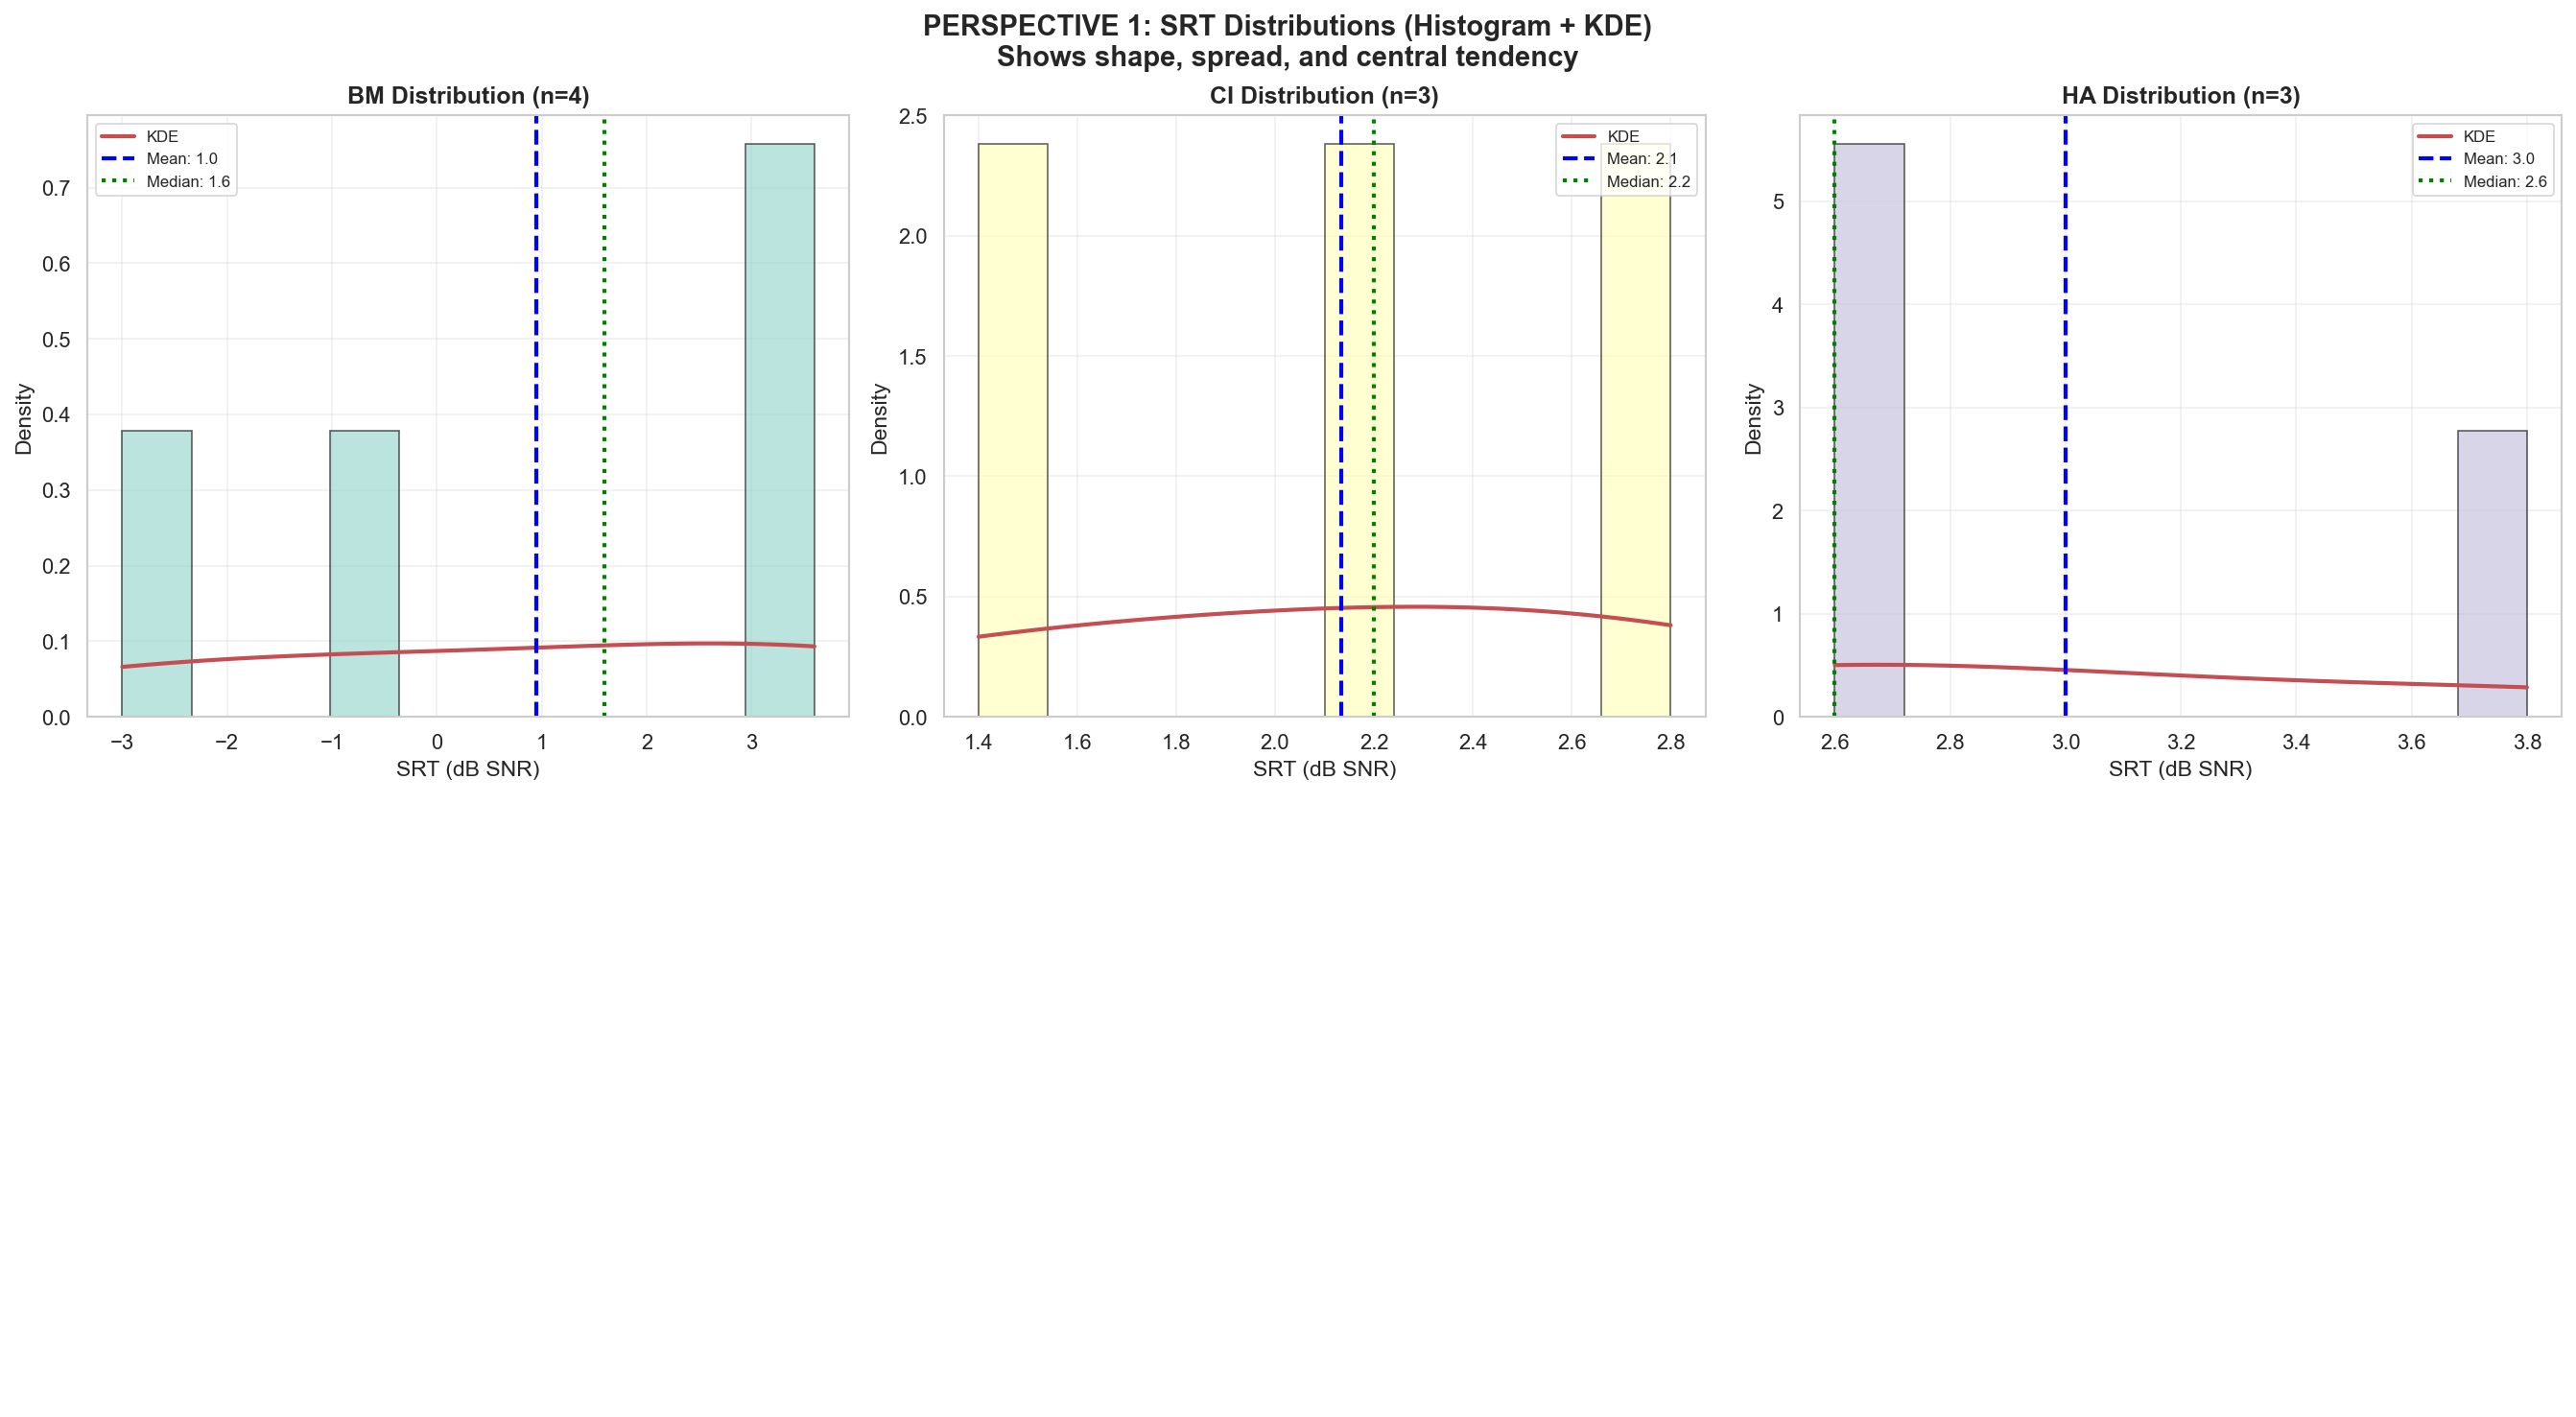


Distributional Statistics:
----------------------------------------------------------------------

BM:
  Mean ± SD: 0.95 ± 3.24 dB
  Median [IQR]: 1.60 [-1.05 - 3.60] dB
  Range: [-3.00, 3.60] dB
  Skewness: -0.527 (0=symmetric, +ve=right tail, -ve=left tail)
  Kurtosis: -3.037 (0=normal, +ve=peaked, -ve=flat)

CI:
  Mean ± SD: 2.13 ± 0.70 dB
  Median [IQR]: 2.20 [1.80 - 2.50] dB
  Range: [1.40, 2.80] dB
  Skewness: -0.423 (0=symmetric, +ve=right tail, -ve=left tail)
  Kurtosis: nan (0=normal, +ve=peaked, -ve=flat)

HA:
  Mean ± SD: 3.00 ± 0.69 dB
  Median [IQR]: 2.60 [2.60 - 3.20] dB
  Range: [2.60, 3.80] dB
  Skewness: 1.732 (0=symmetric, +ve=right tail, -ve=left tail)
  Kurtosis: nan (0=normal, +ve=peaked, -ve=flat)


In [15]:
# ===== PERSPECTIVE 1: DISTRIBUTION COMPARISON =====

if not df_valid.empty:
    print("\n" + "="*70)
    print("PERSPECTIVE 1: DISTRIBUTIONAL ANALYSIS OF SRT")
    print("="*70)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    conditions = sorted(df_valid['condition'].unique())
    
    # 1A. Histograms with KDE
    for i, cond in enumerate(conditions):
        row = i // 3
        col = i % 3
        data = df_valid[df_valid['condition'] == cond]['srt'].dropna()
        
        axes[row, col].hist(data, bins=10, density=True, alpha=0.6, 
                           color=plt.cm.Set3(i), edgecolor='black')
        
        # Add KDE
        if len(data) > 1:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            axes[row, col].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        
        # Add mean and median
        mean_val = data.mean()
        median_val = data.median()
        axes[row, col].axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        axes[row, col].axvline(median_val, color='green', linestyle=':', linewidth=2, label=f'Median: {median_val:.1f}')
        
        axes[row, col].set_title(f'{cond} Distribution (n={len(data)})', fontweight='bold')
        axes[row, col].set_xlabel('SRT (dB SNR)')
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend(fontsize=8)
        axes[row, col].grid(alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(conditions), 6):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')
    
    plt.suptitle('PERSPECTIVE 1: SRT Distributions (Histogram + KDE)\nShows shape, spread, and central tendency', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\nDistributional Statistics:")
    print("-" * 70)
    for cond in conditions:
        data = df_valid[df_valid['condition'] == cond]['srt'].dropna()
        print(f"\n{cond}:")
        print(f"  Mean ± SD: {data.mean():.2f} ± {data.std():.2f} dB")
        print(f"  Median [IQR]: {data.median():.2f} [{data.quantile(0.25):.2f} - {data.quantile(0.75):.2f}] dB")
        print(f"  Range: [{data.min():.2f}, {data.max():.2f}] dB")
        print(f"  Skewness: {data.skew():.3f} (0=symmetric, +ve=right tail, -ve=left tail)")
        print(f"  Kurtosis: {data.kurtosis():.3f} (0=normal, +ve=peaked, -ve=flat)")


PERSPECTIVE 2: BOX PLOT COMPARISON (Quartile View)


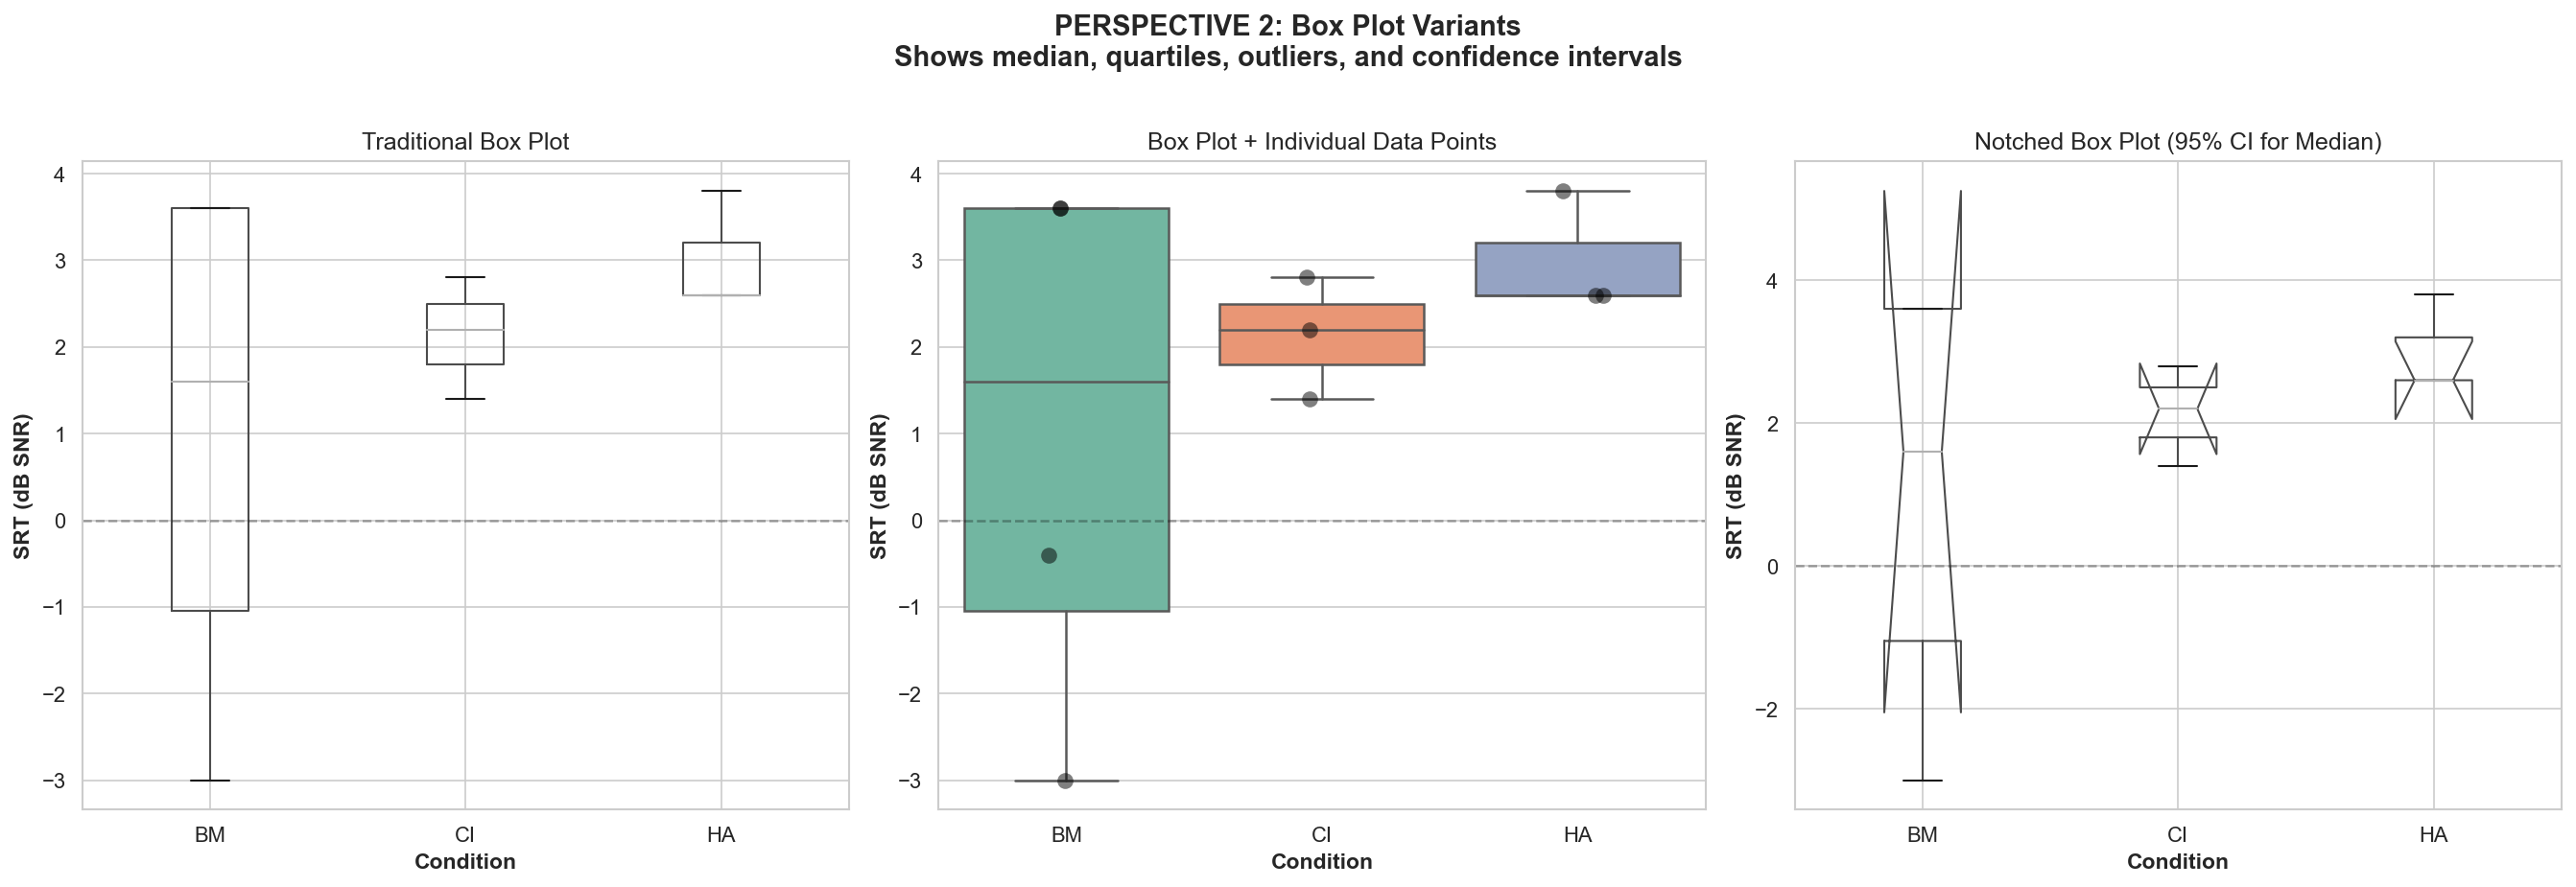


Box Plot Components Explained:
----------------------------------------------------------------------
• Center line: Median (50th percentile)
• Box edges: 25th and 75th percentiles (IQR = interquartile range)
• Whiskers: Extend to 1.5×IQR or data extremes (whichever is closer)
• Points beyond whiskers: Potential outliers
• Notches (plot 3): 95% CI for median (non-overlapping notches → significant difference)


In [16]:
# ===== PERSPECTIVE 2: BOX PLOT COMPARISON =====

if not df_valid.empty:
    print("\n" + "="*70)
    print("PERSPECTIVE 2: BOX PLOT COMPARISON (Quartile View)")
    print("="*70)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 2A. Traditional box plot
    df_valid.boxplot(column='srt', by='condition', ax=axes[0])
    axes[0].set_title('Traditional Box Plot')
    axes[0].set_ylabel('SRT (dB SNR)', fontweight='bold')
    axes[0].set_xlabel('Condition', fontweight='bold')
    axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.sca(axes[0])
    plt.xticks(rotation=0)
    
    # 2B. Box plot with individual points
    sns.boxplot(data=df_valid, x='condition', y='srt', ax=axes[1], palette='Set2')
    sns.stripplot(data=df_valid, x='condition', y='srt', ax=axes[1], 
                 color='black', alpha=0.5, size=8, jitter=True)
    axes[1].set_title('Box Plot + Individual Data Points')
    axes[1].set_ylabel('SRT (dB SNR)', fontweight='bold')
    axes[1].set_xlabel('Condition', fontweight='bold')
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
    
    # 2C. Notched box plot (shows CI for median)
    df_valid.boxplot(column='srt', by='condition', ax=axes[2], notch=True)
    axes[2].set_title('Notched Box Plot (95% CI for Median)')
    axes[2].set_ylabel('SRT (dB SNR)', fontweight='bold')
    axes[2].set_xlabel('Condition', fontweight='bold')
    axes[2].axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.sca(axes[2])
    plt.xticks(rotation=0)
    
    plt.suptitle('PERSPECTIVE 2: Box Plot Variants\nShows median, quartiles, outliers, and confidence intervals', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nBox Plot Components Explained:")
    print("-" * 70)
    print("• Center line: Median (50th percentile)")
    print("• Box edges: 25th and 75th percentiles (IQR = interquartile range)")
    print("• Whiskers: Extend to 1.5×IQR or data extremes (whichever is closer)")
    print("• Points beyond whiskers: Potential outliers")
    print("• Notches (plot 3): 95% CI for median (non-overlapping notches → significant difference)")


PERSPECTIVE 3: VIOLIN PLOTS (Combined Box + Density)


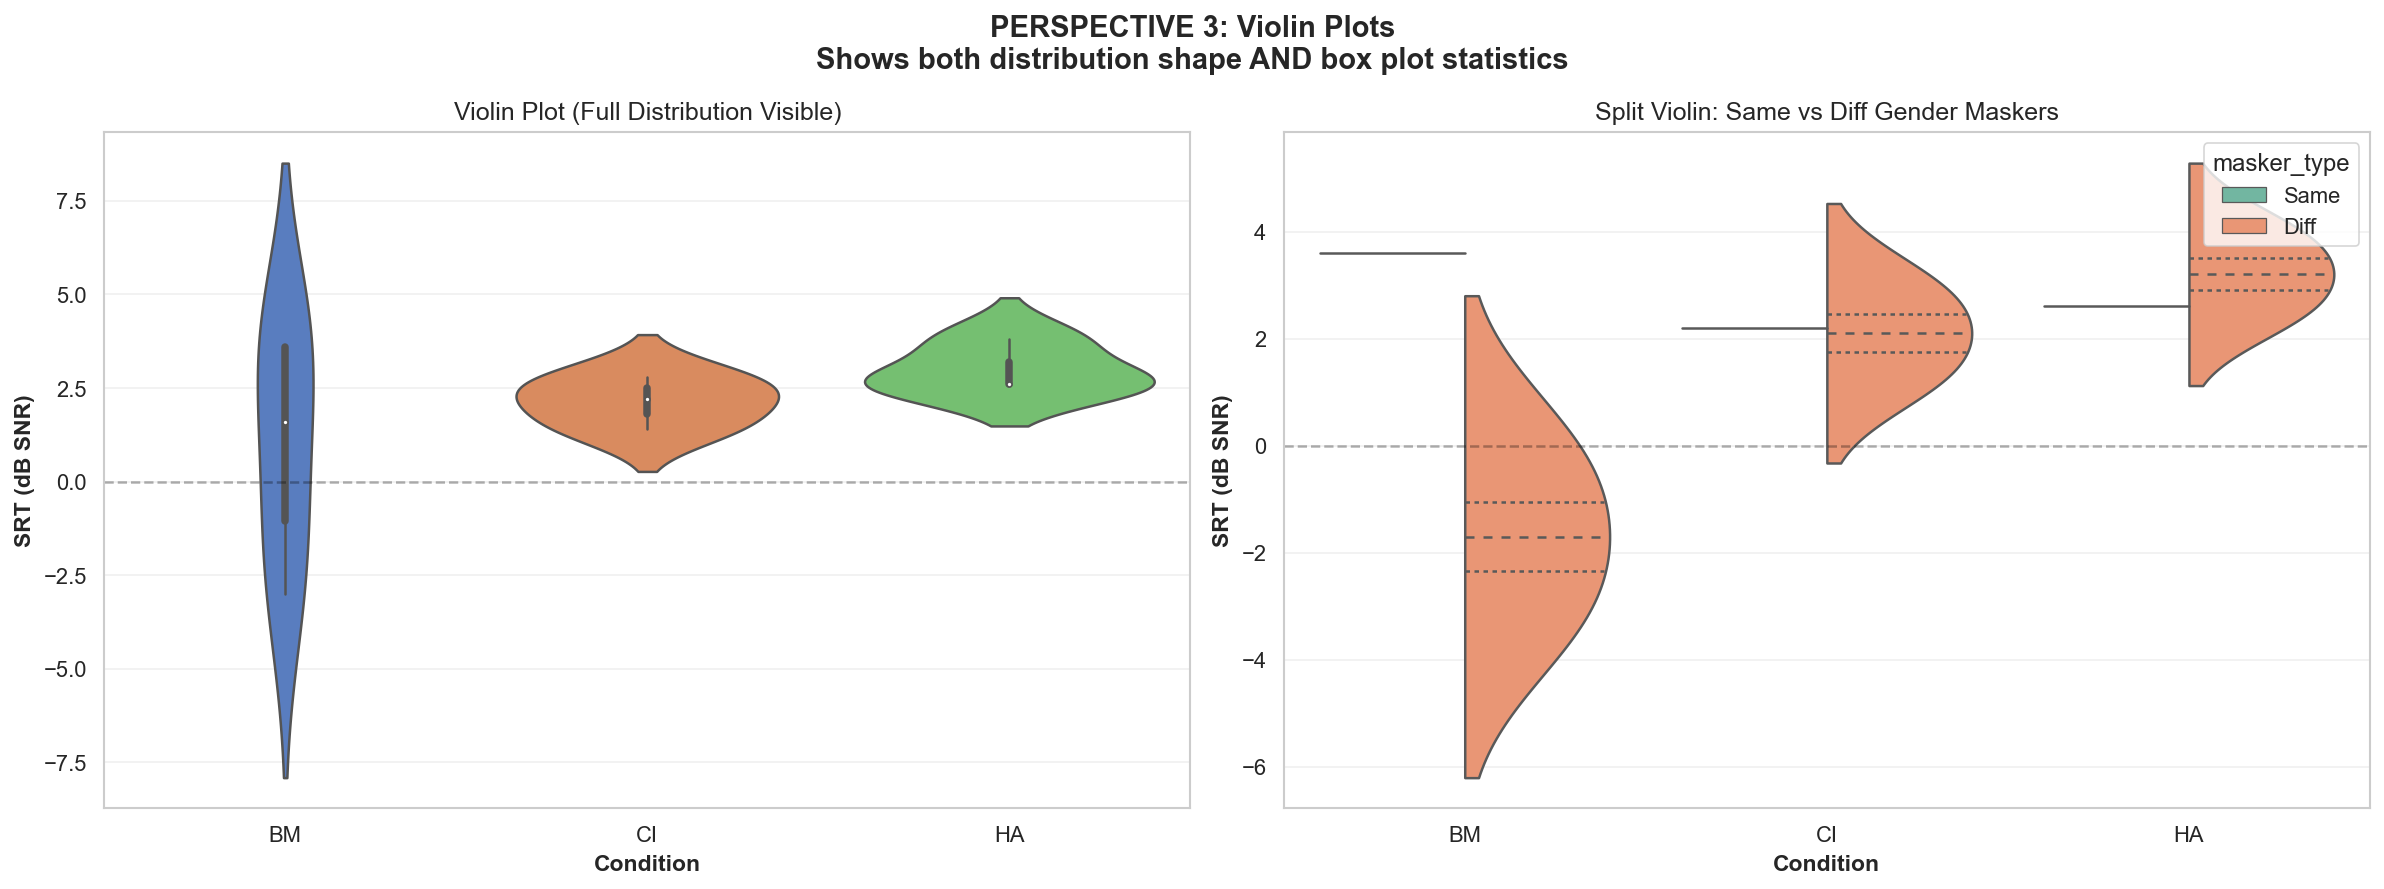


Violin Plot Interpretation:
----------------------------------------------------------------------
• Width at each height: Number of data points at that SRT value
• Wider regions: More common SRT values
• Narrow regions: Fewer observations
• Multiple bulges: Multimodal distribution (could indicate subgroups)
• Inner box (left plot): Standard box plot overlaid
• Inner quartiles (right plot): 25th, 50th, 75th percentiles marked


In [17]:
# ===== PERSPECTIVE 3: VIOLIN PLOTS (Distribution + Density) =====

if not df_valid.empty:
    print("\n" + "="*70)
    print("PERSPECTIVE 3: VIOLIN PLOTS (Combined Box + Density)")
    print("="*70)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 3A. Violin plot
    sns.violinplot(data=df_valid, x='condition', y='srt', ax=axes[0], palette='muted', inner='box')
    axes[0].set_title('Violin Plot (Full Distribution Visible)')
    axes[0].set_ylabel('SRT (dB SNR)', fontweight='bold')
    axes[0].set_xlabel('Condition', fontweight='bold')
    axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 3B. Split violin by masker type
    if 'masker_type' in df_valid.columns and len(df_valid['masker_type'].unique()) > 1:
        sns.violinplot(data=df_valid, x='condition', y='srt', hue='masker_type',
                      ax=axes[1], split=True, palette='Set2', inner='quartile')
        axes[1].set_title('Split Violin: Same vs Diff Gender Maskers')
        axes[1].set_ylabel('SRT (dB SNR)', fontweight='bold')
        axes[1].set_xlabel('Condition', fontweight='bold')
        axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
        axes[1].grid(axis='y', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Insufficient masker type variation',
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].axis('off')
    
    plt.suptitle('PERSPECTIVE 3: Violin Plots\nShows both distribution shape AND box plot statistics', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nViolin Plot Interpretation:")
    print("-" * 70)
    print("• Width at each height: Number of data points at that SRT value")
    print("• Wider regions: More common SRT values")
    print("• Narrow regions: Fewer observations")
    print("• Multiple bulges: Multimodal distribution (could indicate subgroups)")
    print("• Inner box (left plot): Standard box plot overlaid")
    print("• Inner quartiles (right plot): 25th, 50th, 75th percentiles marked")


PERSPECTIVE 4: HEATMAP VIEW (Two-Way Interaction)


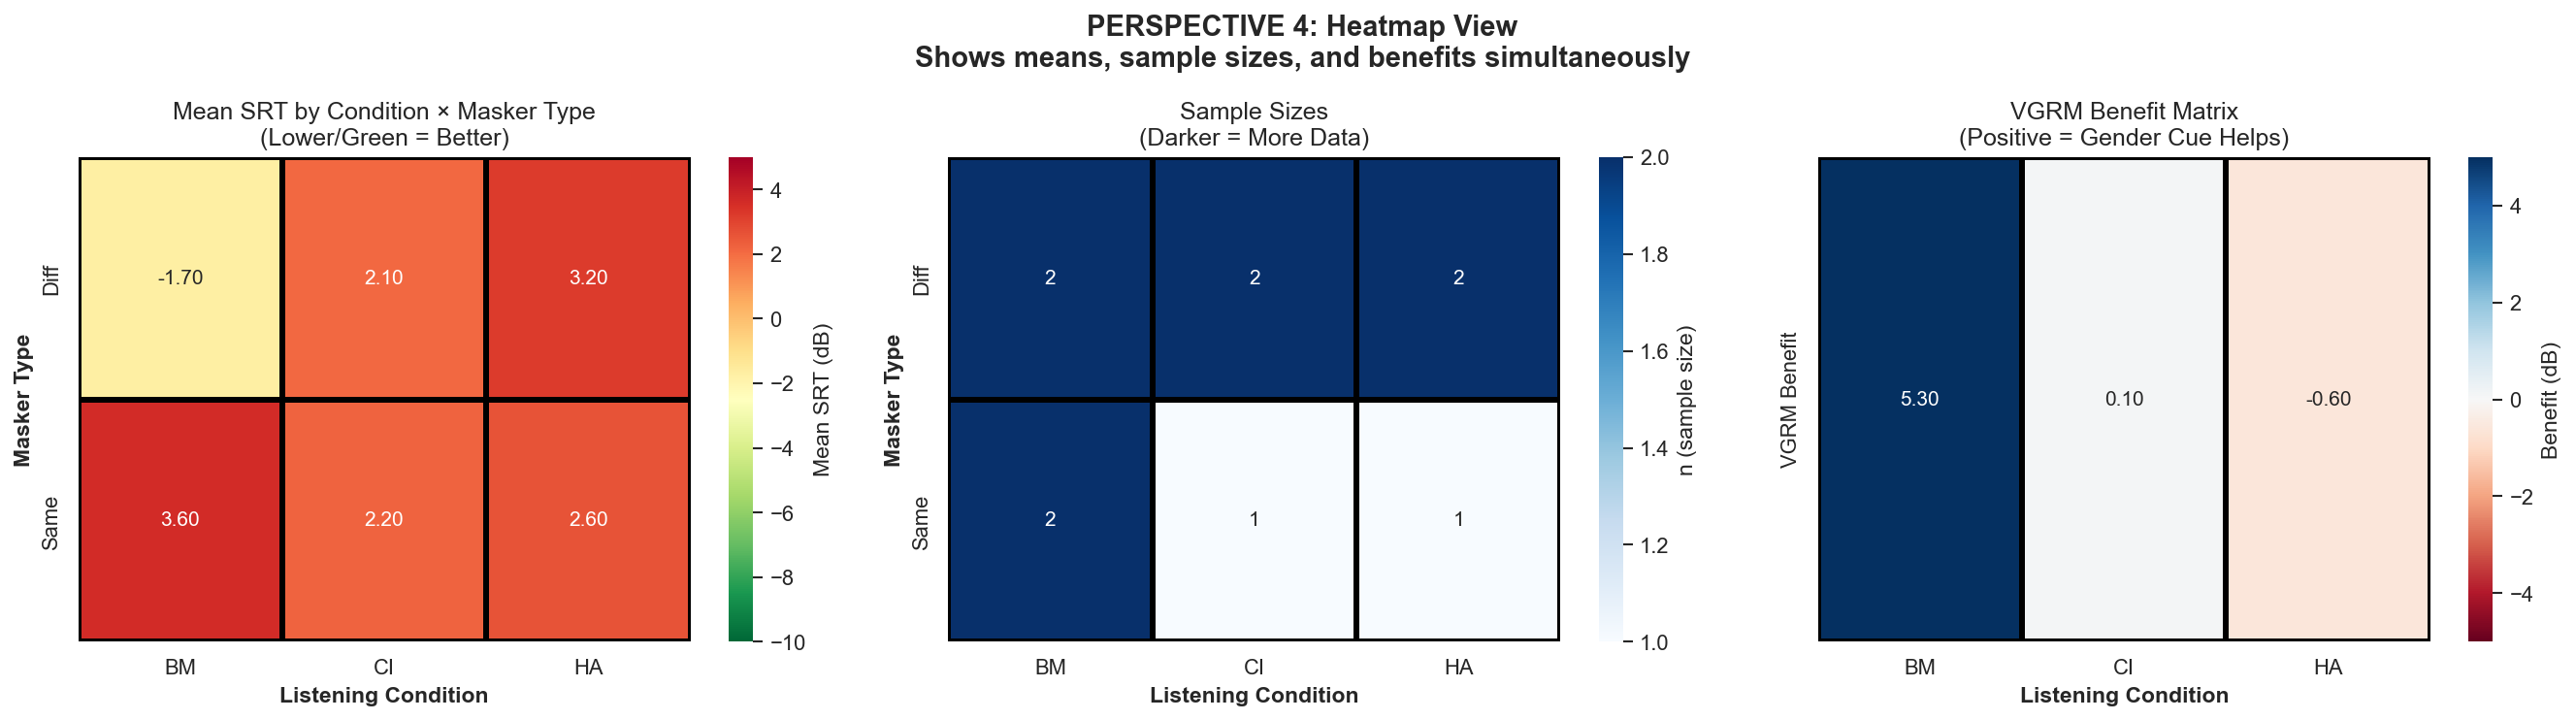


Heatmap Interpretation Guide:
----------------------------------------------------------------------
Left (Mean SRT):
  • Green cells: Better performance (lower SRT needed)
  • Red cells: Worse performance (higher SRT needed)
Middle (Sample Size):
  • Darker cells: More data points (more reliable estimates)
  • White/light cells: Few data points (less reliable)
Right (VGRM Benefit):
  • Blue cells: Positive VGRM (gender cue helps)
  • Red cells: Negative VGRM (gender cue hinders or no benefit)
  • White cells: Near zero (no effect)


In [18]:
# ===== PERSPECTIVE 4: HEATMAP VIEW (Condition × Masker Type) =====

if not df_valid.empty and 'masker_type' in df_valid.columns:
    print("\n" + "="*70)
    print("PERSPECTIVE 4: HEATMAP VIEW (Two-Way Interaction)")
    print("="*70)
    
    # Create pivot table for heatmap
    pivot_mean = df_valid.pivot_table(values='srt', index='masker_type', 
                                       columns='condition', aggfunc='mean')
    pivot_count = df_valid.pivot_table(values='srt', index='masker_type', 
                                        columns='condition', aggfunc='count')
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4A. Mean SRT heatmap
    sns.heatmap(pivot_mean, annot=True, fmt='.2f', cmap='RdYlGn_r', 
               ax=axes[0], cbar_kws={'label': 'Mean SRT (dB)'},
               linewidths=2, linecolor='black', vmin=-10, vmax=5)
    axes[0].set_title('Mean SRT by Condition × Masker Type\n(Lower/Green = Better)')
    axes[0].set_ylabel('Masker Type', fontweight='bold')
    axes[0].set_xlabel('Listening Condition', fontweight='bold')
    
    # 4B. Sample size heatmap
    sns.heatmap(pivot_count, annot=True, fmt='d', cmap='Blues', 
               ax=axes[1], cbar_kws={'label': 'n (sample size)'},
               linewidths=2, linecolor='black')
    axes[1].set_title('Sample Sizes\n(Darker = More Data)')
    axes[1].set_ylabel('Masker Type', fontweight='bold')
    axes[1].set_xlabel('Listening Condition', fontweight='bold')
    
    # 4C. Benefit matrix (Same - Diff for each condition)
    if 'Same' in pivot_mean.index and 'Diff' in pivot_mean.index:
        benefit = pivot_mean.loc['Same'] - pivot_mean.loc['Diff']
        benefit_df = pd.DataFrame([benefit], index=['VGRM Benefit'], columns=pivot_mean.columns)
        
        sns.heatmap(benefit_df, annot=True, fmt='.2f', cmap='RdBu', 
                   ax=axes[2], cbar_kws={'label': 'Benefit (dB)'},
                   linewidths=2, linecolor='black', center=0, vmin=-5, vmax=5)
        axes[2].set_title('VGRM Benefit Matrix\n(Positive = Gender Cue Helps)')
        axes[2].set_ylabel('')
        axes[2].set_xlabel('Listening Condition', fontweight='bold')
    else:
        axes[2].text(0.5, 0.5, 'Insufficient data for benefit calculation',
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].axis('off')
    
    plt.suptitle('PERSPECTIVE 4: Heatmap View\nShows means, sample sizes, and benefits simultaneously', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nHeatmap Interpretation Guide:")
    print("-" * 70)
    print("Left (Mean SRT):")
    print("  • Green cells: Better performance (lower SRT needed)")
    print("  • Red cells: Worse performance (higher SRT needed)")
    print("Middle (Sample Size):")
    print("  • Darker cells: More data points (more reliable estimates)")
    print("  • White/light cells: Few data points (less reliable)")
    print("Right (VGRM Benefit):")
    print("  • Blue cells: Positive VGRM (gender cue helps)")
    print("  • Red cells: Negative VGRM (gender cue hinders or no benefit)")
    print("  • White cells: Near zero (no effect)")


PERSPECTIVE 5: CUMULATIVE DISTRIBUTION FUNCTIONS


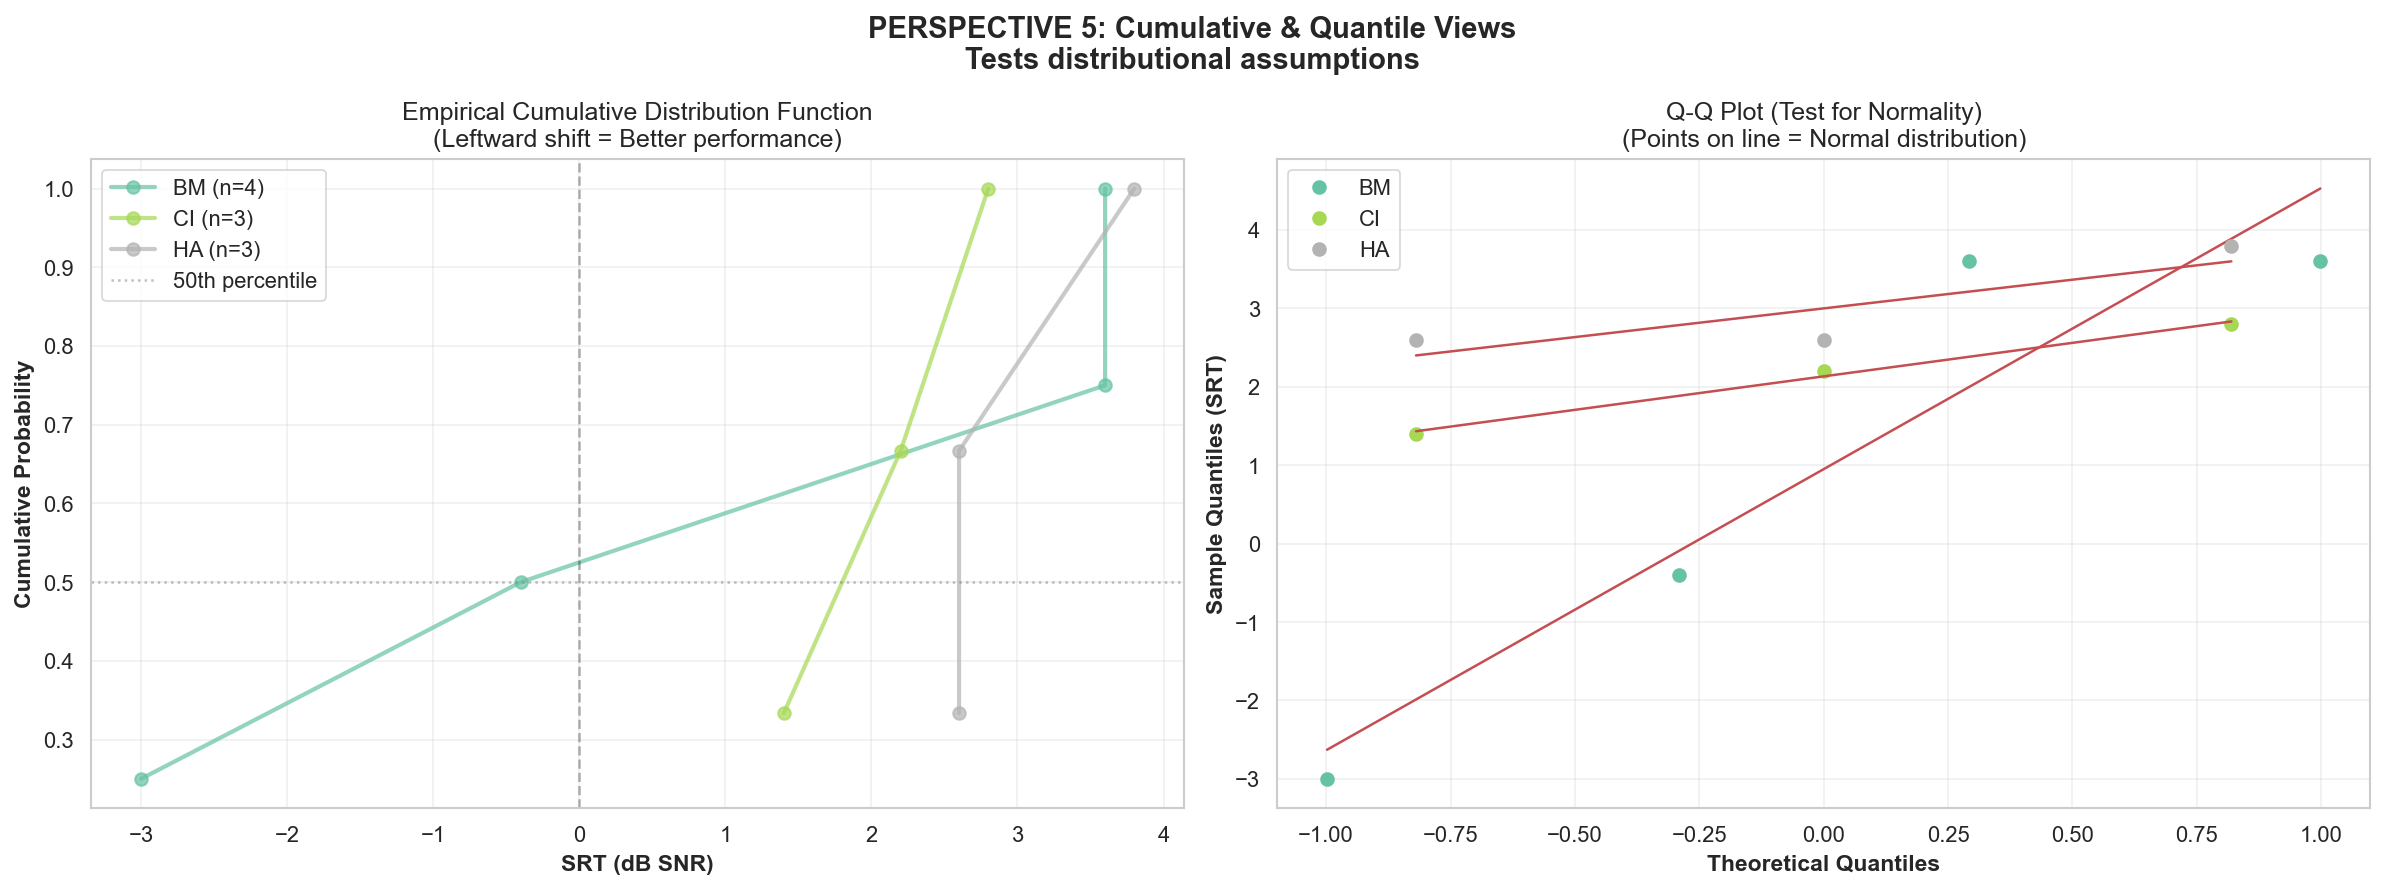


CDF & Q-Q Plot Interpretation:
----------------------------------------------------------------------
Left (Empirical CDF):
  • X-axis: SRT value
  • Y-axis: Proportion of data at or below that SRT
  • Steeper curve: Data more concentrated (less variable)
  • Curve shifted left: Better performance overall
  • At Y=0.5 line: Median SRT for each condition
Right (Q-Q Plot):
  • Points on reference line: Data is normally distributed
  • Points above line: Heavier right tail than normal
  • Points below line: Heavier left tail than normal
  • S-shaped curve: Distribution is skewed
  • Use to validate ANOVA assumptions (normality required)


In [19]:
# ===== PERSPECTIVE 5: CUMULATIVE DISTRIBUTION FUNCTIONS =====

if not df_valid.empty:
    print("\n" + "="*70)
    print("PERSPECTIVE 5: CUMULATIVE DISTRIBUTION FUNCTIONS")
    print("="*70)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    conditions = sorted(df_valid['condition'].unique())
    colors = plt.cm.Set2(np.linspace(0, 1, len(conditions)))
    
    # 5A. Empirical CDF
    for i, cond in enumerate(conditions):
        data = np.sort(df_valid[df_valid['condition'] == cond]['srt'].dropna())
        y = np.arange(1, len(data) + 1) / len(data)
        axes[0].plot(data, y, marker='o', linewidth=2, markersize=6,
                    color=colors[i], label=f'{cond} (n={len(data)})', alpha=0.7)
    
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='50th percentile')
    axes[0].set_xlabel('SRT (dB SNR)', fontweight='bold')
    axes[0].set_ylabel('Cumulative Probability', fontweight='bold')
    axes[0].set_title('Empirical Cumulative Distribution Function\n(Leftward shift = Better performance)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 5B. Q-Q plot (compare to normal distribution)
    from scipy import stats as sp_stats
    for i, cond in enumerate(conditions):
        data = df_valid[df_valid['condition'] == cond]['srt'].dropna()
        if len(data) > 2:
            sp_stats.probplot(data, dist="norm", plot=axes[1])
            # Get the line that was just added and set its properties
            lines = axes[1].get_lines()
            if len(lines) > i*2:
                lines[i*2].set_color(colors[i])
                lines[i*2].set_marker('o')
                lines[i*2].set_markersize(6)
                lines[i*2].set_label(f'{cond}')
    
    axes[1].set_title('Q-Q Plot (Test for Normality)\n(Points on line = Normal distribution)')
    axes[1].set_xlabel('Theoretical Quantiles', fontweight='bold')
    axes[1].set_ylabel('Sample Quantiles (SRT)', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle('PERSPECTIVE 5: Cumulative & Quantile Views\nTests distributional assumptions', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nCDF & Q-Q Plot Interpretation:")
    print("-" * 70)
    print("Left (Empirical CDF):")
    print("  • X-axis: SRT value")
    print("  • Y-axis: Proportion of data at or below that SRT")
    print("  • Steeper curve: Data more concentrated (less variable)")
    print("  • Curve shifted left: Better performance overall")
    print("  • At Y=0.5 line: Median SRT for each condition")
    print("Right (Q-Q Plot):")
    print("  • Points on reference line: Data is normally distributed")
    print("  • Points above line: Heavier right tail than normal")
    print("  • Points below line: Heavier left tail than normal")
    print("  • S-shaped curve: Distribution is skewed")
    print("  • Use to validate ANOVA assumptions (normality required)")

## SNR 50% Threshold AnalysisAnalysis of the SNR 50% threshold metric, which represents the signal-to-noise ratio where performance is at the psychometric midpoint (50% accuracy).

In [ ]:
# ========================================# SNR 50% THRESHOLD VISUALIZATIONS# ========================================# Check if we have CRM summary dataif 'df_crm_summary' in locals() and not df_crm_summary.empty and 'snr_50_threshold' in df_crm_summary.columns:    fig, axes = plt.subplots(2, 2, figsize=(14, 10))    # Plot 1: SNR 50% by condition    conditions = df_crm_summary['condition'].unique()    snr_means = []    snr_cis = []    for cond in conditions:        data = df_crm_summary[df_crm_summary['condition'] == cond]['snr_50_threshold'].dropna()        if len(data) > 0:            mean = data.mean()            sem = data.sem()            ci = 1.96 * sem  # 95% CI            snr_means.append(mean)            snr_cis.append(ci)        else:            snr_means.append(0)            snr_cis.append(0)    axes[0, 0].bar(range(len(conditions)), snr_means, yerr=snr_cis, capsize=5, alpha=0.7, color='steelblue')    axes[0, 0].set_xticks(range(len(conditions)))    axes[0, 0].set_xticklabels(conditions)    axes[0, 0].set_ylabel('SNR 50% Threshold (dB)')    axes[0, 0].set_title('SNR 50% Threshold by Condition\nError bars: 95% CI')    axes[0, 0].grid(axis='y', alpha=0.3)    axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)    # Plot 2: Box plot by condition and masker type    if 'masker_type' in df_crm_summary.columns:        plot_data = []        labels = []        for cond in conditions:            for mtype in ['Same', 'Diff']:                data = df_crm_summary[(df_crm_summary['condition'] == cond) &                                     (df_crm_summary['masker_type'] == mtype)]['snr_50_threshold'].dropna()                if len(data) > 0:                    plot_data.append(data)                    labels.append(f"{cond}\n{mtype}")        if plot_data:            bp = axes[0, 1].boxplot(plot_data, labels=labels, patch_artist=True)            for patch in bp['boxes']:                patch.set_facecolor('lightblue')            axes[0, 1].set_ylabel('SNR 50% Threshold (dB)')            axes[0, 1].set_title('SNR 50% Distribution by Condition and Masker Type')            axes[0, 1].grid(axis='y', alpha=0.3)            axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)            axes[0, 1].tick_params(axis='x', rotation=45)    # Plot 3: SNR 50% vs SRT comparison    valid_data = df_crm_summary.dropna(subset=['srt', 'snr_50_threshold'])    if len(valid_data) > 0:        # Color by condition        condition_colors = {'BM': 'blue', 'CI': 'red', 'HA': 'green'}        colors = [condition_colors.get(c, 'gray') for c in valid_data['condition']]        axes[1, 0].scatter(valid_data['srt'], valid_data['snr_50_threshold'],                          c=colors, s=80, alpha=0.6, edgecolors='black', linewidth=0.5)        # Add y=x line        all_vals = list(valid_data['srt']) + list(valid_data['snr_50_threshold'])        min_val, max_val = min(all_vals), max(all_vals)        axes[1, 0].plot([min_val, max_val], [min_val, max_val],                       'k--', alpha=0.5, label='y=x', linewidth=1)        axes[1, 0].set_xlabel('SRT (dB)')        axes[1, 0].set_ylabel('SNR 50% Threshold (dB)')        axes[1, 0].set_title('SNR 50% vs SRT Correlation')        axes[1, 0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c,                                             markersize=8, label=k) for k, c in condition_colors.items()] +                        [plt.Line2D([0], [0], color='k', linestyle='--', label='y=x')])        axes[1, 0].grid(True, alpha=0.3)    # Plot 4: VGRM using SNR 50%    vgrm_data = []    vgrm_labels = []    for cond in conditions:        same_data = df_crm_summary[(df_crm_summary['condition'] == cond) &                                   (df_crm_summary['masker_type'] == 'Same')]['snr_50_threshold']        diff_data = df_crm_summary[(df_crm_summary['condition'] == cond) &                                   (df_crm_summary['masker_type'] == 'Diff')]['snr_50_threshold']        if len(same_data) > 0 and len(diff_data) > 0:            vgrm = same_data.mean() - diff_data.mean()            vgrm_data.append(vgrm)            vgrm_labels.append(cond)    if vgrm_data:        axes[1, 1].bar(range(len(vgrm_labels)), vgrm_data, alpha=0.7, color='coral')        axes[1, 1].set_xticks(range(len(vgrm_labels)))        axes[1, 1].set_xticklabels(vgrm_labels)        axes[1, 1].set_ylabel('VGRM (dB)')        axes[1, 1].set_title('Voice Gender Recognition Masking (VGRM)\nSNR_50(Same) - SNR_50(Diff)')        axes[1, 1].grid(axis='y', alpha=0.3)        axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)    plt.tight_layout()    plt.show()    # Print VGRM values    print("\nVGRM Analysis using SNR 50% Threshold:")    print("="*50)    for cond, vgrm in zip(vgrm_labels, vgrm_data):        print(f"  {cond}: VGRM = {vgrm:.2f} dB")else:    print("SNR 50% threshold data not available. Ensure CRM data is loaded and processed.")

## Cumulative Distribution Functions (CDFs)Additional CDFs for various metrics across the dataset.

In [ ]:
# ========================================# CUMULATIVE DISTRIBUTION FUNCTIONS# ========================================def plot_cdf(data, xlabel, title, ax=None):    """Helper to plot CDF"""    if ax is None:        fig, ax = plt.subplots(figsize=(8, 5))    data_clean = data.dropna() if hasattr(data, 'dropna') else [x for x in data if not pd.isna(x)]    if len(data_clean) == 0:        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)        ax.set_xlabel(xlabel)        ax.set_ylabel('Cumulative Probability')        ax.set_title(title)        return ax    sorted_data = np.sort(data_clean)    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)    ax.plot(sorted_data, y, linewidth=2, color='steelblue')    ax.set_xlabel(xlabel)    ax.set_ylabel('Cumulative Probability')    ax.set_title(title)    ax.grid(True, alpha=0.3)    ax.set_ylim([0, 1])    return axfig, axes = plt.subplots(3, 2, figsize=(14, 12))# CDF 1: Reaction Times (CRM)if 'df_crm' in locals() and not df_crm.empty and 'rt' in df_crm.columns:    plot_cdf(df_crm['rt'].dropna(), 'Reaction Time (s)',             'CDF: CRM Reaction Times', axes[0, 0])else:    axes[0, 0].text(0.5, 0.5, 'CRM data not available', ha='center', va='center', transform=axes[0, 0].transAxes)    axes[0, 0].set_title('CDF: CRM Reaction Times')# CDF 2: Vowel Accuracy by Talkerif 'df_vowel' in locals() and not df_vowel.empty:    vowel_acc_by_talker = df_vowel.groupby('talker_id')['score'].mean()    plot_cdf(vowel_acc_by_talker, 'Accuracy',             'CDF: Vowel Accuracy by Talker', axes[0, 1])else:    axes[0, 1].text(0.5, 0.5, 'Vowel data not available', ha='center', va='center', transform=axes[0, 1].transAxes)    axes[0, 1].set_title('CDF: Vowel Accuracy by Talker')# CDF 3: Consonant Feature Accuracy (Voicing)if 'df_consonant' in locals() and not df_consonant.empty and 'CONSONANT_FEATURES' in dir():    voicing_acc = []    for _, row in df_consonant.iterrows():        if row['target_label'] in CONSONANT_FEATURES and row['response_label'] in CONSONANT_FEATURES:            target_v = CONSONANT_FEATURES[row['target_label']][0]            response_v = CONSONANT_FEATURES[row['response_label']][0]            voicing_acc.append(1 if target_v == response_v else 0)    if voicing_acc:        plot_cdf(voicing_acc, 'Voicing Accuracy',                 'CDF: Voicing Feature Accuracy', axes[1, 0])    else:        axes[1, 0].text(0.5, 0.5, 'No voicing data', ha='center', va='center', transform=axes[1, 0].transAxes)        axes[1, 0].set_title('CDF: Voicing Feature Accuracy')else:    axes[1, 0].text(0.5, 0.5, 'Consonant data not available', ha='center', va='center', transform=axes[1, 0].transAxes)    axes[1, 0].set_title('CDF: Voicing Feature Accuracy')# CDF 4: Error Rates by Conditionif 'df_crm' in locals() and not df_crm.empty and 'correct' in df_crm.columns:    error_rates = df_crm.groupby('condition')['correct'].apply(lambda x: 1 - x.mean())    plot_cdf(error_rates, 'Error Rate',             'CDF: Error Rates by Condition', axes[1, 1])else:    axes[1, 1].text(0.5, 0.5, 'CRM data not available', ha='center', va='center', transform=axes[1, 1].transAxes)    axes[1, 1].set_title('CDF: Error Rates by Condition')# CDF 5: SNR 50% Thresholdif 'df_crm_summary' in locals() and not df_crm_summary.empty and 'snr_50_threshold' in df_crm_summary.columns:    plot_cdf(df_crm_summary['snr_50_threshold'].dropna(), 'SNR 50% (dB)',             'CDF: SNR 50% Threshold Distribution', axes[2, 0])else:    axes[2, 0].text(0.5, 0.5, 'SNR 50% data not available', ha='center', va='center', transform=axes[2, 0].transAxes)    axes[2, 0].set_title('CDF: SNR 50% Threshold Distribution')# CDF 6: Number of Reversalsif 'df_crm_summary' in locals() and not df_crm_summary.empty and 'n_reversals' in df_crm_summary.columns:    plot_cdf(df_crm_summary['n_reversals'].dropna(), 'Number of Reversals',             'CDF: Reversal Count Distribution', axes[2, 1])else:    axes[2, 1].text(0.5, 0.5, 'Reversal data not available', ha='center', va='center', transform=axes[2, 1].transAxes)    axes[2, 1].set_title('CDF: Reversal Count Distribution')plt.tight_layout()plt.show()

## Analysis Complete

---

### Next Steps:
1. **Export Results**: Save figures using `plt.savefig()` for publications
2. **Statistical Tables**: Export dataframes to CSV for reporting
3. **Interpretation**: Review all p-values and confidence intervals for clinical significance

---

**Pipeline Version**: v4.11


# Export: Markdown vs HTML

In [22]:
import os
import subprocess
import sys
import shutil
import time

def render_myself(filename=None, output_format='html', quarto_bin=None):
    """
    Renders the current notebook to HTML or PDF using Quarto.
    Place this at the end of your notebook.
    
    Args:
        filename (str): The name of this notebook file (e.g., 'analysis.ipynb')
        output_format (str): 'html' or 'pdf'
        quarto_bin (str): Optional absolute path to quarto executable if not in PATH
    """
    
    # --- 1. RECURSION GUARD ---
    if "QUARTO_BIN_PATH" in os.environ:
        print("ℹ️ Quarto render detected. Skipping trigger to prevent recursion.")
        return

    # --- 2. SAVE REMINDER ---
    # JupyterLab often blocks programmatic saving. 
    print("⚠️ IMPORTANT: Ensure you have saved (Ctrl+S) before this runs to capture latest changes.")
    time.sleep(1) 

    # --- 3. Resolve Filename ---
    if filename is None:
        print("❌ Error: Please specify your notebook filename: render_myself('Analysis.ipynb')")
        return
        
    if not os.path.exists(filename):
        print(f"❌ Error: File '{filename}' not found in current directory.")
        return

    # --- 4. Resolve Quarto Executable ---
    # Try to find quarto in PATH if not provided
    if quarto_bin is None:
        quarto_bin = shutil.which("quarto")
    
    # If still None, try common locations (Mac/Linux specific)
    if quarto_bin is None:
        common_paths = [
            "/usr/local/bin/quarto",
            "/opt/quarto/bin/quarto",
            os.path.expanduser("~/bin/quarto")
        ]
        for p in common_paths:
            if os.path.exists(p):
                quarto_bin = p
                break
    
    # If STILL None, fail gracefully
    if quarto_bin is None:
        print("❌ Error: Quarto executable not found.")
        print("1. Make sure Quarto is installed (https://quarto.org/docs/get-started/)")
        print("2. Run '!which quarto' in a cell to find the path.")
        print("3. Pass the path manually: render_myself(..., quarto_bin='/usr/local/bin/quarto')")
        return

    print(f"🚀 Starting Quarto render for: {filename}...")
    print(f"target: {output_format.upper()}")
    print(f"using: {quarto_bin}")

    # --- 5. Construct Command ---
    cmd = [
        quarto_bin, "render", filename,
        "--to", output_format,
        "--execute",                      
        "--metadata", "toc=true",         
        "--metadata", "code-fold=true",   
        "--metadata", "number-sections=true",
        "--metadata", "theme=cosmo",      
    ]
    
    if output_format == 'pdf':
        cmd.extend([
            "--metadata", "documentclass=article",
            "--metadata", "geometry:margin=1in",
            "--metadata", "fig-cap-location=bottom"
        ])

    # --- 6. Execute ---
    try:
        result = subprocess.run(
            cmd, 
            check=True, 
            text=True, 
            stdout=subprocess.PIPE, 
            stderr=subprocess.PIPE
        )
        print("\n✅ SUCCESS! Report generated.")
        out_file = filename.replace(".ipynb", f".{output_format}")
        print(f"Output file: {out_file}")
        
    except subprocess.CalledProcessError as e:
        print("\n❌ RENDER FAILED")
        print("Quarto Output:")
        print(e.stderr)
        
render_myself("analysis_v4.11_cc.ipynb", "html")

⚠️ IMPORTANT: Ensure you have saved (Ctrl+S) before this runs to capture latest changes.
🚀 Starting Quarto render for: analysis_v4.11_cc.ipynb...
target: HTML
using: /usr/local/bin/quarto

✅ SUCCESS! Report generated.
Output file: analysis_v4.11_cc.html
